# Telecom Churn Case Study [IIIT Banglore]

##  Ashwini Abhang

## Problem Statement: -

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.


## Objectives

The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

 Recommend strategies to manage customer churn based on your observations.

## Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import re
import os
from collections import Counter
from math import sqrt

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import statsmodels.api as sm

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score,classification_report
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve,plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

pd.options.display.max_rows = 300
pd.options.display.max_columns = 300

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.style as style
import matplotlib.gridspec as gridspec

# Plot Style
sns.set_context("paper")
style.use('fivethirtyeight')





## Understanding Customer Behaviour During Churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. We define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to us for prediction. Thus, after tagging churn as 1/0 based on this phase, we discard all data corresponding to this phase.

In this case, since we are working over a three-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase. Here instead of the churn phase we are direclty given the churn probability

## Reading & Understanding Data

### Reading the data

In [48]:
#Importing the train data

churn_data = pd.read_csv("train (1).csv")
churn_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

### Inspecting the Data

In [49]:
churn_data.shape

(69999, 172)

In [50]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [51]:
all_columns = churn_data.columns.tolist()

In [52]:
rech_col = [col for col in all_columns if 'rech' in col]
rech_col

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [53]:
churn_data.churn_probability.value_counts(normalize=True)

0    0.898113
1    0.101887
Name: churn_probability, dtype: float64

## Data Cleaning

### Calculating Null Values

In [54]:
# Observing for NAN values in the dataset

msng_values = round(churn_data.isna().sum() / len(churn_data) * 100, 2).sort_values(ascending=False)
msng_values

max_rech_data_6             74.90
total_rech_data_6           74.90
arpu_2g_6                   74.90
count_rech_3g_6             74.90
count_rech_2g_6             74.90
av_rech_amt_data_6          74.90
arpu_3g_6                   74.90
night_pck_user_6            74.90
fb_user_6                   74.90
date_of_last_rech_data_6    74.90
total_rech_data_7           74.48
fb_user_7                   74.48
max_rech_data_7             74.48
av_rech_amt_data_7          74.48
count_rech_2g_7             74.48
date_of_last_rech_data_7    74.48
count_rech_3g_7             74.48
arpu_2g_7                   74.48
night_pck_user_7            74.48
arpu_3g_7                   74.48
arpu_2g_8                   73.69
av_rech_amt_data_8          73.69
arpu_3g_8                   73.69
count_rech_2g_8             73.69
night_pck_user_8            73.69
count_rech_3g_8             73.69
max_rech_data_8             73.69
total_rech_data_8           73.69
fb_user_8                   73.69
date_of_last_r

### Imputing Data with High Null Values

In [55]:
#Checking if data recharge null rows coordinates with same clients data of null values in last data recharge information of June 

if churn_data['total_rech_data_6'].isnull().equals(churn_data['date_of_last_rech_data_6'].isnull()):
    print('The indexes for NULL values for month 6 are equal')

The indexes for NULL values for month 6 are equal


In [56]:
# Imputing (Filling NaN values) the data for total_rech_data_6 and av_rech_amt_data_6 as 0

churn_data['total_rech_data_6'].fillna(0, inplace=True)
churn_data['av_rech_amt_data_6'].fillna(0, inplace=True)

In [57]:
# Checking if data recharge null rows coordinates with same clients data of null values in last data recharge information of  July(7) and August(8)

if churn_data['total_rech_data_7'].isnull().equals(churn_data['date_of_last_rech_data_7'].isnull()):
    print('The indexes for NULL values for month 7 are equal')

if churn_data['total_rech_data_8'].isnull().equals(churn_data['date_of_last_rech_data_8'].isnull()):
    print('The indexes for NULL values for month 8 are equal')    

The indexes for NULL values for month 7 are equal
The indexes for NULL values for month 8 are equal


In [58]:
# Imputing (Filling NaN values) the data for total_rech_data_7, av_rech_amt_data_7, total_rech_data_8 and av_rech_amt_data_8 as 0

churn_data['total_rech_data_7'].fillna(0, inplace=True)
churn_data['av_rech_amt_data_7'].fillna(0, inplace=True)

churn_data['total_rech_data_8'].fillna(0, inplace=True)
churn_data['av_rech_amt_data_8'].fillna(0, inplace=True)

In [59]:
churn_data.shape

(69999, 172)

In [60]:
# Checking the index matching for month 6

arpu_2g_6_index = churn_data['arpu_2g_6'].isnull()
arpu_3g_6_index = churn_data['arpu_3g_6'].isnull()
night_pck_user_6_index = churn_data['night_pck_user_6'].isnull()
count_rech_2g_6_index =churn_data['count_rech_2g_6'].isnull()
count_rech_3g_6_index = churn_data['count_rech_3g_6'].isnull()
fb_user_6_index = churn_data['fb_user_6'].isnull()

# Checking if all null values belong to the same enteries

if arpu_2g_6_index.equals(arpu_2g_6_index) & arpu_3g_6_index.equals(night_pck_user_6_index) & night_pck_user_6_index.equals(count_rech_2g_6_index) & count_rech_2g_6_index.equals(count_rech_3g_6_index) & count_rech_3g_6_index.equals(fb_user_6_index):
    print('The indexes for NULL values for month 6 are equal')

The indexes for NULL values for month 6 are equal


In [61]:
# Checking the index matching for month 7

arpu_2g_7_index = churn_data['arpu_2g_7'].isnull()
arpu_3g_7_index = churn_data['arpu_3g_7'].isnull()
night_pck_user_7_index = churn_data['night_pck_user_7'].isnull()
count_rech_2g_7_index = churn_data['count_rech_2g_7'].isnull()
count_rech_3g_7_index = churn_data['count_rech_3g_7'].isnull()
fb_user_7_index = churn_data['fb_user_7'].isnull()

# Checking if all null values belong to the same enteries

if arpu_2g_7_index.equals(arpu_2g_7_index) & arpu_3g_7_index.equals(night_pck_user_7_index) & night_pck_user_7_index.equals(count_rech_2g_7_index) & count_rech_2g_7_index.equals(count_rech_3g_7_index) & count_rech_3g_7_index.equals(fb_user_7_index):
    print('The indexes for NULL values for month 7 are equal')

The indexes for NULL values for month 7 are equal


In [62]:
# Checking the index matching for month 8

arpu_2g_8_index = churn_data['arpu_2g_8'].isnull()
arpu_3g_8_index = churn_data['arpu_3g_8'].isnull()
night_pck_user_8_index = churn_data['night_pck_user_8'].isnull()
count_rech_2g_8_index =churn_data['count_rech_2g_8'].isnull()
count_rech_3g_8_index = churn_data['count_rech_3g_8'].isnull()
fb_user_8_index = churn_data['fb_user_8'].isnull()

# Checking if all null values belong to the same enteries

if arpu_2g_8_index.equals(arpu_2g_8_index) & arpu_3g_8_index.equals(night_pck_user_8_index) & night_pck_user_8_index.equals(count_rech_2g_8_index) & count_rech_2g_8_index.equals(count_rech_3g_8_index) & count_rech_3g_8_index.equals(fb_user_8_index):
    print('The indexes for NULL values for month 8 are equal')

The indexes for NULL values for month 8 are equal


In [63]:
cols_to_impute = ['fb_user_6','fb_user_7','fb_user_8',
                  'night_pck_user_6','night_pck_user_7','night_pck_user_8',
                  'arpu_3g_6','arpu_3g_7','arpu_3g_8',
                  'arpu_2g_6','arpu_2g_7','arpu_2g_8',
                  'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
                  'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8',]
for col in cols_to_impute:
    churn_data[col].fillna(0, inplace=True)

In [64]:
churn_data.rename(columns = {'jun_vbc_3g':'vbc_3g_6',
                          'jul_vbc_3g':'vbc_3g_7',
                          'aug_vbc_3g':'vbc_3g_8',
                          'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

In [65]:
churn_data[['arpu_6', 'arpu_7', 'arpu_8']].describe()

,arpu_6,arpu_7,arpu_8
count,69999.000000,69999.000000,69999.000000
mean,283.134365,278.185912,278.858826
std,334.213918,344.366927,351.924315
min,-2258.709000,-1289.715000,-945.808000
25%,93.581000,86.714000,84.095000
50%,197.484000,191.588000,192.234000
75%,370.791000,365.369500,369.909000
max,27731.088000,35145.834000,33543.624000


In [66]:
# Total number of negative observations for month 6,7,8

print('Total observations with negative arpu values for month 6 :' , len(churn_data[churn_data['arpu_6']<0]))
print('Total observations with negative arpu values for month 7 :' , len(churn_data[churn_data['arpu_7']<0]))
print('Total observations with negative arpu values for month 8 :' , len(churn_data[churn_data['arpu_8']<0]))

Total observations with negative arpu values for month 6 : 292
Total observations with negative arpu values for month 7 : 341
Total observations with negative arpu values for month 8 : 352


In [67]:
# Let's delete the rows where arpu_X with negative values

churn_data = churn_data[(churn_data['arpu_6'] >= 0) & 
                  (churn_data['arpu_7'] >= 0) & 
                  (churn_data['arpu_8'] >= 0)]
churn_data.shape

(69022, 172)

In [68]:
churn_data[['arpu_6','arpu_7','arpu_8']].describe()

,arpu_6,arpu_7,arpu_8
count,69022.000000,69022.000000,69022.000000
mean,284.780941,280.670401,280.831693
std,334.223459,344.820724,352.370311
min,0.000000,0.000000,0.000000
25%,94.731750,88.424750,85.915000
50%,198.978500,193.987000,194.243000
75%,372.419250,367.927500,371.940500
max,27731.088000,35145.834000,33543.624000


### High Churn Customers

In [69]:
# calculating total_data_rech_amt
churn_data['total_data_rech_amt_6'] = churn_data['total_rech_data_6'] * churn_data['av_rech_amt_data_6']
churn_data['total_data_rech_amt_7'] = churn_data['total_rech_data_7'] * churn_data['av_rech_amt_data_7']
churn_data['total_data_rech_amt_8'] = churn_data['total_rech_data_8'] * churn_data['av_rech_amt_data_8']


In [70]:
#Computing average recharge amount for the month 6 & 7. 
#Total amount is equal to the sum of talk time recharge and data recharge amounts for the respective months.

avg_recharge_amount_month_6_7 = churn_data[['total_data_rech_amt_6','total_data_rech_amt_7','total_rech_amt_6',
                                             'total_rech_amt_7']].mean(axis = 1)

amount_70th_percentile = np.percentile(avg_recharge_amount_month_6_7, 70)

print("70th percentile of the average recharge amount in the first two months is - ", amount_70th_percentile)

70th percentile of the average recharge amount in the first two months is -  240.5


In [71]:
churn_data.shape

(69022, 175)

In [72]:
# Refining high value customers

churn_data = churn_data[avg_recharge_amount_month_6_7 >= amount_70th_percentile]

# resetting the index
churn_data = churn_data.reset_index(drop=True)

churn_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn_probability,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8
0,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.00,58.91,25.94,15.76,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.0,0.0,0.0,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,21.54,9.36,28.31,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,6/25/2014,7/23/2014,8/20/2014,7.0,7.0,6.0,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,175.0,191.0,142.0,390.80,308.89,213.47,0.0,0.00,0.00,0.00,35.00,0.00,0.00,35.12,0.00,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.0,0.00,0.00,0,1225.0,1337.0,852.0
1,15,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,0.00,0.0,0.0,0.00,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.00,0.00,327.46,366.79,385.26,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,6.26,0.0,0.0,0.0,0.00,0.00,6.26,0.0,0.0,0.0,0.08,0.00,0.00,0.1,0.0,0.0,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.00,1.93,8.88,233.18,776.36,629.94,0.0,0.0,0.0,0.00,0.00,0.00,0.00,1.03,0.0,0.0,0.0,0.0,0.00,1.03,0.00,233.18,777.39,629.94,0.00,0.0,0.0,

### Imputing/Deleting the missing values

In [73]:
# Checking for NAN values
msng_values = round(churn_data.isna().sum() / len(churn_data) * 100, 2).sort_values(ascending=False)
msng_values

date_of_last_rech_data_8    46.41
max_rech_data_8             46.41
date_of_last_rech_data_6    44.07
max_rech_data_6             44.07
date_of_last_rech_data_7    42.91
max_rech_data_7             42.91
loc_og_t2m_mou_8             3.64
loc_og_t2f_mou_8             3.64
loc_og_t2c_mou_8             3.64
std_ic_t2f_mou_8             3.64
loc_og_mou_8                 3.64
std_og_t2t_mou_8             3.64
std_ic_t2o_mou_8             3.64
std_og_t2m_mou_8             3.64
std_og_t2f_mou_8             3.64
loc_og_t2t_mou_8             3.64
std_og_t2c_mou_8             3.64
std_ic_mou_8                 3.64
og_others_8                  3.64
std_og_mou_8                 3.64
spl_ic_mou_8                 3.64
isd_og_mou_8                 3.64
spl_og_mou_8                 3.64
ic_others_8                  3.64
std_ic_t2m_mou_8             3.64
isd_ic_mou_8                 3.64
roam_ic_mou_8                3.64
loc_ic_t2m_mou_8             3.64
loc_ic_mou_8                 3.64
offnet_mou_8  

In [74]:
#dropping the date_of_last_rech_data_6, date_of_last_rech_data_7 and date_of_last_rech_data_8 columns
churn_data.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'],axis = 1, inplace = True)
print("Number of Columns remaining:",len(churn_data.columns))

Number of Columns remaining: 172


In [75]:
# checking the data distribution of the 3 columns with high null percentage: 
churn_data[['max_rech_data_6', 'max_rech_data_7' , 'max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,11595.000000,11835.000000,11111.000000
mean,140.066494,140.238276,135.784538
std,119.859844,119.695520,119.485155
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,152.000000,152.000000,152.000000
75%,198.000000,198.000000,198.000000
max,1555.000000,1555.000000,1555.000000


In [76]:
# Finding null values in the max_rech_data_6, max_rech_data_7 and max_rech_data_8
print ("Total NULL values for max_rech_data_6 column : ",churn_data.max_rech_data_6.isnull().sum())
print ("Total NULL values for max_rech_data_7 column : ",churn_data.max_rech_data_7.isnull().sum())
print ("Total NULL values for max_rech_data_8 column : ",churn_data.max_rech_data_8.isnull().sum())

Total NULL values for max_rech_data_6 column :  9137
Total NULL values for max_rech_data_7 column :  8897
Total NULL values for max_rech_data_8 column :  9621


In [77]:
# Imputing these columns
for col in ['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']:
    churn_data[col].fillna(0, inplace=True)

In [78]:
# Re-checking NAN values
round(churn_data.isna().sum() / len(churn_data) * 100, 2).sort_values(ascending=False)

std_ic_t2f_mou_8         3.64
std_ic_mou_8             3.64
std_og_t2f_mou_8         3.64
roam_og_mou_8            3.64
isd_ic_mou_8             3.64
loc_og_t2t_mou_8         3.64
ic_others_8              3.64
loc_og_t2m_mou_8         3.64
og_others_8              3.64
loc_og_t2f_mou_8         3.64
spl_og_mou_8             3.64
loc_og_t2c_mou_8         3.64
isd_og_mou_8             3.64
loc_og_mou_8             3.64
std_og_mou_8             3.64
std_og_t2t_mou_8         3.64
std_og_t2c_mou_8         3.64
roam_ic_mou_8            3.64
spl_ic_mou_8             3.64
std_og_t2m_mou_8         3.64
loc_ic_t2m_mou_8         3.64
std_ic_t2o_mou_8         3.64
onnet_mou_8              3.64
loc_ic_t2f_mou_8         3.64
loc_ic_t2t_mou_8         3.64
std_ic_t2m_mou_8         3.64
offnet_mou_8             3.64
std_ic_t2t_mou_8         3.64
loc_ic_mou_8             3.64
std_ic_t2t_mou_6         1.83
std_og_t2c_mou_6         1.83
loc_ic_t2f_mou_6         1.83
loc_ic_t2m_mou_6         1.83
loc_ic_mou

In [79]:
# Dropping all the date columns
churn_data.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
                        'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], axis = 1, inplace = True)
churn_data.shape

(20732, 166)

In [80]:
# Finding features with 0 Variance 
columns_with_0_variance = churn_data.var() == 0
print("Total columns with ZERO variance are : ", columns_with_0_variance.sum())

column_name_with_0_variance = columns_with_0_variance[columns_with_0_variance == 1].index
print(column_name_with_0_variance)

Total columns with ZERO variance are :  10
Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')


In [81]:
# Dropping columns with 0 variance 
churn_data.drop(column_name_with_0_variance,axis=1, inplace = True)
churn_data.shape

(20732, 156)

In [82]:
# Dropping individual columns whose totals are specified as a different features

individual_cols = ['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
                   'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
                   'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
                   'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8',
                   'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8',
                   'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',
                   'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
                   'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
                   'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
                   'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
                   'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
                   'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
                   'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
                   'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
                   'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
                   'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
                   'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8','id']

churn_data.drop(individual_cols, axis = 1, inplace = True)

churn_data.shape


(20732, 104)

In [83]:
# Storing the null columns as a list

cols_null = churn_data.columns[churn_data.isna().any()].tolist()
print(cols_null)

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8']


In [84]:
# Imputing all the the null columns with Iterative Imputer

imp = IterativeImputer()
churn_data[cols_null] = imp.fit_transform(churn_data[cols_null])

In [85]:
# Observing if the imputation is done rightly
churn_data.isnull().sum()

arpu_6                   0
arpu_7                   0
arpu_8                   0
onnet_mou_6              0
onnet_mou_7              0
onnet_mou_8              0
offnet_mou_6             0
offnet_mou_7             0
offnet_mou_8             0
roam_ic_mou_6            0
roam_ic_mou_7            0
roam_ic_mou_8            0
roam_og_mou_6            0
roam_og_mou_7            0
roam_og_mou_8            0
loc_og_mou_6             0
loc_og_mou_7             0
loc_og_mou_8             0
std_og_mou_6             0
std_og_mou_7             0
std_og_mou_8             0
isd_og_mou_6             0
isd_og_mou_7             0
isd_og_mou_8             0
spl_og_mou_6             0
spl_og_mou_7             0
spl_og_mou_8             0
og_others_6              0
og_others_7              0
og_others_8              0
total_og_mou_6           0
total_og_mou_7           0
total_og_mou_8           0
loc_ic_mou_6             0
loc_ic_mou_7             0
loc_ic_mou_8             0
std_ic_mou_6             0
s

### Handling Categorical Variables

In [86]:
# Checking if the dataset has unique values 

# Defining a function for identifying all the uniques values in the columns

def frequency_info(df):
    df_result = pd.DataFrame(columns=["columns","values","unique_values"])
    
    df_temp=pd.DataFrame()
    for value in df.columns:
        df_temp["columns"] = [value]
        df_temp["values"] = [df[value].unique()]
        df_temp["unique_values"] = df[value].nunique()
        df_result = df_result.append(df_temp)
    
    df_result.sort_values("unique_values", ascending =True, inplace=True)
    df_result.set_index("columns", inplace=True)
    return df_result

In [87]:
# Identifying categorical values with uniqueness
frequency_info(churn_data)

,values,unique_values
columns,,
night_pck_user_6,"[0.0, 1.0]",2
churn_probability,"[0, 1]",2
fb_user_8,"[1.0, 0.0]",2
fb_user_7,"[1.0, 0.0]",2
fb_user_6,"[1.0, 0.0]",2
night_pck_user_7,"[0.0, 1.0]",2
night_pck_user_8,"[0.0, 1.0]",2
monthly_2g_6,"[0, 1, 2, 3, 4]",5
monthly_2g_8,"[0, 1, 2, 4, 3, 5]",6


In [88]:
# Converting catgorical values to integer type
category_list = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

churn_data[category_list] = churn_data[category_list].astype(int)

churn_data[category_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20732 entries, 0 to 20731
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   night_pck_user_6  20732 non-null  int32
 1   night_pck_user_7  20732 non-null  int32
 2   night_pck_user_8  20732 non-null  int32
 3   fb_user_6         20732 non-null  int32
 4   fb_user_7         20732 non-null  int32
 5   fb_user_8         20732 non-null  int32
dtypes: int32(6)
memory usage: 486.0 KB


## Exploratory Data Analysis

In [89]:
# Creating a list for categorical and numerical features

cat_cols = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8','monthly_2g_6', 'monthly_2g_7','monthly_2g_8',
            'sachet_2g_6','sachet_2g_7','sachet_2g_8',
            'sachet_3g_6','sachet_3g_7','sachet_3g_8',
            'monthly_3g_6','monthly_3g_7','monthly_3g_8'] 
num_cols = churn_data.dtypes[(churn_data.dtypes == "float64") | (churn_data.dtypes == "int64") | (churn_data.dtypes == "int32")].index.to_list()
for col in cat_cols:
    num_cols.remove(col) 
num_cols.remove('churn_probability')

In [90]:
print("CATEGORICAL FEATURES : \n {} \n\n".format(cat_cols))
print("NUMERICAL FEATURES : \n {} \n\n".format(num_cols))

CATEGORICAL FEATURES : 
 ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8'] 


NUMERICAL FEATURES : 
 ['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_

### Churn Distribution

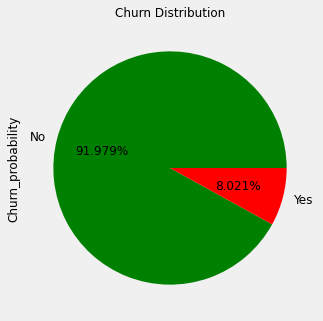

In [91]:
# Understanding the churn distribution
ax = (churn_data['churn_probability'].value_counts()*100.0 /len(churn_data)).plot.pie(autopct='%.3f%%', 
                                                                                        labels = ['No', 'Yes'],
                                                                                        colors =['g','r'],
                                                                                        figsize =(5,5), 
                                                                                        fontsize = 12 )                                                                           

ax.set_ylabel('Churn_probability',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)
plt.show()


### Categorical Features EDA

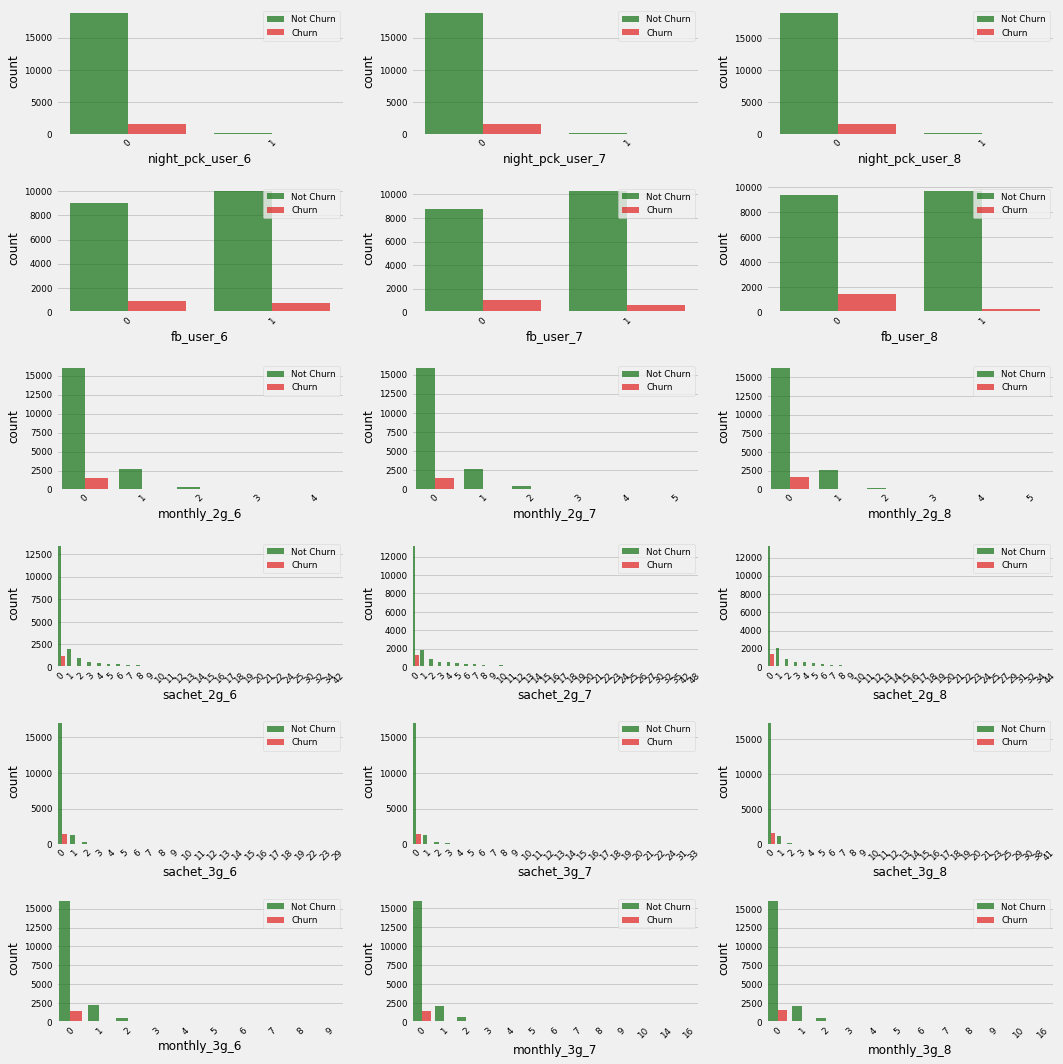

In [92]:
# Plotting a countplot with all categorical variables 
fig, axes = plt.subplots(round(len(cat_cols) / 3), 3, figsize=(15, 15))

total = float(len(churn_data))
for i, ax in enumerate(fig.axes):
    if i < len(cat_cols):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=cat_cols[i], alpha=0.7, data=churn_data, hue=churn_data['churn_probability'],palette=['g','r'], ax=ax)
        # Renaming the Legends from 0/1 to Not Churn/Churn
        ax.legend(['Not Churn','Churn'],loc="upper right")
        # adjusting font size of X-Labels and Y-Labels
        ax.set_xlabel(cat_cols[i],fontsize=12)
        ax.set_ylabel('count',fontsize=12)
        
fig.tight_layout()

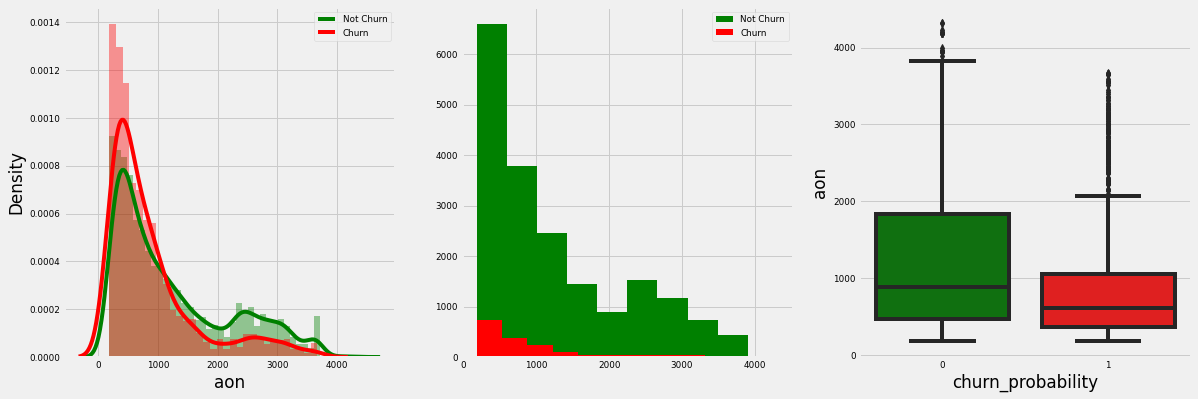

In [93]:
# Data Distribution on the Age of Network feature (AON)
plt.figure(figsize = (18,6))
plt.subplot(1,3,1)
sns.distplot(churn_data.loc[churn_data['churn_probability']==0,'aon'],hist=True, color = 'g')
sns.distplot(churn_data.loc[churn_data['churn_probability']==1,'aon'],hist=True, color='r')
plt.legend(['Not Churn','Churn'])

plt.subplot(1,3,2)
plt.hist(churn_data.loc[churn_data['churn_probability']==0,'aon'],color = 'g')
plt.hist(churn_data.loc[churn_data['churn_probability']==1,'aon'],color = 'r')
plt.legend(['Not Churn','Churn'])

plt.subplot(1,3,3)
sns.boxplot(y='aon', data = churn_data, x='churn_probability',palette =['g','r'])

plt.show()

### Numerical Features EDA

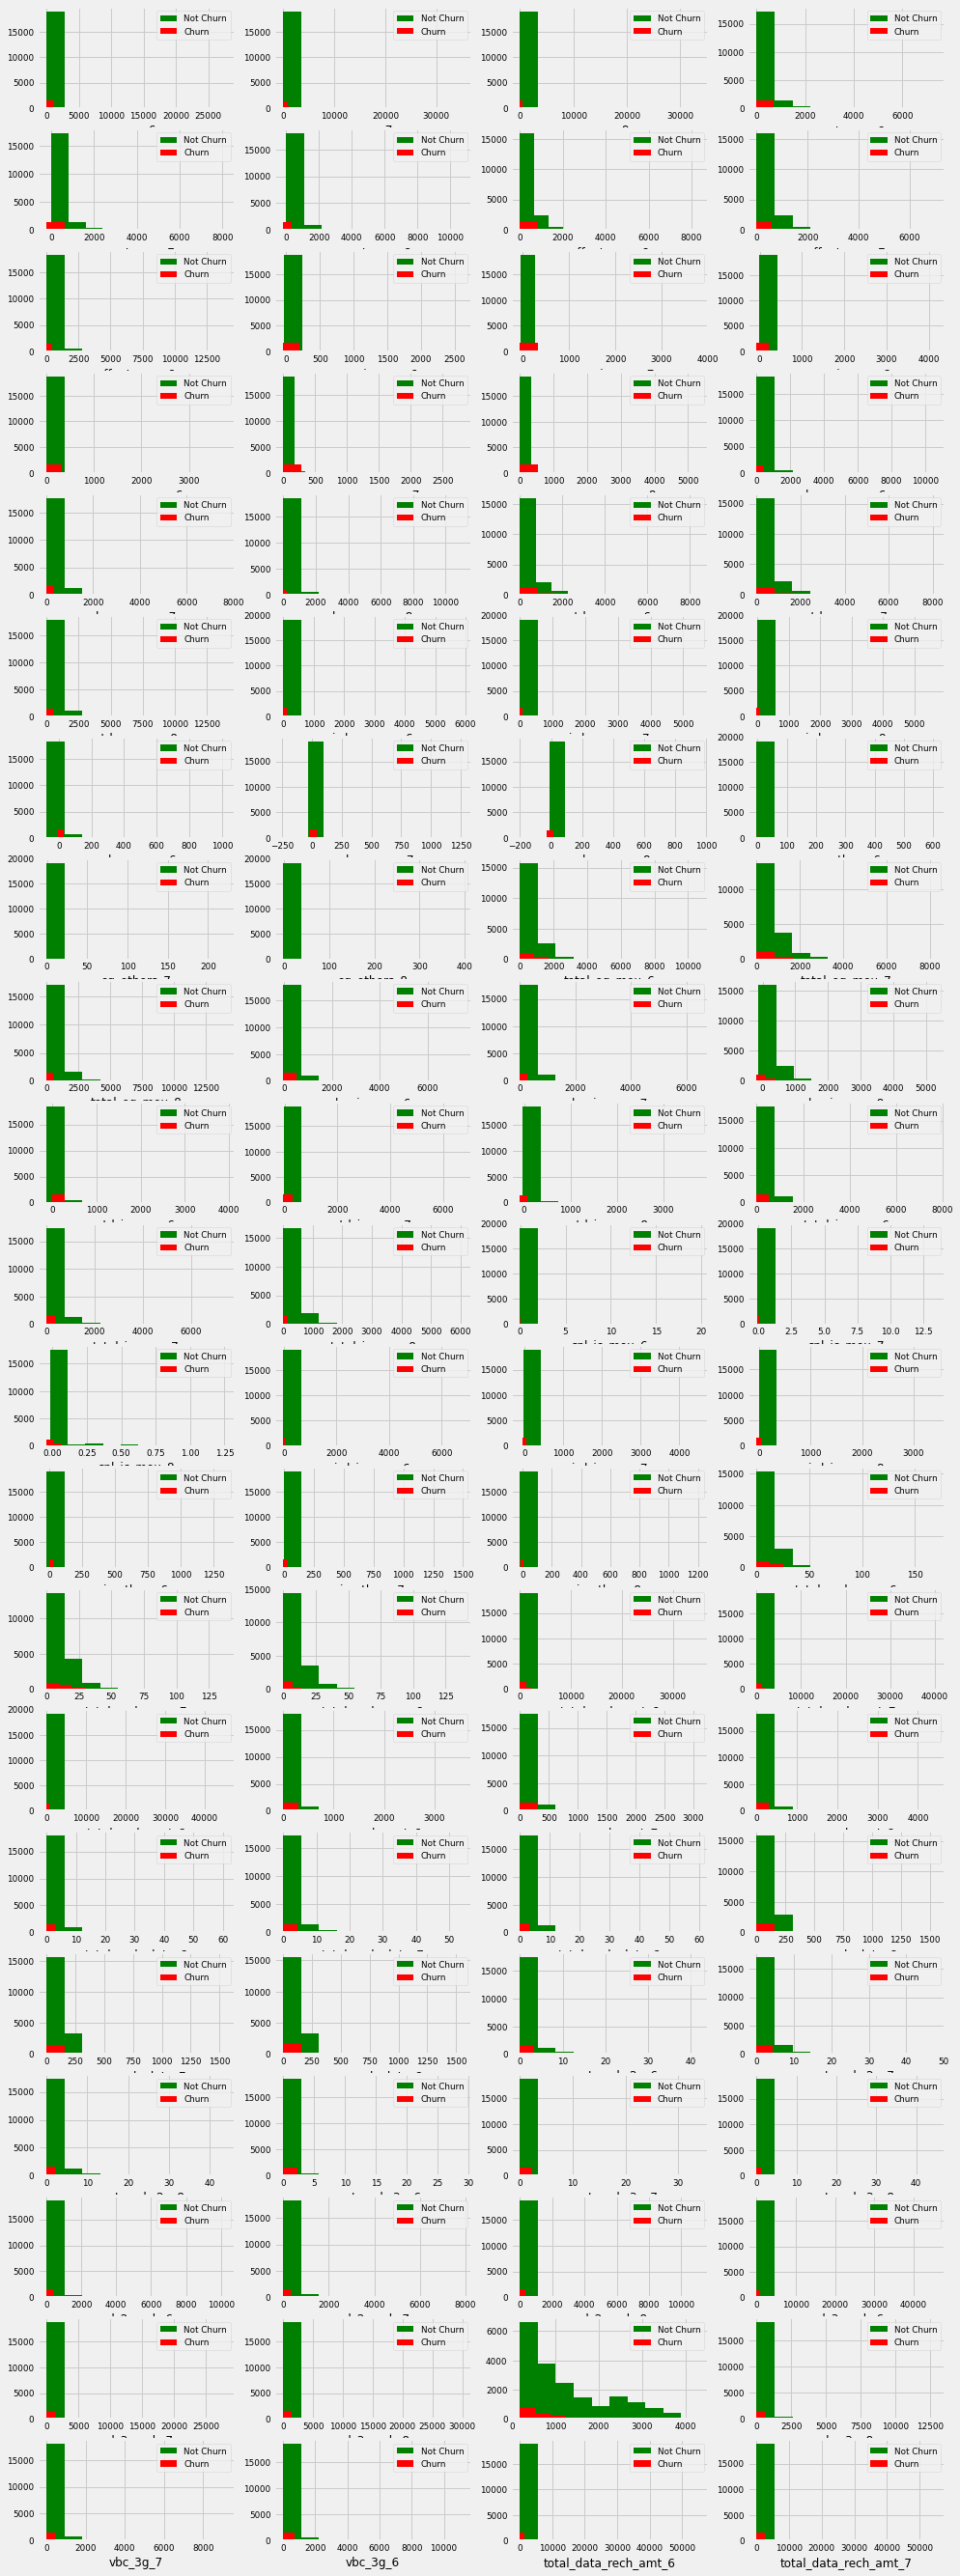

In [94]:
# Plotting countplots for numerical features
fig, axes = plt.subplots(round(len(num_cols) / 4), 4, figsize=(15, 45))

for i, ax in enumerate(fig.axes):
    if i < len(num_cols):
        ax.hist(churn_data.loc[churn_data['churn_probability']==0, num_cols[i]],color='g')
        ax.hist(churn_data.loc[churn_data['churn_probability']==1, num_cols[i]],color='r')
        # adjusting font size of X-Labels and Y-Labels
        ax.set_xlabel(num_cols[i],fontsize=12)
        ax.legend(['Not Churn','Churn'],loc = 'best')        
plt.show()

### Checking For Outliers

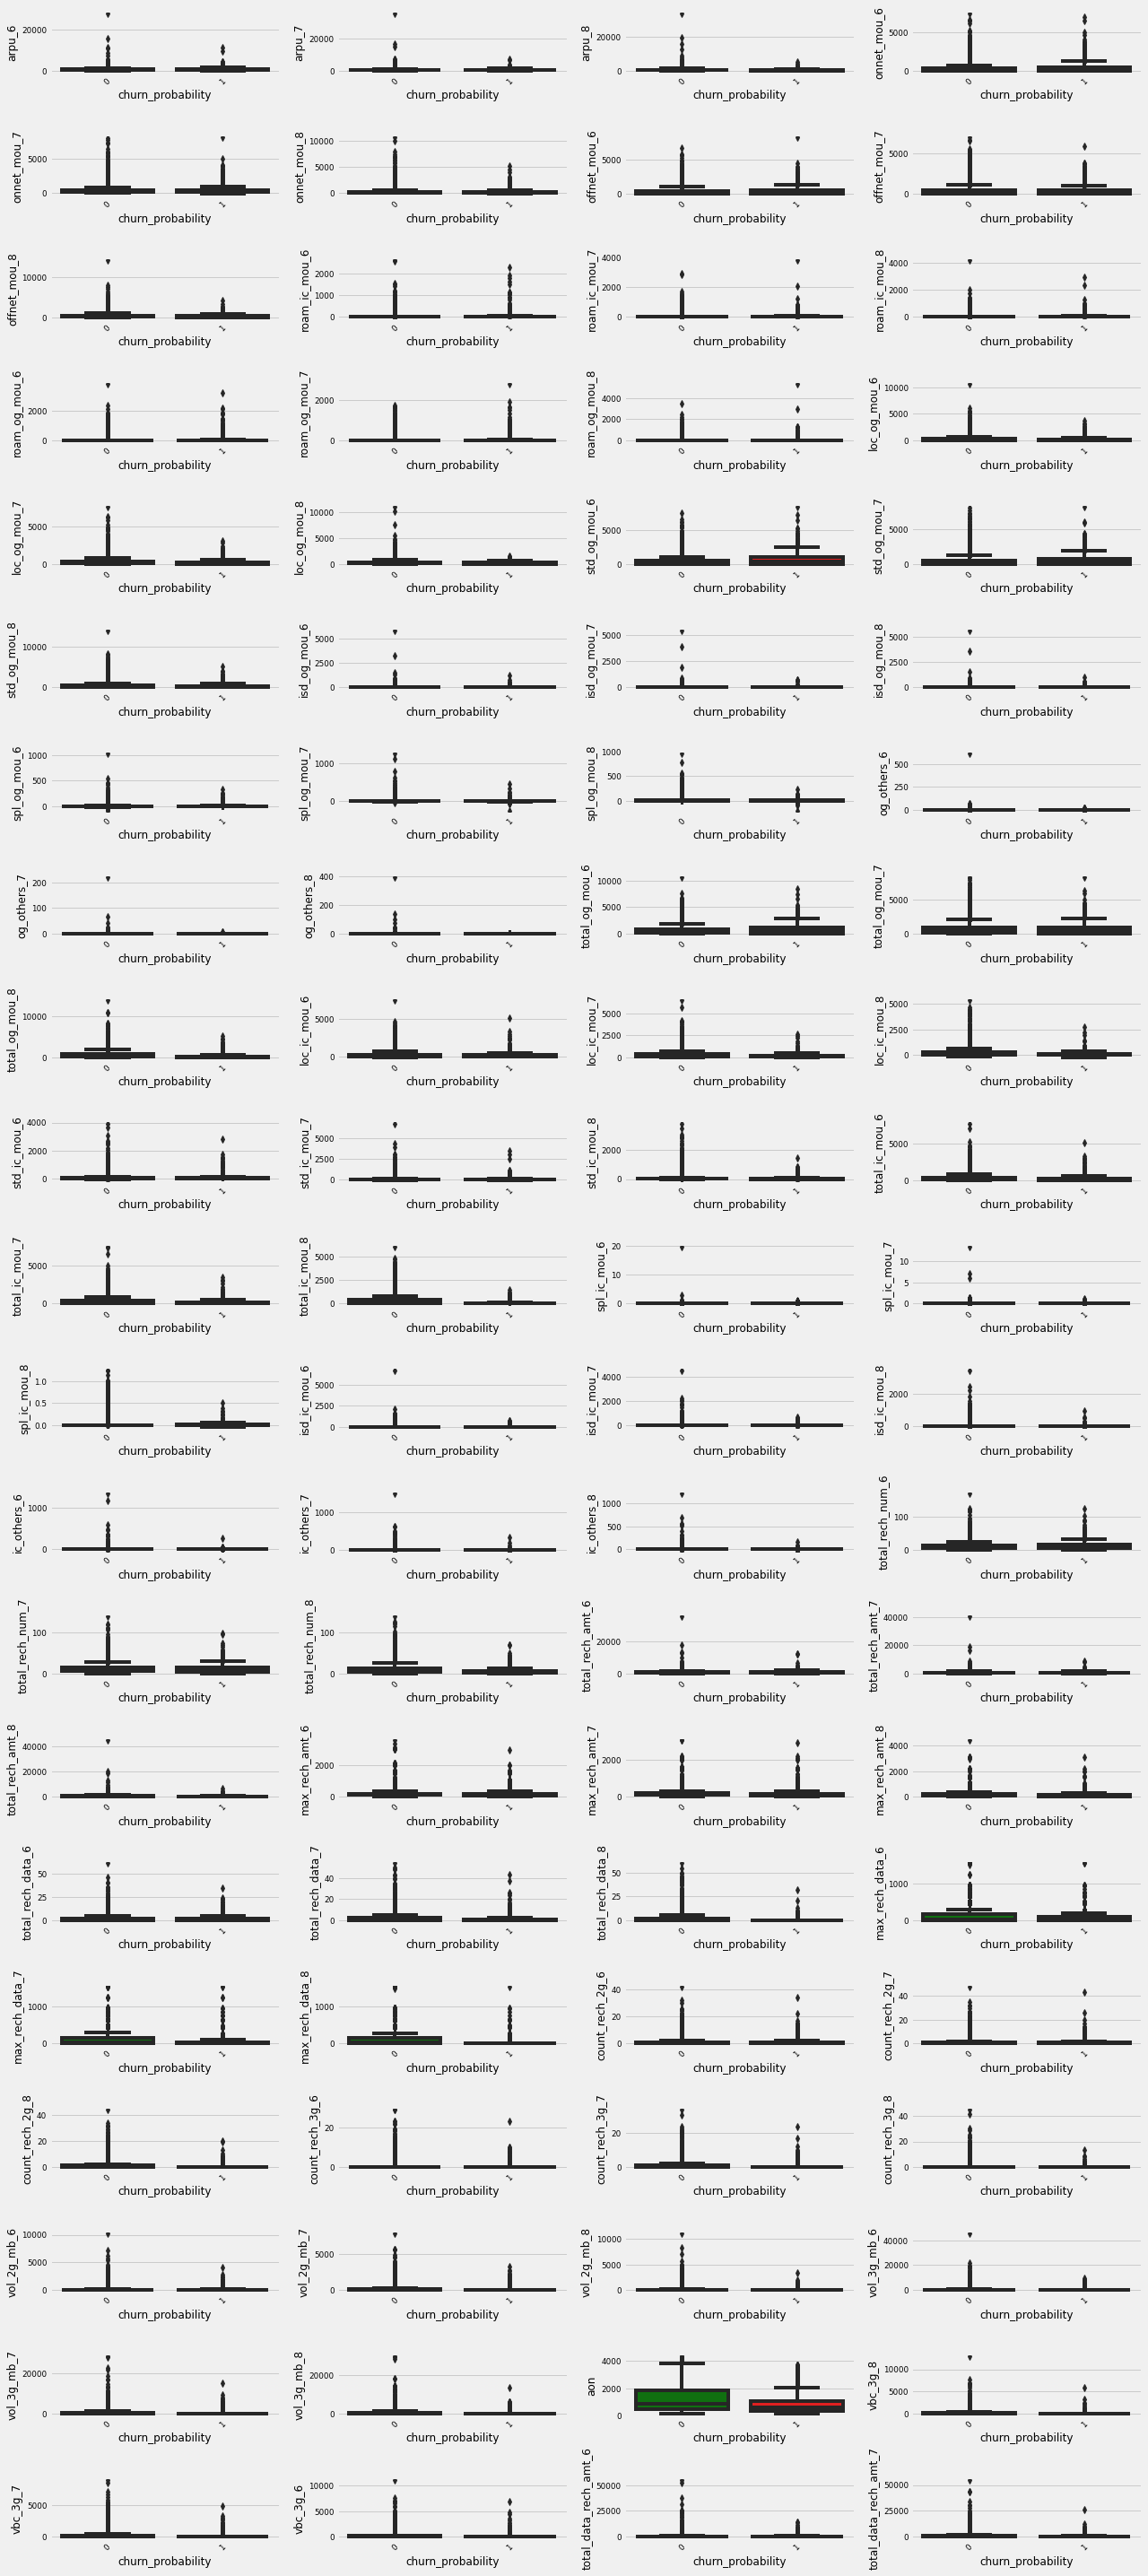

In [95]:
# Creating box plots for all numeric features to identify outliers

fig, axes = plt.subplots(round(len(num_cols) / 4), 4, figsize=(18, 40))

for i, ax in enumerate(fig.axes):
    if i < len(num_cols):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(y=num_cols[i], data=churn_data, x='churn_probability', ax=ax,palette = ['g','r'])
        ax.set_ylabel(num_cols[i],fontsize=12)
        ax.set_xlabel('churn_probability',fontsize=12)

fig.tight_layout()

### Understanding the Correlation among variables

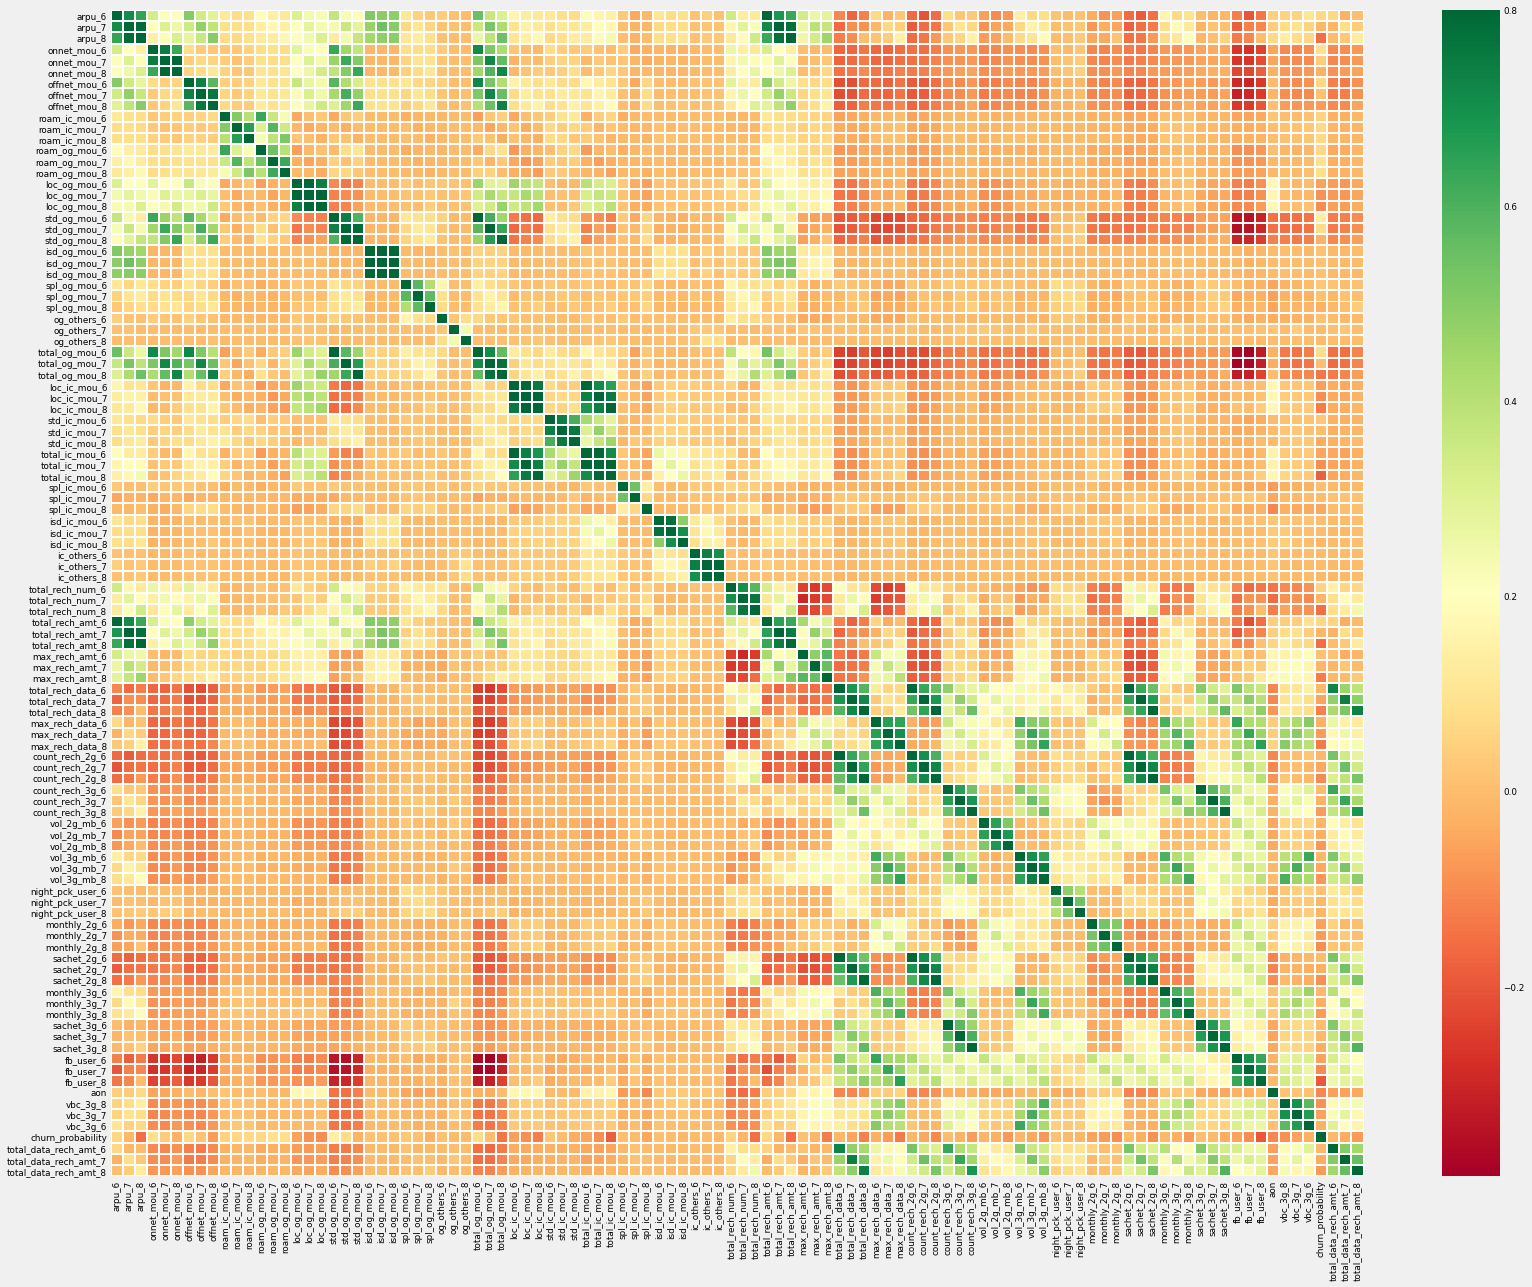

In [96]:
# Plotting a correlation heatmap

corrmat = churn_data.corr()
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corrmat, vmax=.8,cmap="RdYlGn",linewidth =1)
plt.show()

In [97]:
# Checking for features that highly correlated

corr_matrix =churn_data.corr().abs()


upper_triangle = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)))

highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]
print("List of highly correlated features from the above plot - \n\n", highly_correlated_features)
print("\n\nTotal features with high correlation - ", len(highly_correlated_features))

List of highly correlated features from the above plot - 

 ['onnet_mou_8', 'loc_og_mou_7', 'loc_og_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


Total features with high correlation -  25


## Data Preparation

### Treating the Outliers

In [98]:
#Finding features that are skewed in nature

skew_features = churn_data[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.2]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.2 ".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features


There are 85 numerical features with Skew > 0.2 


og_others_7              114.125705
og_others_8              106.871123
og_others_6              102.977619
isd_og_mou_6              79.070792
isd_og_mou_8              77.641631
isd_og_mou_7              77.268174
ic_others_6               55.214808
spl_ic_mou_7              52.280814
spl_ic_mou_6              48.003689
ic_others_8               45.721125
ic_others_7               42.780868
isd_ic_mou_6              40.084331
isd_ic_mou_7              21.803402
total_rech_amt_8          21.659719
arpu_7                    21.179680
spl_og_mou_7              20.779968
roam_ic_mou_8             20.132335
total_rech_amt_7          18.951536
arpu_8                    18.318720
total_data_rech_amt_8     18.250420
roam_ic_mou_7             18.184003
isd_ic_mou_8              17.746394
spl_og_mou_6              16.491658
roam_og_mou_8             16.313079
total_rech_amt_6          15.206964
spl_og_mou_8              14.989280
arpu_6                    14.366297
std_ic_mou_7              13

### Handling Outliers Using Boxcox

In [99]:
# Handling outliers in numerical features using Boxcox

for i in skew_index:
    churn_data[i] = boxcox1p(churn_data[i], boxcox_normmax(churn_data[i] + 1, method = 'mle'))

### Checking the data after handling the outliers

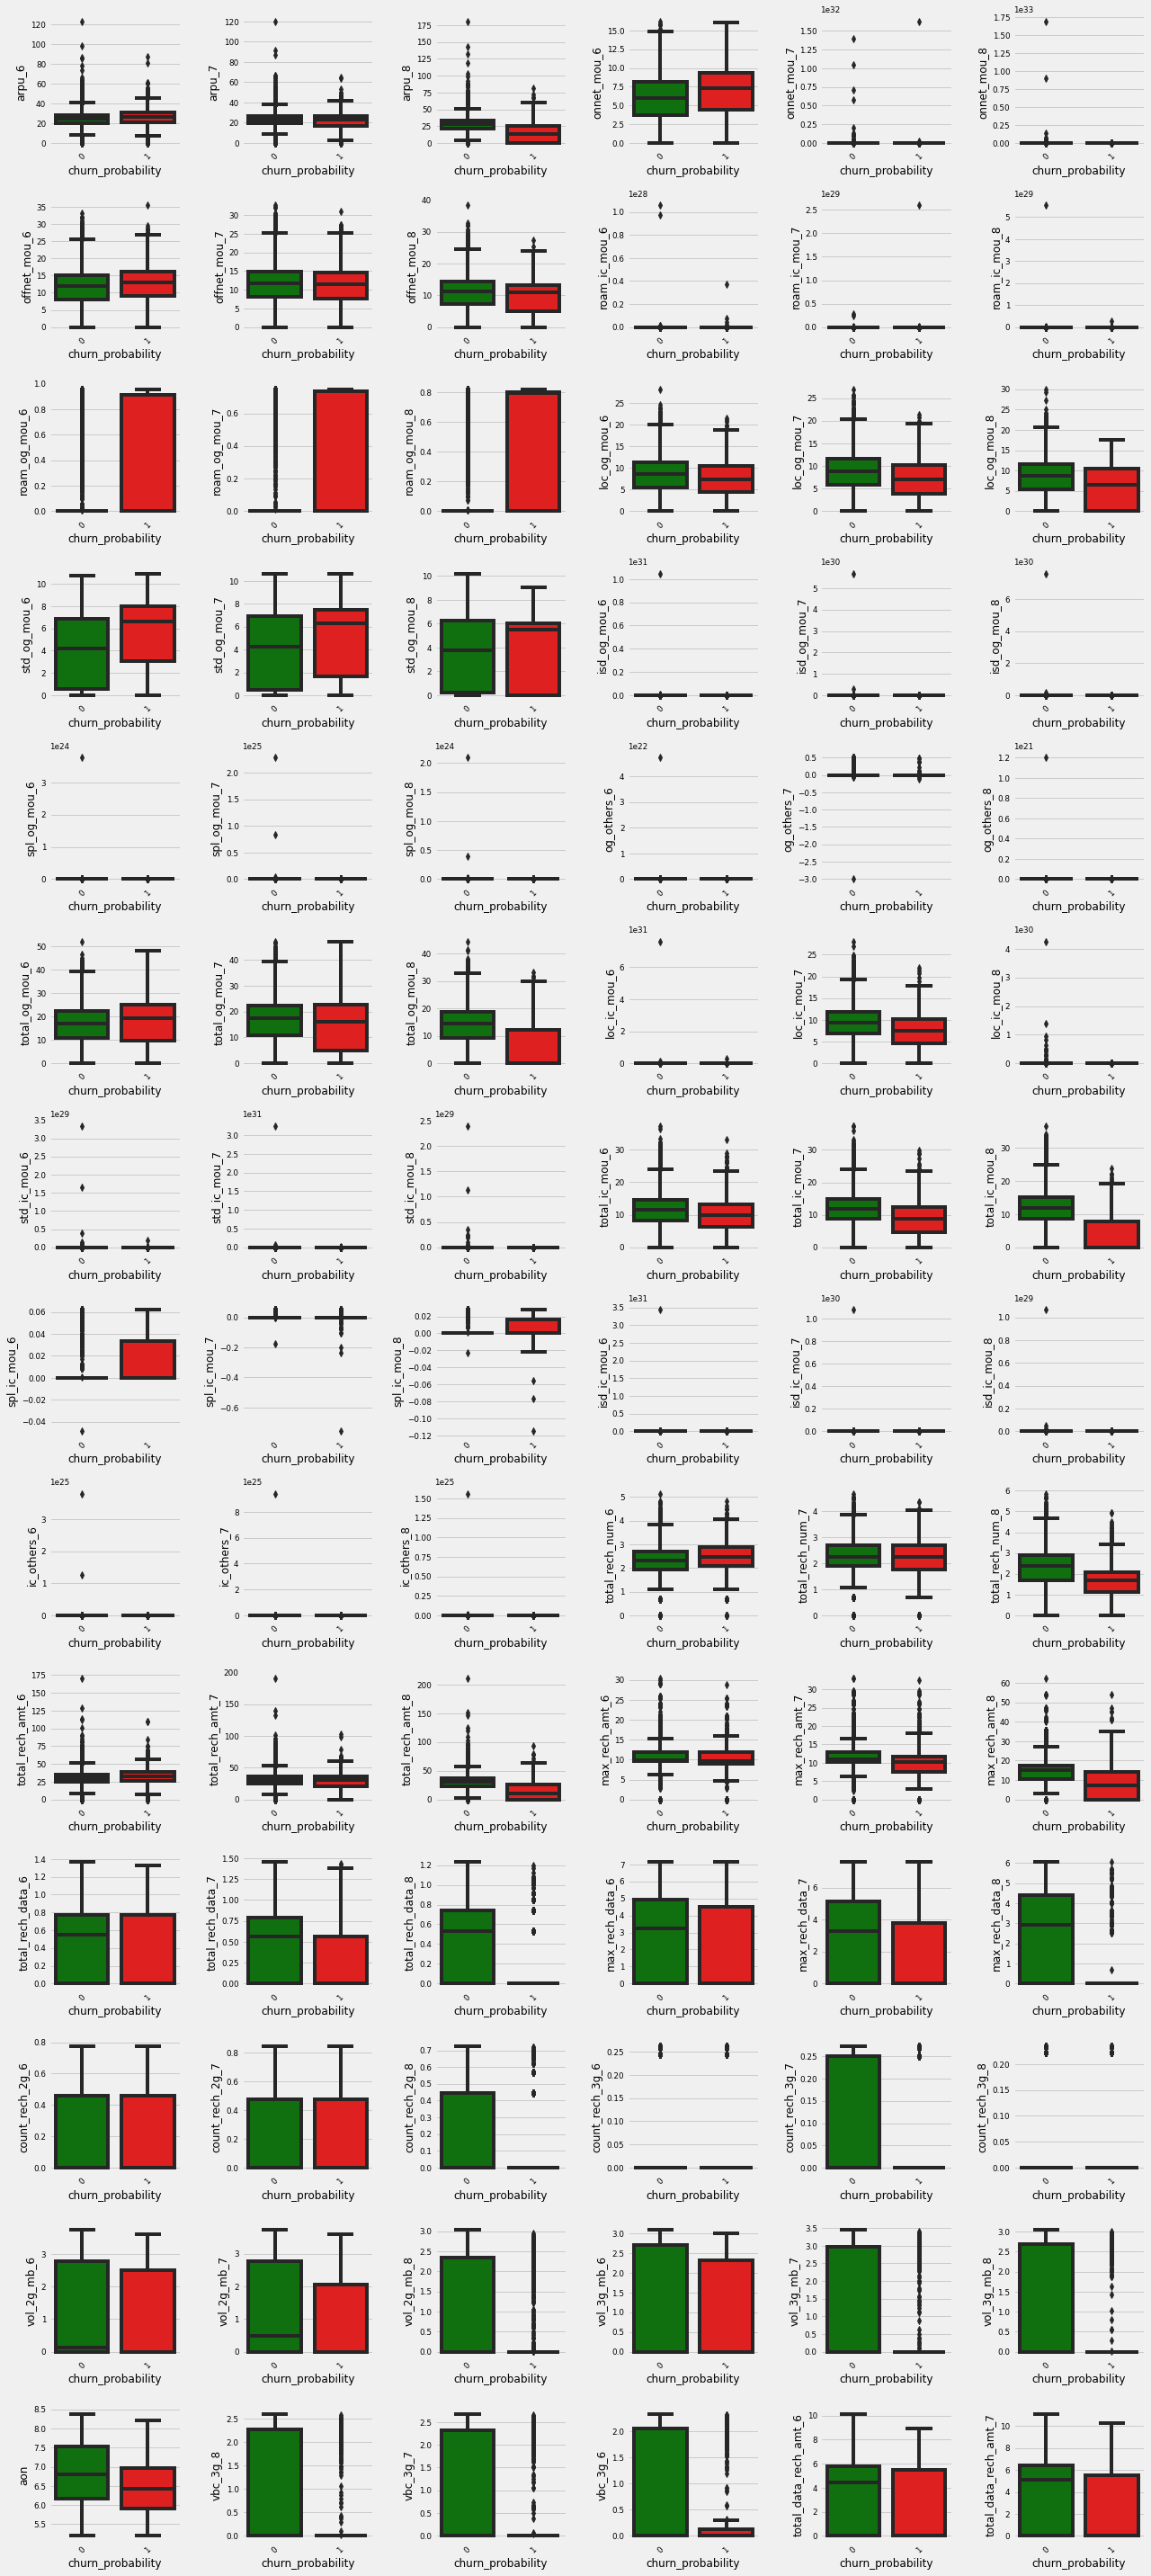

In [100]:
# Rechecking for outliers after treatment
fig, axes = plt.subplots(round(len(num_cols) / 6), 6, figsize=(18, 40))

for i, ax in enumerate(fig.axes):
    if i < len(num_cols):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(y=num_cols[i], data=churn_data, x='churn_probability', ax=ax,palette = ['g','r'])
        ax.set_ylabel(num_cols[i],fontsize=12)
        ax.set_xlabel('churn_probability',fontsize=12)

fig.tight_layout()

### Feature Engineering

In [101]:
# Defining a function to derive good and action phase columns 

def derive_good_action_phase(df, col):
    
    col_6 = col + "_6"
    col_7 = col + "_7"
    col_8 = col + "_8"
    good_phase_col = col + "_good_phase"
    action_phase_col = col + "_action_phase"
    
    df[good_phase_col] = (df[col_6] + df[col_7])/2
    df[action_phase_col] = df[col_8]
    
    df.drop([col_6, col_7, col_8], axis = 1, inplace = True)
    
    return df

In [102]:
# Building attributes for good phase and action phase features : 

cols = ["arpu","onnet_mou","offnet_mou","roam_ic_mou","roam_og_mou","loc_og_mou","std_og_mou",
        "isd_og_mou","spl_og_mou","og_others","total_og_mou","loc_ic_mou","std_ic_mou",
        "spl_ic_mou","isd_ic_mou","ic_others","total_ic_mou","total_rech_num","total_rech_amt",
        "max_rech_amt","total_rech_data","max_rech_data","count_rech_2g","count_rech_3g",
        "vol_2g_mb","vol_3g_mb","monthly_2g","sachet_2g","sachet_3g",
        "monthly_3g","vbc_3g","total_data_rech_amt"]

for col in cols : 
    churn_data = derive_good_action_phase(churn_data, col)
    print (col)

arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
total_og_mou
loc_ic_mou
std_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_ic_mou
total_rech_num
total_rech_amt
max_rech_amt
total_rech_data
max_rech_data
count_rech_2g
count_rech_3g
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
sachet_3g
monthly_3g
vbc_3g
total_data_rech_amt


In [103]:
#Checking the dataset after conversion of features to good phase and action phase

churn_data.head()

,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,churn_probability,arpu_good_phase,arpu_action_phase,onnet_mou_good_phase,onnet_mou_action_phase,offnet_mou_good_phase,offnet_mou_action_phase,roam_ic_mou_good_phase,roam_ic_mou_action_phase,roam_og_mou_good_phase,roam_og_mou_action_phase,loc_og_mou_good_phase,loc_og_mou_action_phase,std_og_mou_good_phase,std_og_mou_action_phase,isd_og_mou_good_phase,isd_og_mou_action_phase,spl_og_mou_good_phase,spl_og_mou_action_phase,og_others_good_phase,og_others_action_phase,total_og_mou_good_phase,total_og_mou_action_phase,loc_ic_mou_good_phase,loc_ic_mou_action_phase,std_ic_mou_good_phase,std_ic_mou_action_phase,spl_ic_mou_good_phase,spl_ic_mou_action_phase,isd_ic_mou_good_phase,isd_ic_mou_action_phase,ic_others_good_phase,ic_others_action_phase,total_ic_mou_good_phase,total_ic_mou_action_phase,total_rech_num_good_phase,total_rech_num_action_phase,total_rech_amt_good_phase,total_rech_amt_action_phase,max_rech_amt_good_phase,max_rech_amt_action_phase,total_rech_data_good_phase,total_rech_data_action_phase,max_rech_data_good_phase,max_rech_data_action_phase,count_rech_2g_good_phase,count_rech_2g_action_phase,count_rech_3g_good_phase,count_rech_3g_action_phase,vol_2g_mb_good_phase,vol_2g_mb_action_phase,vol_3g_mb_good_phase,vol_3g_mb_action_phase,monthly_2g_good_phase,monthly_2g_action_phase,sachet_2g_good_phase,sachet_2g_action_phase,sachet_3g_good_phase,sachet_3g_action_phase,monthly_3g_good_phase,monthly_3g_action_phase,vbc_3g_good_phase,vbc_3g_action_phase,total_data_rech_amt_good_phase,total_data_rech_amt_action_phase
0,0,0,0,1,1,1,6.477363,0,15.835452,14.086593,1.810629e+05,1.992955e+06,6.565628,3.202028,3.100299e+13,0.0,0.452851,0.0,5.608107,3.881412,0.868147,0.000000,0.0,0.0,2.545753e+09,0.000000,0.000000,0.0,7.723053,4.206401,1.711537e+10,3.167848e+11,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,4.064141,5.590497,2.483486,2.366519,19.148765,15.562054,6.946451,7.116024,1.130962,1.002292,3.510606,2.984249,0.746987,0.678827,0.125933,0.000000,3.160497,2.603986,0.000000,0.000000,0.0,0,6.5,6,0.5,0,0.0,0,0.000000,0.000000,7.025710,5.685019
1,0,0,0,1,0,1,6.405313,0,23.787318,24.714874,5.720158e+10,3.031070e+18,13.173821,10.833499,0.000000e+00,0.0,0.000000,0.0,11.519217,12.130890,0.000000,2.009632,0.0,0.0,5.426156e-02,0.000000,0.073314,0.0,16.141829,14.720892,7.016569e+18,6.221373e+22,2.371624e+01,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,15.515447,17.913823,1.577081,1.699066,29.136531,33.765033,13.433945,19.058387,0.275614,0.535715,2.472830,4.407480,0.229888,0.447412,0.000000,0.000000,1.540549,2.691433,0.000000,0.000000,0.5,1,0.0,0,0.0,0,0.0,0,0.000000,0.000000,2.435373,4.432319
2,0,0,0,0,0,0,6.125599,0,32.388806,28.943852,3.679939e+20,2.583744e+01,13.617065,13.503605,0.000000e+00,0.0,0.000000,0.0,15.044659,12.154541,2.969488,0.000000,0.0,0.0,3.020989e-02,0.010382,0.000000,0.0,23.323225,14.673968,5.561781e+20,4.340333e+18,2.573091e+18,0.000000e+00,0.026663,0.0,0.0,0.0,0.133832,1.923815,16.281914,12.141131,3.091421,2.600451,42.022492,29.799228,9.917996,14.951250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0.000000,0.000000,0.000000
3,0,0,0,0,0,0,7.110791,0,21.238639,21.137919,1.896492e+12,4.901981e+11,15.264376,11.273271,0.000000e+00,0.0,0.000000,0.0,10.503444,8.634099,6.501223,4.973058,0.0,0.0,0.000000e+00,1.479194,0.000000,0.0,19.470946,12.674145,4.835083e+18,1.027831e+18,2.986187e+07,3.958540e+10,0.000000,0.0,0.0,0.0,0.000000,0.000000,11.557506,11.915993,2.053230,2.600451,26.979168,21.412030,9.917996,7.116024,0.671486,0.535715,3.182523,2.917127,0.538913,0.447412,0.000000,0.000000,0.019519,0.000000,0.000000,0.000000,0.0,0,1.5,1,0.0,0,0.0,0,0.000000,0.000000,3.836775,2.927656
4,0,0,0,1,1,1,6.355973,0,21.453779,27.298632,1.143552e+08,4.978320e+08,9.991336,10.562928,0.000000e+00,0.0,0.000000,0.0,8.980895,9.854655,0.647294,0.000000,0.

In [104]:
# Observing the shape of the data after converting into good phase and action phase

churn_data.shape

(20732, 72)

In [105]:
# Checking if there are any null values present in the data
churn_data.isnull().sum()

night_pck_user_6                     0
night_pck_user_7                     0
night_pck_user_8                     0
fb_user_6                            0
fb_user_7                            0
fb_user_8                            0
aon                                  0
churn_probability                    0
arpu_good_phase                      0
arpu_action_phase                    0
onnet_mou_good_phase                 1
onnet_mou_action_phase               1
offnet_mou_good_phase                0
offnet_mou_action_phase              0
roam_ic_mou_good_phase              11
roam_ic_mou_action_phase            32
roam_og_mou_good_phase               0
roam_og_mou_action_phase             0
loc_og_mou_good_phase                0
loc_og_mou_action_phase              0
std_og_mou_good_phase                0
std_og_mou_action_phase              0
isd_og_mou_good_phase               17
isd_og_mou_action_phase             48
spl_og_mou_good_phase               29
spl_og_mou_action_phase  

In [106]:
# Drop rows with missing values

for col in churn_data.columns:
    churn_data = churn_data[~churn_data[col].isna()]

In [107]:
churn_data.isnull().sum()

night_pck_user_6                    0
night_pck_user_7                    0
night_pck_user_8                    0
fb_user_6                           0
fb_user_7                           0
fb_user_8                           0
aon                                 0
churn_probability                   0
arpu_good_phase                     0
arpu_action_phase                   0
onnet_mou_good_phase                0
onnet_mou_action_phase              0
offnet_mou_good_phase               0
offnet_mou_action_phase             0
roam_ic_mou_good_phase              0
roam_ic_mou_action_phase            0
roam_og_mou_good_phase              0
roam_og_mou_action_phase            0
loc_og_mou_good_phase               0
loc_og_mou_action_phase             0
std_og_mou_good_phase               0
std_og_mou_action_phase             0
isd_og_mou_good_phase               0
isd_og_mou_action_phase             0
spl_og_mou_good_phase               0
spl_og_mou_action_phase             0
og_others_go

In [108]:
churn_data.head()

,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,churn_probability,arpu_good_phase,arpu_action_phase,onnet_mou_good_phase,onnet_mou_action_phase,offnet_mou_good_phase,offnet_mou_action_phase,roam_ic_mou_good_phase,roam_ic_mou_action_phase,roam_og_mou_good_phase,roam_og_mou_action_phase,loc_og_mou_good_phase,loc_og_mou_action_phase,std_og_mou_good_phase,std_og_mou_action_phase,isd_og_mou_good_phase,isd_og_mou_action_phase,spl_og_mou_good_phase,spl_og_mou_action_phase,og_others_good_phase,og_others_action_phase,total_og_mou_good_phase,total_og_mou_action_phase,loc_ic_mou_good_phase,loc_ic_mou_action_phase,std_ic_mou_good_phase,std_ic_mou_action_phase,spl_ic_mou_good_phase,spl_ic_mou_action_phase,isd_ic_mou_good_phase,isd_ic_mou_action_phase,ic_others_good_phase,ic_others_action_phase,total_ic_mou_good_phase,total_ic_mou_action_phase,total_rech_num_good_phase,total_rech_num_action_phase,total_rech_amt_good_phase,total_rech_amt_action_phase,max_rech_amt_good_phase,max_rech_amt_action_phase,total_rech_data_good_phase,total_rech_data_action_phase,max_rech_data_good_phase,max_rech_data_action_phase,count_rech_2g_good_phase,count_rech_2g_action_phase,count_rech_3g_good_phase,count_rech_3g_action_phase,vol_2g_mb_good_phase,vol_2g_mb_action_phase,vol_3g_mb_good_phase,vol_3g_mb_action_phase,monthly_2g_good_phase,monthly_2g_action_phase,sachet_2g_good_phase,sachet_2g_action_phase,sachet_3g_good_phase,sachet_3g_action_phase,monthly_3g_good_phase,monthly_3g_action_phase,vbc_3g_good_phase,vbc_3g_action_phase,total_data_rech_amt_good_phase,total_data_rech_amt_action_phase
0,0,0,0,1,1,1,6.477363,0,15.835452,14.086593,1.810629e+05,1.992955e+06,6.565628,3.202028,3.100299e+13,0.0,0.452851,0.0,5.608107,3.881412,0.868147,0.000000,0.0,0.0,2.545753e+09,0.000000,0.000000,0.0,7.723053,4.206401,1.711537e+10,3.167848e+11,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,4.064141,5.590497,2.483486,2.366519,19.148765,15.562054,6.946451,7.116024,1.130962,1.002292,3.510606,2.984249,0.746987,0.678827,0.125933,0.000000,3.160497,2.603986,0.000000,0.000000,0.0,0,6.5,6,0.5,0,0.0,0,0.000000,0.000000,7.025710,5.685019
1,0,0,0,1,0,1,6.405313,0,23.787318,24.714874,5.720158e+10,3.031070e+18,13.173821,10.833499,0.000000e+00,0.0,0.000000,0.0,11.519217,12.130890,0.000000,2.009632,0.0,0.0,5.426156e-02,0.000000,0.073314,0.0,16.141829,14.720892,7.016569e+18,6.221373e+22,2.371624e+01,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,15.515447,17.913823,1.577081,1.699066,29.136531,33.765033,13.433945,19.058387,0.275614,0.535715,2.472830,4.407480,0.229888,0.447412,0.000000,0.000000,1.540549,2.691433,0.000000,0.000000,0.5,1,0.0,0,0.0,0,0.0,0,0.000000,0.000000,2.435373,4.432319
2,0,0,0,0,0,0,6.125599,0,32.388806,28.943852,3.679939e+20,2.583744e+01,13.617065,13.503605,0.000000e+00,0.0,0.000000,0.0,15.044659,12.154541,2.969488,0.000000,0.0,0.0,3.020989e-02,0.010382,0.000000,0.0,23.323225,14.673968,5.561781e+20,4.340333e+18,2.573091e+18,0.000000e+00,0.026663,0.0,0.0,0.0,0.133832,1.923815,16.281914,12.141131,3.091421,2.600451,42.022492,29.799228,9.917996,14.951250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0.000000,0.000000,0.000000
3,0,0,0,0,0,0,7.110791,0,21.238639,21.137919,1.896492e+12,4.901981e+11,15.264376,11.273271,0.000000e+00,0.0,0.000000,0.0,10.503444,8.634099,6.501223,4.973058,0.0,0.0,0.000000e+00,1.479194,0.000000,0.0,19.470946,12.674145,4.835083e+18,1.027831e+18,2.986187e+07,3.958540e+10,0.000000,0.0,0.0,0.0,0.000000,0.000000,11.557506,11.915993,2.053230,2.600451,26.979168,21.412030,9.917996,7.116024,0.671486,0.535715,3.182523,2.917127,0.538913,0.447412,0.000000,0.000000,0.019519,0.000000,0.000000,0.000000,0.0,0,1.5,1,0.0,0,0.0,0,0.000000,0.000000,3.836775,2.927656
4,0,0,0,1,1,1,6.355973,0,21.453779,27.298632,1.143552e+08,4.978320e+08,9.991336,10.562928,0.000000e+00,0.0,0.000000,0.0,8.980895,9.854655,0.647294,0.000000,0.

### Applying Train-Test Split

In [109]:
# Using Train-Test split to split the training data in a ratio of 70:30

#Target variable
X = churn_data.drop('churn_probability', axis = 1)
y = churn_data[['churn_probability']]

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

# Observing the shape of train and test data 
print(" Shape of X_train is : ",X_train.shape)
print(" Shape of y_train is : ",y_train.shape)
print(" Shape of X_test is  : ",X_test.shape)
print(" Shape of y_test is  : ",y_test.shape)
 

 Shape of X_train is :  (14382, 71)
 Shape of y_train is :  (14382, 1)
 Shape of X_test is  :  (6164, 71)
 Shape of y_test is  :  (6164, 1)


### Standardizing the Features

In [110]:
# Using a list to store the numerical variables for standardisation
feature_col =[]
data_col = churn_data.columns.to_list()

for col in data_col:
    if churn_data[col].nunique() > 2:
        feature_col.append(col)
        
feature_col

['aon',
 'arpu_good_phase',
 'arpu_action_phase',
 'onnet_mou_good_phase',
 'onnet_mou_action_phase',
 'offnet_mou_good_phase',
 'offnet_mou_action_phase',
 'roam_ic_mou_good_phase',
 'roam_ic_mou_action_phase',
 'roam_og_mou_good_phase',
 'roam_og_mou_action_phase',
 'loc_og_mou_good_phase',
 'loc_og_mou_action_phase',
 'std_og_mou_good_phase',
 'std_og_mou_action_phase',
 'isd_og_mou_good_phase',
 'isd_og_mou_action_phase',
 'spl_og_mou_good_phase',
 'spl_og_mou_action_phase',
 'og_others_good_phase',
 'og_others_action_phase',
 'total_og_mou_good_phase',
 'total_og_mou_action_phase',
 'loc_ic_mou_good_phase',
 'loc_ic_mou_action_phase',
 'std_ic_mou_good_phase',
 'std_ic_mou_action_phase',
 'spl_ic_mou_good_phase',
 'spl_ic_mou_action_phase',
 'isd_ic_mou_good_phase',
 'isd_ic_mou_action_phase',
 'ic_others_good_phase',
 'ic_others_action_phase',
 'total_ic_mou_good_phase',
 'total_ic_mou_action_phase',
 'total_rech_num_good_phase',
 'total_rech_num_action_phase',
 'total_rech_amt_g

In [111]:
#Using StandardScaler for standardising the X_train and X_test
scaler = StandardScaler()

scaled_data = scaler.fit_transform(X_train[feature_col])

X_train[feature_col] = scaler.fit_transform(X_train[feature_col])
X_test[feature_col] = scaler.transform(X_test[feature_col])

# Checking the standardised dataframe
X_train.head()

,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,arpu_good_phase,arpu_action_phase,onnet_mou_good_phase,onnet_mou_action_phase,offnet_mou_good_phase,offnet_mou_action_phase,roam_ic_mou_good_phase,roam_ic_mou_action_phase,roam_og_mou_good_phase,roam_og_mou_action_phase,loc_og_mou_good_phase,loc_og_mou_action_phase,std_og_mou_good_phase,std_og_mou_action_phase,isd_og_mou_good_phase,isd_og_mou_action_phase,spl_og_mou_good_phase,spl_og_mou_action_phase,og_others_good_phase,og_others_action_phase,total_og_mou_good_phase,total_og_mou_action_phase,loc_ic_mou_good_phase,loc_ic_mou_action_phase,std_ic_mou_good_phase,std_ic_mou_action_phase,spl_ic_mou_good_phase,spl_ic_mou_action_phase,isd_ic_mou_good_phase,isd_ic_mou_action_phase,ic_others_good_phase,ic_others_action_phase,total_ic_mou_good_phase,total_ic_mou_action_phase,total_rech_num_good_phase,total_rech_num_action_phase,total_rech_amt_good_phase,total_rech_amt_action_phase,max_rech_amt_good_phase,max_rech_amt_action_phase,total_rech_data_good_phase,total_rech_data_action_phase,max_rech_data_good_phase,max_rech_data_action_phase,count_rech_2g_good_phase,count_rech_2g_action_phase,count_rech_3g_good_phase,count_rech_3g_action_phase,vol_2g_mb_good_phase,vol_2g_mb_action_phase,vol_3g_mb_good_phase,vol_3g_mb_action_phase,monthly_2g_good_phase,monthly_2g_action_phase,sachet_2g_good_phase,sachet_2g_action_phase,sachet_3g_good_phase,sachet_3g_action_phase,monthly_3g_good_phase,monthly_3g_action_phase,vbc_3g_good_phase,vbc_3g_action_phase,total_data_rech_amt_good_phase,total_data_rech_amt_action_phase
4209,0,0,0,1,1,1,-0.832796,-1.521653,-0.906413,-0.015929,-0.010073,-0.433084,-0.626074,-0.008408,-0.009903,0.952696,-0.499824,0.352018,0.212656,-1.362216,-1.256450,-0.008521,-0.008524,-0.008361,-0.008606,-0.008339,-0.009129,-0.395123,-0.323612,-0.022584,-0.022034,-0.012862,-0.014586,-0.555267,-0.364154,-0.008341,-0.012295,-0.009097,-0.00843,1.062362,0.982522,0.085290,0.328235,-1.530945,-0.871203,-0.375329,-0.766964,1.266214,1.458449,1.256729,0.602654,1.126426,1.447736,2.001291,1.934057,-0.038697,-0.854254,1.397195,1.434027,-0.465311,-0.379275,0.336264,0.733438,0.791695,1.515273,0.495075,-0.344418,0.337421,-0.721399,1.301077,1.137189
128,0,0,0,0,0,0,0.659737,-1.329542,2.046552,-0.005715,0.014350,-0.591047,1.003072,-0.008408,-0.009903,1.863938,2.031190,-0.630191,1.371407,0.175645,1.799574,-0.008521,-0.008524,-0.008361,-0.008606,-0.008339,-0.009129,0.128327,2.538250,-0.022587,-0.022030,-0.012862,-0.014586,-0.555267,-0.364154,-0.008341,-0.012295,-0.009097,-0.00843,-0.867581,1.291201,-0.051885,1.781362,-0.838118,2.004159,-1.809563,0.340425,-1.145641,-1.006922,-1.198810,-1.041350,-0.906692,-0.801546,-0.643997,-0.535089,-0.991281,-0.854254,-0.800361,-0.731063,-0.465311,-0.379275,-0.471578,-0.418585,-0.226882,-0.176047,-0.395280,-0.344418,-0.749820,-0.721399,-1.195669,-1.039006
2450,0,0,0,1,1,1,0.125193,0.765315,0.295778,-0.015929,-0.010073,1.055825,0.501578,-0.008408,-0.009903,1.135937,-0.499824,0.016474,-0.072779,1.138688,1.023467,-0.008521,-0.008524,-0.008361,-0.008606,-0.008339,-0.009129,0.755464,0.528977,-0.022587,-0.022035,-0.012862,-0.014586,-0.555267,2.957614,-0.008341,-0.012295,-0.009097,-0.00843,-0.198714,0.071704,-0.094718,0.752741,0.767973,0.583066,0.965307,0.822879,0.562778,1.621510,0.801233,1.193813,1.042828,1.690248,-0.643997,-0.535089,1.627586,1.609052,0.254256,-0.731063,0.814249,2.042898,-0.067657,1.885460,-0.226882,-0.176047,-0.395280,-0.344418,0.292441,-0.721399,0.534495,1.429347
20662,0,0,0,0,0,0,0.402606,-0.403579,-0.218126,-0.015929,-0.010073,0.299850,-0.023154,-0.008408,-0.009903,-0.600398,-0.499824,0.769232,0.634761,-1.362216,-1.256450,-0.008521,-0.008524,-0.008361,-0.008606,-0.008339,-0.009129,-0.028655,0.009832,-0.022587,-0.022035,-0.012862,-0.014586,1.576892,-0.364154,-0.008341,-0.012295,-0.009097,-0.00843,-0.306926,-0.077766,-0.736297,-0.476431,-0.187311,-0.197019,-0.146461,0.163258,-1.145641,0.359912,-1.198810,0.518403,-0.906692,0.8205

In [112]:
X_test.head()

,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,arpu_good_phase,arpu_action_phase,onnet_mou_good_phase,onnet_mou_action_phase,offnet_mou_good_phase,offnet_mou_action_phase,roam_ic_mou_good_phase,roam_ic_mou_action_phase,roam_og_mou_good_phase,roam_og_mou_action_phase,loc_og_mou_good_phase,loc_og_mou_action_phase,std_og_mou_good_phase,std_og_mou_action_phase,isd_og_mou_good_phase,isd_og_mou_action_phase,spl_og_mou_good_phase,spl_og_mou_action_phase,og_others_good_phase,og_others_action_phase,total_og_mou_good_phase,total_og_mou_action_phase,loc_ic_mou_good_phase,loc_ic_mou_action_phase,std_ic_mou_good_phase,std_ic_mou_action_phase,spl_ic_mou_good_phase,spl_ic_mou_action_phase,isd_ic_mou_good_phase,isd_ic_mou_action_phase,ic_others_good_phase,ic_others_action_phase,total_ic_mou_good_phase,total_ic_mou_action_phase,total_rech_num_good_phase,total_rech_num_action_phase,total_rech_amt_good_phase,total_rech_amt_action_phase,max_rech_amt_good_phase,max_rech_amt_action_phase,total_rech_data_good_phase,total_rech_data_action_phase,max_rech_data_good_phase,max_rech_data_action_phase,count_rech_2g_good_phase,count_rech_2g_action_phase,count_rech_3g_good_phase,count_rech_3g_action_phase,vol_2g_mb_good_phase,vol_2g_mb_action_phase,vol_3g_mb_good_phase,vol_3g_mb_action_phase,monthly_2g_good_phase,monthly_2g_action_phase,sachet_2g_good_phase,sachet_2g_action_phase,sachet_3g_good_phase,sachet_3g_action_phase,monthly_3g_good_phase,monthly_3g_action_phase,vbc_3g_good_phase,vbc_3g_action_phase,total_data_rech_amt_good_phase,total_data_rech_amt_action_phase
13654,0,0,0,1,1,1,-1.205100,-0.373339,0.128730,-0.015929,-0.010073,0.039029,-1.122013,-0.008408,-0.009903,-0.600398,-0.499824,0.028396,-0.993459,0.558613,-0.086599,-0.008521,-0.008524,-0.008361,-0.008606,-0.008339,-0.009129,-0.081547,-0.844568,-0.022587,-0.022035,-0.012862,-0.014586,1.489963,-0.364154,-0.008341,-0.012295,-0.009097,-0.00843,-1.094478,-1.023295,1.180764,1.999504,-0.409222,0.143781,-1.585914,-1.095106,1.521863,1.985654,0.311027,0.41003,1.682266,1.807186,-0.643997,-0.535089,1.490372,1.613538,-0.800361,-0.731063,-0.465311,-0.379275,2.153906,8.029579,-0.226882,-0.176047,-0.395280,-0.344418,-0.749820,-0.721399,1.112204,1.641721
12106,0,0,0,1,1,1,-0.166960,-0.582139,-0.539588,-0.015929,-0.010073,-0.592964,-0.282853,-0.008408,-0.009903,-0.600398,-0.499824,-0.068396,0.105885,-0.577706,-1.072510,-0.008521,-0.008524,-0.008361,-0.008606,-0.008339,-0.009129,-0.676643,-0.396357,-0.022587,-0.022035,-0.012862,-0.014586,0.613519,-0.364154,-0.008341,-0.012295,-0.009097,-0.00843,0.018367,0.123994,0.039184,0.328235,-0.555777,-0.467468,-0.124964,-0.766964,1.354087,1.334523,1.026065,0.41003,1.400822,1.256582,2.001291,1.934057,-0.041525,0.319021,1.120883,1.132592,-0.465311,-0.379275,0.538224,0.349430,0.791695,1.515273,0.495075,-0.344418,1.094884,1.214795,1.133245,0.920594
11431,0,0,0,0,0,0,-0.606110,-0.333002,-0.300638,-0.015929,-0.010073,-0.666801,-0.396491,-0.008408,-0.009903,-0.600398,-0.499824,-0.387085,-0.387829,1.093962,1.005498,-0.008521,-0.008524,-0.008361,-0.008606,-0.008339,-0.009129,0.625885,0.451917,-0.022587,-0.022035,-0.012862,-0.014586,-0.555267,-0.364154,-0.008341,-0.012295,-0.009097,-0.00843,-0.463237,0.200339,0.057137,-0.274868,-0.221616,-0.303638,-0.199154,0.039744,-1.145641,-1.006922,-1.198810,-1.04135,-0.906692,-0.801546,-0.643997,-0.535089,-0.991281,-0.854254,-0.800361,-0.731063,-0.465311,-0.379275,-0.471578,-0.418585,-0.226882,-0.176047,-0.395280,-0.344418,-0.749820,-0.721399,-1.195669,-1.039006
8897,0,0,0,1,1,1,-1.855016,-1.366342,-0.452466,-0.015929,-0.010073,-0.152191,0.273298,-0.008408,-0.009903,-0.600398,-0.499824,-1.470290,-0.898376,0.530294,0.764413,-0.008521,-0.008524,-0.008361,-0.008606,-0.008339,-0.009129,-0.466620,0.106980,-0.022587,-0.022035,-0.012862,-0.014586,-0.555267,-0.364154,-0.008341,-0.012295,-0.009097,-0.00843,0.146800,0.464244,0.364135,1.006415,-1.275669,-0.441244,-1.505604,-0.985580,1.198229,1.550346,0.311027,0.41003,

In [113]:
X_train.isnull().sum()

night_pck_user_6                    0
night_pck_user_7                    0
night_pck_user_8                    0
fb_user_6                           0
fb_user_7                           0
fb_user_8                           0
aon                                 0
arpu_good_phase                     0
arpu_action_phase                   0
onnet_mou_good_phase                0
onnet_mou_action_phase              0
offnet_mou_good_phase               0
offnet_mou_action_phase             0
roam_ic_mou_good_phase              0
roam_ic_mou_action_phase            0
roam_og_mou_good_phase              0
roam_og_mou_action_phase            0
loc_og_mou_good_phase               0
loc_og_mou_action_phase             0
std_og_mou_good_phase               0
std_og_mou_action_phase             0
isd_og_mou_good_phase               0
isd_og_mou_action_phase             0
spl_og_mou_good_phase               0
spl_og_mou_action_phase             0
og_others_good_phase                0
og_others_ac

### Handling the Imbalance in the Data 

#### SMOTEEN Resampling

In [114]:
#oversampling minority class using SMOTEENN
sampling = SMOTEENN(random_state = 0)
X_train_resampled, y_train_resampled = sampling.fit_resample(X_train, y_train)
X_train_resampled = pd.DataFrame(data = X_train_resampled)
y_train_resampled = pd.DataFrame(data = y_train_resampled)
print (" Shape of the X_train after resampling : ",X_train_resampled.shape)
print (" Shape of the Y_train after resampling : ",y_train_resampled.shape)

 Shape of the X_train after resampling :  (24205, 71)
 Shape of the Y_train after resampling :  (24205, 1)


#### Random Oversampling

In [69]:
# Oversampling using Random Sampler
X_r_over_sampled, y_r_over_sampled = RandomOverSampler(random_state = 100).fit_resample(X_train, y_train)

X_r_over_sampled = pd.DataFrame(data = X_r_over_sampled)
y_r_over_sampled = pd.DataFrame(data = y_r_over_sampled)
print (" Shape of the X_train after Random Over Sampling : ",X_r_over_sampled.shape)
print (" Shape of the Y_train after Random Over Sampling : ",y_r_over_sampled.shape)

 Shape of the X_train after Random Over Sampling :  (26600, 71)
 Shape of the Y_train after Random Over Sampling :  (26600, 1)


#### Random Undersampling

In [70]:
# Undersampling using RandomUnderSampler
X_r_under_sampled, y_r_under_sampled = RandomUnderSampler(random_state = 100).fit_resample(X_train, y_train)

X_r_under_sampled = pd.DataFrame(data = X_r_under_sampled)
y_r_under_sampled = pd.DataFrame(data = y_r_under_sampled)
print (" Shape of the X_train after Random Under Sampling : ",X_r_under_sampled.shape)
print (" Shape of the Y_train after Random Under Sampling : ",y_r_under_sampled.shape)

 Shape of the X_train after Random Under Sampling :  (2164, 71)
 Shape of the Y_train after Random Under Sampling :  (2164, 1)


#### SMOTE Oversampling

In [71]:
# Oversampling using SMOTE
X_smote_samples, y_smote_samples = SMOTE(n_jobs = -1, random_state = 100).fit_resample(X_train, y_train)

X_smote_samples = pd.DataFrame(data = X_smote_samples)
y_smote_samples = pd.DataFrame(data = y_smote_samples)
print (" Shape of the X_train after SMOTE : ",X_smote_samples.shape)
print (" Shape of the Y_train after SMOTE : ",y_smote_samples.shape)

 Shape of the X_train after SMOTE :  (26600, 71)
 Shape of the Y_train after SMOTE :  (26600, 1)


## Model Selection Process

### Function Definition for Models with Recursive Feature Elimination

In [72]:
# Defining a function for running RFE on Logistic Regression Model
def run_rfe_on_logistic(X_train, y_train, no_of_features):
    logreg = LogisticRegression()
    rfe = RFE(logreg, no_of_features)             # running RFE with the given number of variables as output
    rfe = rfe.fit(X_train, y_train)
    col = X_train.columns[rfe.support_]
    return col

In [73]:
# Building a logistic model with StatsModels 
def build_logistic_model(X_train_logistic,Y_train_logistic):
    X_train_sm = sm.add_constant(X_train_logistic)
    logistic_model = sm.GLM(Y_train_logistic,X_train_sm, family = sm.families.Binomial())
    logistic_model = logistic_model.fit()
    return logistic_model, X_train_sm

In [74]:
# Defining a Function for plotting the classificstion metrics(precision, recall , accuracy curve) 
def predict_train_using_logistic_model(logistic_model, X_train_sm, y_train):
    y_train_pred = logistic_model.predict(X_train_sm)
    y_train_pred = y_train_pred.values.reshape(-1)
    y_train_actual = y_train.values.reshape(-1)
    y_train_pred_final = pd.DataFrame({'Churn_Actual':y_train_actual, 'Churn_pred_prob':y_train_pred})
    
    # create metrics dataframe for different cut off
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_train_pred_final[i]= y_train_pred_final['Churn_pred_prob'].map(lambda x: 1 if x > i else 0)
        
    # Calculating accuracy sensitivity and specificity for various probability cutoffs.
    metrics_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci','prec','rec'])
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_train_pred_final['Churn_Actual'], y_train_pred_final[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        prec = cm1[1,1] / (cm1[1,1] + cm1[0,1])
        rec = cm1[1,1] / (cm1[1,0] + cm1[1,1])
        metrics_df.loc[i] =[ i ,accuracy,sensi,speci, prec, rec]
        
    plt.figure(figsize=(15,7))
    
    # plotting the graphs 
    plt.subplot(1,2,1)
    sns.lineplot(data=metrics_df)
    #cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci','prec','rec'])
    plt.xticks(np.arange(0,1,step=0.05),size=8)
    plt.yticks(size=12)
    plt.legend(loc='lower right')
    plt.title('Metrics plot')
    plt.xlabel('Probability of churn')
    plt.ylabel('Metrics values')
 
    # AUC-ROC Curve 
    fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final['Churn_Actual'], 
                                             y_train_pred_final['Churn_pred_prob'],
                                             drop_intermediate = False )
    auc_score = metrics.roc_auc_score(y_train_pred_final['Churn_Actual'],
                                      y_train_pred_final['Churn_pred_prob'] )
    plt.subplot(1,2,2)
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_train_pred_final

In [75]:
# Defining a Function to generate model evaluation metrics and graphs
def classification_algo_metrics(y_actual, y_pred):
    print("Classification report:\n", classification_report(y_actual,y_pred))
    
    accuracy = round(accuracy_score(y_actual, y_pred),4)
    precision = round(precision_score(y_actual, y_pred),4)
    recall = round(recall_score(y_actual, y_pred),4)
    f1 = round(f1_score(y_actual, y_pred),4)
    conf_matrix = confusion_matrix(y_actual, y_pred) # confusion matrix
    model_roc_auc = round(roc_auc_score(y_actual, y_pred),4) # roc_auc_score
    
    print("Accuracy Score   : ", accuracy)
    print("Precision Score  : ", precision)
    print("Recall Score     : ", recall) 
    print("F1 Score         : ", f1)  
    print("Area under curve : ", model_roc_auc,"\n")
     
    # Confusion Matrix
    cm = metrics.confusion_matrix( y_actual, y_pred, [0,1] )
    sns.heatmap(cm, annot=True, fmt='.0f', cmap="PuBu",
    xticklabels = ["Not Churned", "Churned"] ,
    yticklabels = ["Not Churned", "Churned"] )
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()  
    return (accuracy, precision, recall, f1, model_roc_auc)


In [76]:
# Defining function to predict using logistic models

def predict_test_using_logistic_model(logistic_model, X_test, y_test, cutoff):
    X_test_sm = sm.add_constant(X_test) # adding contant value 
    y_test_pred = logistic_model.predict(X_test_sm) # Predicting on the test data set
    y_test_pred = y_test_pred.values.reshape(-1)
    y_test_pred = pd.DataFrame(y_test_pred) # Converting y_pred to a dataframe which is an array
    y_test_df = pd.DataFrame(y_test) # Converting y_test to dataframe
    
    # Removing index for both dataframes to append them side by side 
    y_test_pred.reset_index(drop=True, inplace=True)
    y_test_df.reset_index(drop=True, inplace=True)

    # Appending y_test_df and y_pred_1
    y_pred_final = pd.concat([y_test_df, y_test_pred],axis=1)
    # Renaming the column 
    y_pred_final= y_pred_final.rename(columns={ 0 : 'Churned_Prob'})
    # Making prediction of churn or not based on cutoff selected
    y_pred_final['final_predicted'] = y_pred_final.Churned_Prob.map(lambda x: 1 if x > cutoff else 0)
    return y_pred_final

### Function Definition For Principal Component Analysis 

In [77]:
# Function to apply PCA to the data
def perform_PCA(X):
    
    pca = PCA(svd_solver = 'randomized', random_state = 100)

    #Doing the PCA on the train data
    pca.fit(X)
    
    # Making the screeplot - plotting the cumulative variance against the number of components
    fig = plt.figure(figsize = (10,6))

    plt.plot(np.cumsum(pca.explained_variance_ratio_))

    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [78]:
# Defining function for incremental PCA for larger datasets

def perform_incremental_PCA(X_train, y_train, components):
    
    # Using incremental PCA for larger datasets

    pca_final = IncrementalPCA(n_components = components)

    X_train_pca = pca_final.fit_transform(X_train)
    X_test_pca = pca_final.transform(X_test)

    X_train_pca = pd.DataFrame(data = X_train_pca)
    X_test_pca = pd.DataFrame(data = X_test_pca)

    print("Shape of X train PCA : ", X_train_pca.shape)
    print("Shape of Y train PCA : ", y_train.shape)
    print("Shape of X test PCA : ", X_test_pca.shape)
    print("Shape of Y test PCA : ", y_test.shape)
    
    #creating correlation matrix for the principal components
    corrmat = np.corrcoef(X_train_pca.transpose())

    #plotting the correlation matrix
    plt.figure(figsize = (10,8))
    sns.heatmap(corrmat, annot = False,cmap="RdYlGn",linewidth =1)
    plt.show()
    
    # 1s -> 0s in diagonals
    corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
    print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
    
    return X_train_pca, X_test_pca

In [79]:
# creating an Empty DataFrame to store results
results = pd.DataFrame()

### Logistic Regression 

#### Logistic Regression With RFE and SMOTEEN

In [80]:
# Running RFE
smoteen_rfe_features = run_rfe_on_logistic(X_train_resampled, y_train_resampled, no_of_features=25)
X_train_rfe_smoteen = X_train_resampled[smoteen_rfe_features]
X_train_rfe_smoteen.shape

(24205, 25)

In [81]:
# Building logistic model using RFE selected columns and StatsModels 
logistic_model_smoteen, X_train_sm_smoteen = build_logistic_model(X_train_rfe_smoteen, y_train_resampled)
logistic_model_smoteen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                24205
Model:                            GLM   Df Residuals:                    24179
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6504.8
Date:                Wed, 20 Jul 2022   Deviance:                       13010.
Time:                        00:01:51   Pearson chi2:                 5.94e+04
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -0.7033      0.086     -8.198      0.000      -0.871      -0.535
night_pck_user_6                    -1.3219      0.370     -3.568      0.000      -2.048      -0.596
night_pck_user_7                    -1.1609      0.456     -2.544      0.011      -2.055      -0.266
night_pck_user_8                    -0.7067      0.513     -1.377      0.168      -1.713       0.299
fb_user_6                           -0.9164      0.097     -9.486      0.000      -1.106      -0.727
fb_user_7                           -0.4826      0.098     -4.921      0.000      -0.675      -0.290
arpu_action_phase                    0.4002      0.073      5.514      0.000       0.258       0.542
roam_og_mou_action_phase             0.9754      0.024     40.604      0.000       0.928       1.022
std_og_mou_action_phase              0.3694      0.043      8.670      0.000       0.286       0.453
total_og_mou_action_phase           -0.6062      0.062     -9.780      0.000      -0.728      -0.485
loc_ic_mou_good_phase               -1.1931      1.107     -1.078      0.281      -3.363       0.977
std_ic_mou_good_phase                0.3729      0.455      0.819      0.413      -0.520       1.265
spl_ic_mou_action_phase             -0.5724      0.035    -16.524      0.000      -0.640      -0.504
total_ic_mou_good_phase              0.4249      0.048      8.934      0.000       0.332       0.518
total_ic_mou_action_phase           -1.4525      0.058    -24.844      0.000      -1.567      -1.338
total_rech_amt_good_phase            0.9211      0.046     20.227      0.000       0.832       1.010
total_rech_amt_action_phase         -1.5639      0.083    -18.948      0.000      -1.726      -1.402
max_rech_amt_good_phase             -0.5632      0.042    -13.418      0.000      -0.645      -0.481
max_rech_amt_action_phase            0.7063      0.047     14.884      0.000       0.613       0.799
total_rech_data_action_phase         1.7839      0.165     10.823      0.000       1.461       2.107
max_rech_data_good_phase             0.6164      0.067      9.267      0.000       0.486       0.747
max_rech_data_action_phase           0.6206      0.123      5.032      0.000       0.379       0.862
vol_2g_mb_good_phase                 0.6103      0.060     10.121      0.000       0.492       0.728
vol_2g_mb_action_phase              -0.4374      0.054     -8.066      0.000      -0.544      -0.331
monthly_2g_good_phase               -0.4161      0.034    -12.217      0.000      -0.483      -0.349
total_data_rech_amt_action_phase    -2.9780      0.267    -11.169      0.000      -3.501      -2.455
====================================================================================================
"""

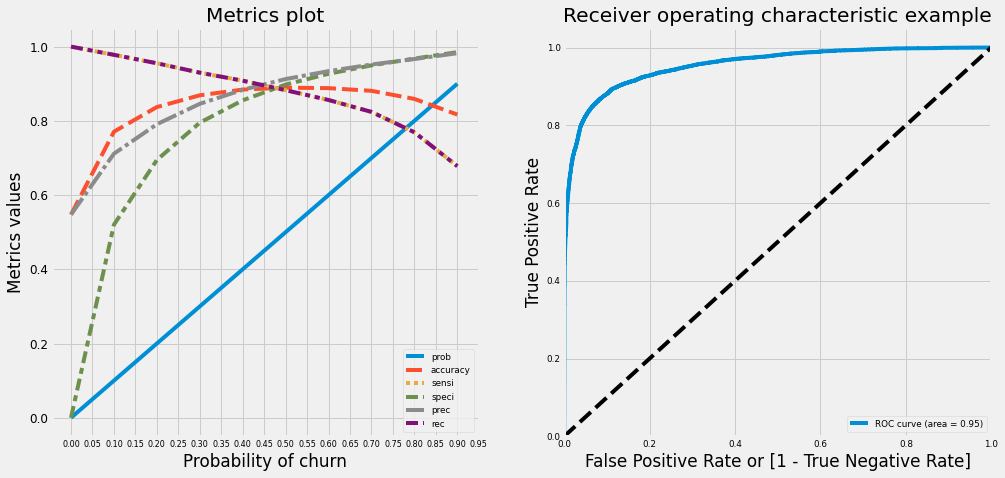

In [82]:
# Performing prediction using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_smoteen, X_train_sm_smoteen, y_train_resampled)

In [83]:
# Deciding the cutoff based on the metrics plot
cutoff = 0.46
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) # deleting the unnecessary columns of all other cutoff

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     10955
           1       0.90      0.89      0.90     13250

    accuracy                           0.89     24205
   macro avg       0.89      0.89      0.89     24205
weighted avg       0.89      0.89      0.89     24205

Accuracy Score   :  0.8903
Precision Score  :  0.9042
Recall Score     :  0.8943
F1 Score         :  0.8993
Area under curve :  0.8899 



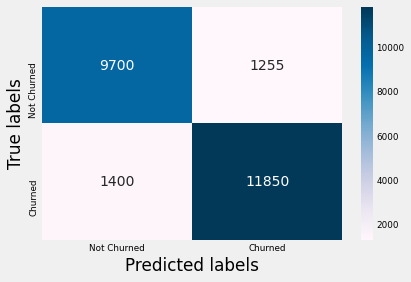

(0.8903, 0.9042, 0.8943, 0.8993, 0.8899)

In [84]:
# Evaluating the metrics on the training data set

print("Evaluation on training data set: \n")
classification_algo_metrics(y_train_resampled, y_train_pred_final['final_predicted_1'])

In [85]:
# Predicting on the test dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_smoteen, X_test[smoteen_rfe_features], y_test, cutoff=0.46) # Selecting only the columns used in final model of Train Dataset
y_test_pred_final.head()

,churn_probability,Churned_Prob,final_predicted
0,0,0.142820,0
1,0,0.069080,0
2,0,0.234190,0
3,0,0.055711,0
4,1,0.854285,1


Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89      5712
           1       0.26      0.88      0.40       452

    accuracy                           0.81      6164
   macro avg       0.62      0.84      0.64      6164
weighted avg       0.93      0.81      0.85      6164

Accuracy Score   :  0.8079
Precision Score  :  0.2598
Recall Score     :  0.8761
F1 Score         :  0.4008
Area under curve :  0.8393 



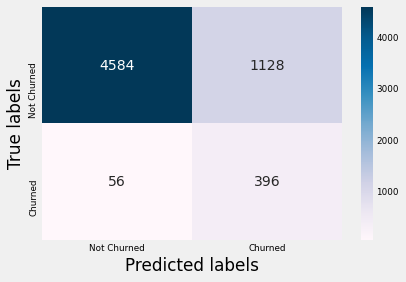

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393


In [86]:
# Evaluating the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with SMOTEEN & without PCA'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Logistic Regression With RFE and SMOTE 

In [87]:
# Runing RFE
smote_rfe_features = run_rfe_on_logistic(X_smote_samples, y_smote_samples, no_of_features=25)
X_train_rfe_smote = X_smote_samples[smote_rfe_features]
X_train_rfe_smote.shape

(26600, 25)

In [88]:
# Building  logistic model using RFE selected columns and StatsModels 
logistic_model_smote, X_train_sm_smote = build_logistic_model(X_train_rfe_smote, y_smote_samples)
logistic_model_smote.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                26600
Model:                            GLM   Df Residuals:                    26574
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 20 Jul 2022   Deviance:                          nan
Time:                        00:02:25   Pearson chi2:                 3.85e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -0.1264      0.099     -1.273      0.203      -0.321       0.068
night_pck_user_6                    -1.4326      0.325     -4.412      0.000      -2.069      -0.796
night_pck_user_7                    -1.1503      0.350     -3.290      0.001      -1.836      -0.465
night_pck_user_8                    -0.5134      0.397     -1.292      0.196      -1.292       0.265
fb_user_6                           -1.0992      0.086    -12.832      0.000      -1.267      -0.931
fb_user_7                           -0.8353      0.087     -9.643      0.000      -1.005      -0.666
fb_user_8                           -0.5883      0.098     -5.976      0.000      -0.781      -0.395
roam_ic_mou_good_phase              14.5986      6.957      2.099      0.036       0.964      28.233
roam_og_mou_action_phase             0.6835      0.018     38.388      0.000       0.649       0.718
std_og_mou_action_phase              0.3727      0.030     12.228      0.000       0.313       0.432
total_og_mou_good_phase             -0.4063      0.038    -10.702      0.000      -0.481      -0.332
loc_ic_mou_good_phase               -0.9744      0.888     -1.098      0.272      -2.714       0.766
spl_ic_mou_action_phase             -0.3697      0.027    -13.550      0.000      -0.423      -0.316
total_ic_mou_good_phase              0.5047      0.040     12.726      0.000       0.427       0.582
total_ic_mou_action_phase           -1.2918      0.041    -31.187      0.000      -1.373      -1.211
total_rech_amt_good_phase            0.7801      0.040     19.592      0.000       0.702       0.858
total_rech_amt_action_phase         -1.1421      0.044    -25.691      0.000      -1.229      -1.055
max_rech_amt_good_phase             -0.4261      0.032    -13.362      0.000      -0.489      -0.364
max_rech_amt_action_phase            0.5780      0.037     15.819      0.000       0.506       0.650
total_rech_data_action_phase         1.2855      0.140      9.208      0.000       1.012       1.559
max_rech_data_good_phase             0.4344      0.057      7.668      0.000       0.323       0.545
max_rech_data_action_phase           0.3488      0.107      3.259      0.001       0.139       0.559
vol_2g_mb_good_phase                 0.6175      0.048     12.781      0.000       0.523       0.712
vol_3g_mb_good_phase                 0.2697      0.038      7.144      0.000       0.196       0.344
monthly_2g_good_phase               -0.3156      0.029    -10.910      0.000      -0.372      -0.259
total_data_rech_amt_action_phase    -2.0577      0.227     -9.065      0.000      -2.503      -1.613
====================================================================================================
"""

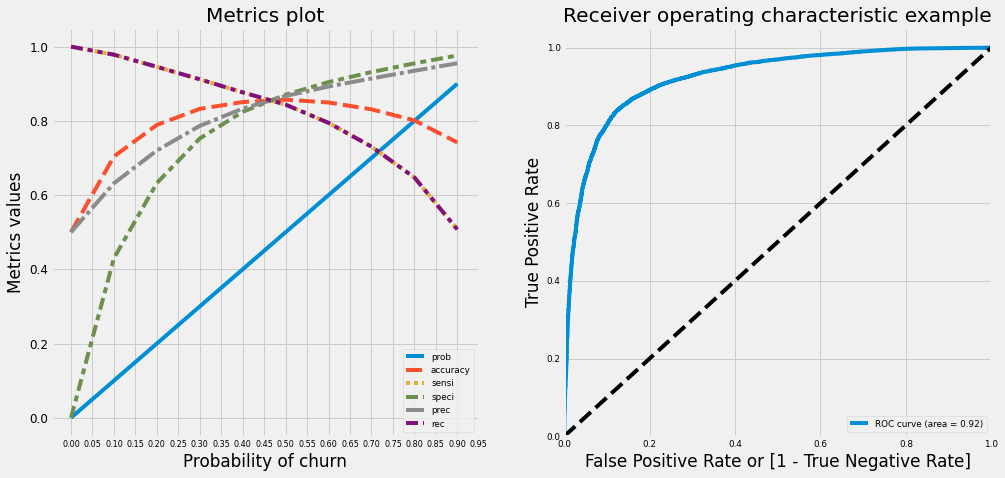

In [89]:
# Predicting using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_smote, X_train_sm_smote, y_smote_samples)

In [90]:
# Deciding the cutoff based on the metrics plot
cutoff = 0.45
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) # deleting the unnecessary columns of all other cutoff

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85     13300
           1       0.85      0.86      0.86     13300

    accuracy                           0.85     26600
   macro avg       0.85      0.85      0.85     26600
weighted avg       0.85      0.85      0.85     26600

Accuracy Score   :  0.8549
Precision Score  :  0.8509
Recall Score     :  0.8606
F1 Score         :  0.8557
Area under curve :  0.8549 



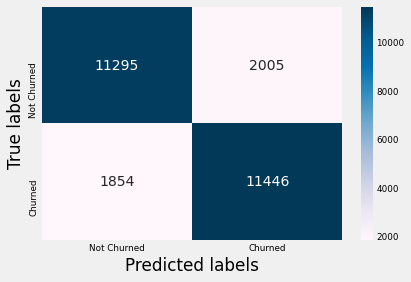

(0.8549, 0.8509, 0.8606, 0.8557, 0.8549)

In [91]:
# Evaluating the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_smote_samples, y_train_pred_final['final_predicted_1'])

In [92]:
# Predicting on the test dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_smote, X_test[smote_rfe_features], y_test, cutoff=0.46) # Selecting only the columns used in final model of Train Dataset
y_test_pred_final.head()

,churn_probability,Churned_Prob,final_predicted
0,0,0.089205,0
1,0,0.063634,0
2,0,0.223350,0
3,0,0.072842,0
4,1,0.614594,1


Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      5712
           1       0.30      0.81      0.44       452

    accuracy                           0.85      6164
   macro avg       0.64      0.83      0.68      6164
weighted avg       0.93      0.85      0.88      6164

Accuracy Score   :  0.8503
Precision Score  :  0.3049
Recall Score     :  0.8142
F1 Score         :  0.4436
Area under curve :  0.8336 



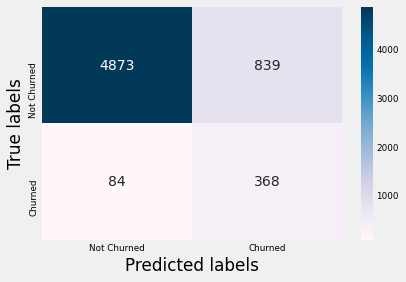

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336


In [93]:
# Evaluating the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with SMOTE & without PCA'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Logistic Regression With PCA and Random Oversampling

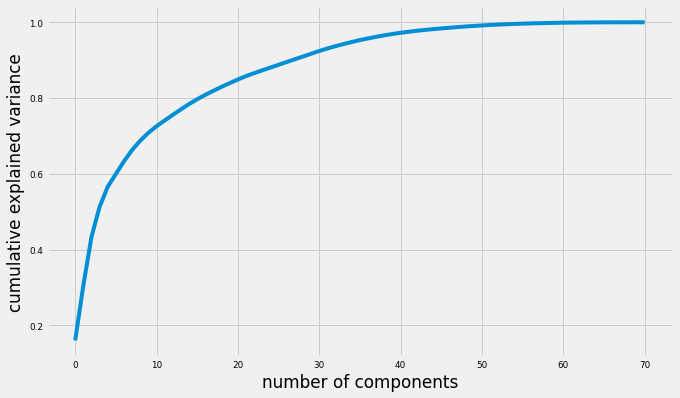

In [94]:
# Performing PCA on the training dataset to identify number of features that are important
perform_PCA(X_r_over_sampled)

Shape of X train PCA :  (26600, 25)
Shape of Y train PCA :  (26600, 1)
Shape of X test PCA :  (6164, 25)
Shape of Y test PCA :  (6164, 1)


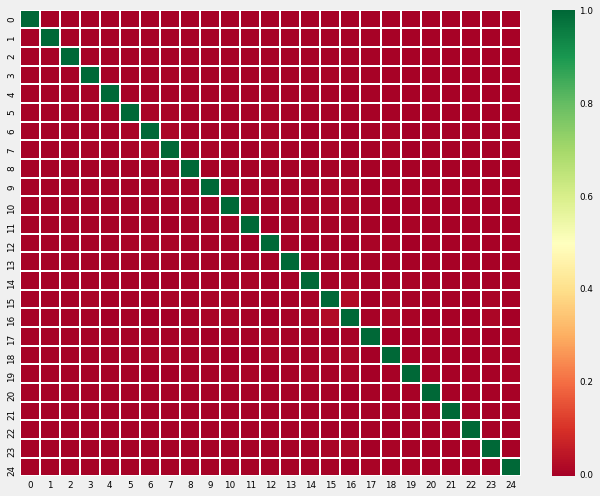

max corr: 0.01893867231032705 , min corr:  -0.006459293068635299


In [95]:
# Creating 25 Principal components
X_train_pca_ro, X_test_pca_ro = perform_incremental_PCA(X_r_over_sampled, y_r_over_sampled, 25)

In [96]:
# Building logistic model using PCA Components and StatsModels 
logistic_model_pca_r_over_balanced, X_train_sm_pca_r_over_balanced = build_logistic_model(X_train_pca_ro, y_r_over_sampled.values.ravel())
logistic_model_pca_r_over_balanced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                26600
Model:                            GLM   Df Residuals:                    26574
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 20 Jul 2022   Deviance:                          nan
Time:                        00:02:32   Pearson chi2:                 2.93e+19
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.783e+14   4.11e+05   6.76e+08      0.000    2.78e+14    2.78e+14
0           3.673e+13   1.19e+05   3.08e+08      0.000    3.67e+13    3.67e+13
1          -9.457e+13   1.26e+05  -7.52e+08      0.000   -9.46e+13   -9.46e+13
2          -2.276e+14   1.33e+05  -1.71e+09      0.000   -2.28e+14   -2.28e+14
3           5.943e+13   1.69e+05   3.51e+08      0.000    5.94e+13    5.94e+13
4           3.343e+13   2.08e+05   1.61e+08      0.000    3.34e+13    3.34e+13
5          -2.588e+13   2.59e+05  -9.97e+07      0.000   -2.59e+13   -2.59e+13
6           8.107e+13   2.61e+05    3.1e+08      0.000    8.11e+13    8.11e+13
7          -1.806e+14   2.77e+05  -6.52e+08      0.000   -1.81e+14   -1.81e+14
8           6.773e+13   3.05e+05   2.22e+08      0.000    6.77e+13    6.77e+13
9          -1.058e+14   3.32e+05  -3.19e+08      0.000   -1.06e+14   -1.06e+14
10         -9.813e+13   3.65e+05  -2.69e+08      0.000   -9.81e+13   -9.81e+13
11         -2.073e+14   3.88e+05  -5.34e+08      0.000   -2.07e+14   -2.07e+14
12         -2.191e+14   3.95e+05  -5.55e+08      0.000   -2.19e+14   -2.19e+14
13         -2.329e+14   3.96e+05  -5.88e+08      0.000   -2.33e+14   -2.33e+14
14          2.035e+14   4.04e+05   5.04e+08      0.000    2.04e+14    2.04e+14
15         -1.559e+14    4.3e+05  -3.63e+08      0.000   -1.56e+14   -1.56e+14
16         -1.226e+14   4.59e+05  -2.67e+08      0.000   -1.23e+14   -1.23e+14
17          -5.15e+13   4.71e+05  -1.09e+08      0.000   -5.15e+13   -5.15e+13
18          2.516e+14    5.5e+05   4.57e+08      0.000    2.52e+14    2.52e+14
19         -4.078e+14   5.55e+05  -7.34e+08      0.000   -4.08e+14   -4.08e+14
20           -5.4e+14   5.59e+05  -9.66e+08      0.000    -5.4e+14    -5.4e+14
21         -6.184e+13   5.59e+05  -1.11e+08      0.000   -6.18e+13   -6.18e+13
22         -5.175e+14   5.59e+05  -9.26e+08      0.000   -5.18e+14   -5.18e+14
23         -2.658e+14   5.59e+05  -4.75e+08      0.000   -2.66e+14   -2.66e+14
24          6.125e+13   5.59e+05    1.1e+08      0.000    6.12e+13    6.12e+13
==============================================================================
"""

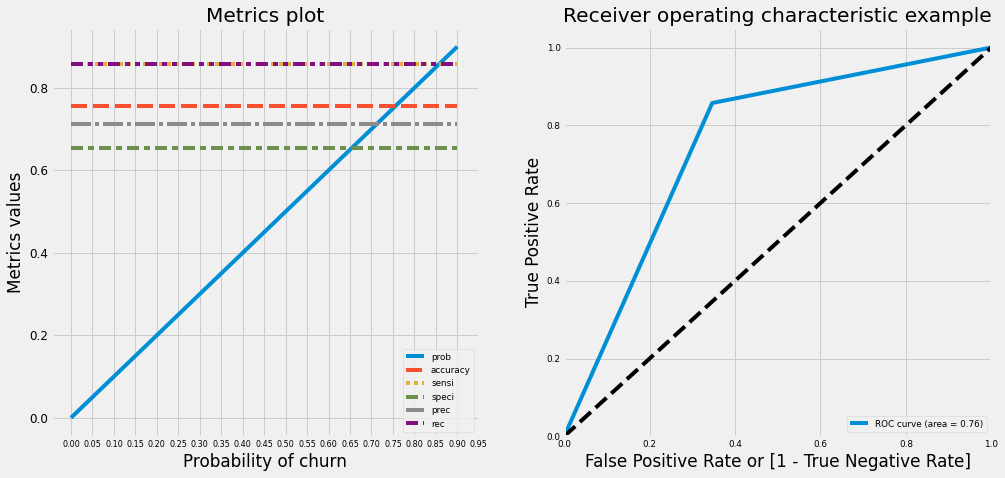

In [97]:
# Predicting using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_pca_r_over_balanced, X_train_sm_pca_r_over_balanced, y_r_over_sampled)

In [98]:
# Deciding the cutoff based on the metrics plot
cutoff = 0.45 
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) # deleting the unnecessary columns of all other cutoff

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.65      0.73     13300
           1       0.71      0.86      0.78     13300

    accuracy                           0.76     26600
   macro avg       0.77      0.76      0.75     26600
weighted avg       0.77      0.76      0.75     26600

Accuracy Score   :  0.7553
Precision Score  :  0.7121
Recall Score     :  0.8572
F1 Score         :  0.778
Area under curve :  0.7553 



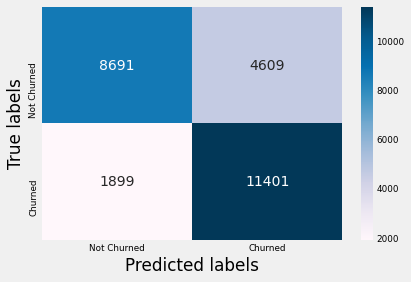

(0.7553, 0.7121, 0.8572, 0.778, 0.7553)

In [99]:
# Evaluating the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_r_over_sampled, y_train_pred_final['final_predicted_1'])

In [100]:
# Predicting on the test dataset
# Selecting only the columns used in final model of Train Dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_pca_r_over_balanced, X_test_pca_ro, y_test, cutoff=0.45) 
y_test_pred_final.head()

,churn_probability,Churned_Prob,final_predicted
0,0,0.0,0
1,0,0.0,0
2,0,1.0,1
3,0,0.0,0
4,1,1.0,1


Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.66      0.79      5712
           1       0.17      0.86      0.28       452

    accuracy                           0.67      6164
   macro avg       0.57      0.76      0.53      6164
weighted avg       0.92      0.67      0.75      6164

Accuracy Score   :  0.6723
Precision Score  :  0.1661
Recall Score     :  0.8628
F1 Score         :  0.2786
Area under curve :  0.76 



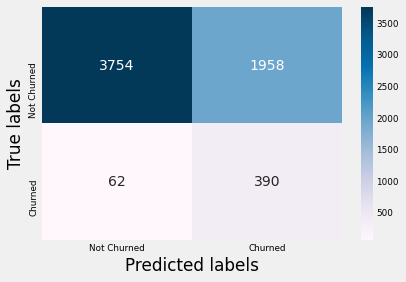

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600


In [101]:
# Evaluating the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA & Random over sampling'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision], 
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Logistic Regression With PCA and Random Undersampling

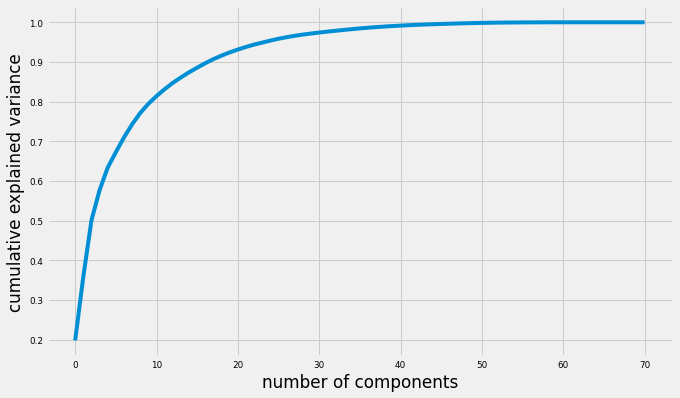

In [102]:
# Performing PCA on the training dataset to identify number of features that are important
perform_PCA(X_r_under_sampled)

Shape of X train PCA :  (2164, 15)
Shape of Y train PCA :  (2164, 1)
Shape of X test PCA :  (6164, 15)
Shape of Y test PCA :  (6164, 1)


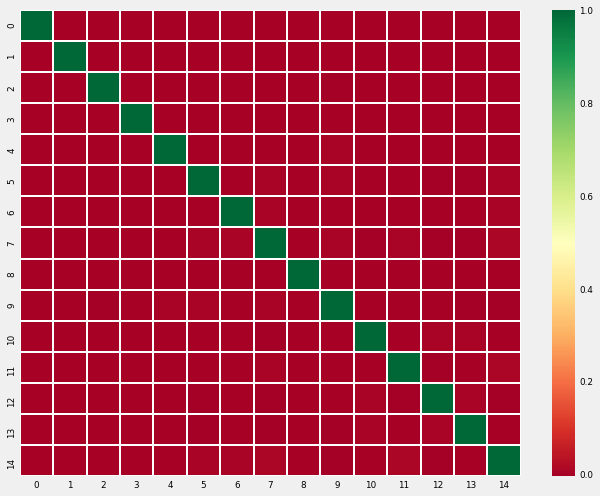

max corr: 0.00855771394950754 , min corr:  -0.005787380303137478


In [103]:
X_train_pca_ru, X_test_pca_run = perform_incremental_PCA(X_r_under_sampled, y_r_under_sampled, 15)

In [104]:
# Building logistic model using PCA Components with StatsModels 
logistic_model_pca_under_sampled, X_train_sm_pca_under_sampled = build_logistic_model(X_train_pca_ru, y_r_under_sampled.values.ravel())

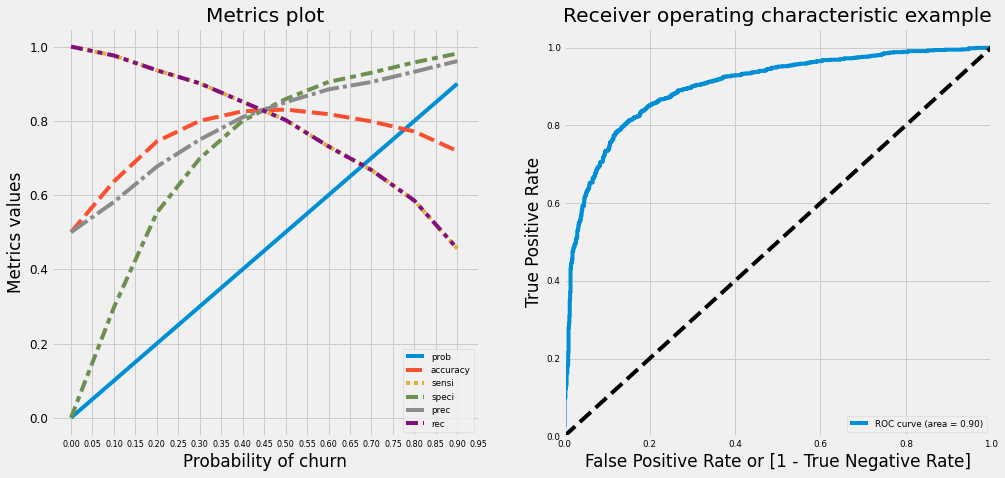

In [105]:
# Predicting using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_pca_under_sampled, X_train_sm_pca_under_sampled, y_r_under_sampled)

In [106]:
# Deciding the cutoff based on the metrics plot
cutoff = 0.45 
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
# deleting the unnecessary columns of all other cutoff
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) 

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83      1082
           1       0.83      0.82      0.83      1082

    accuracy                           0.83      2164
   macro avg       0.83      0.83      0.83      2164
weighted avg       0.83      0.83      0.83      2164

Accuracy Score   :  0.8267
Precision Score  :  0.8307
Recall Score     :  0.8207
F1 Score         :  0.8257
Area under curve :  0.8267 



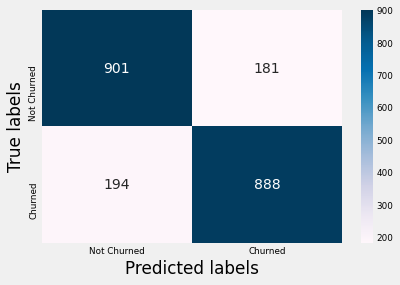

(0.8267, 0.8307, 0.8207, 0.8257, 0.8267)

In [107]:
# Evaluating the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_r_under_sampled, y_train_pred_final['final_predicted_1'])

In [108]:
# Predicting on the test dataset
# Selecting only the columns used in final model of Train Dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_pca_under_sampled, X_test_pca_run, y_test, cutoff=0.45) 
y_test_pred_final.head()

,churn_probability,Churned_Prob,final_predicted
0,0,0.223800,0
1,0,0.123273,0
2,0,0.273728,0
3,0,0.099455,0
4,1,0.681412,1


Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      5712
           1       0.26      0.82      0.40       452

    accuracy                           0.82      6164
   macro avg       0.62      0.82      0.65      6164
weighted avg       0.93      0.82      0.86      6164

Accuracy Score   :  0.8201
Precision Score  :  0.2645
Recall Score     :  0.8164
F1 Score         :  0.3996
Area under curve :  0.8184 



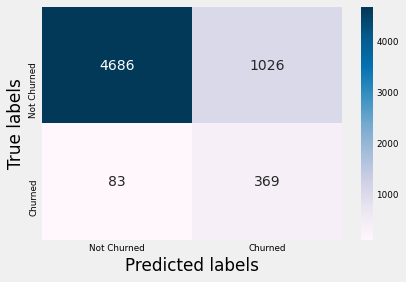

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184


In [109]:
# Evaluating the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA & Random under sampling'],
                            'Accuracy': [accuracy],
                            'Precision': [precision], 
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Logistic Regression With PCA and SMOTE Oversampling

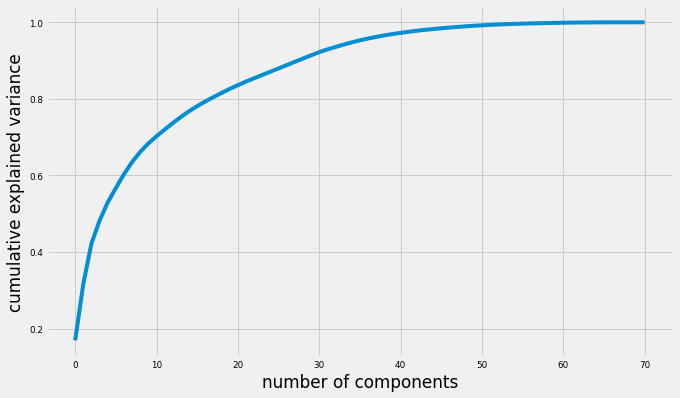

In [110]:
# Performing PCA on the training dataset to identify number of features that are important
perform_PCA(X_smote_samples)

In [111]:
X_train.shape

(14382, 71)

Shape of X train PCA :  (26600, 25)
Shape of Y train PCA :  (26600, 1)
Shape of X test PCA :  (6164, 25)
Shape of Y test PCA :  (6164, 1)


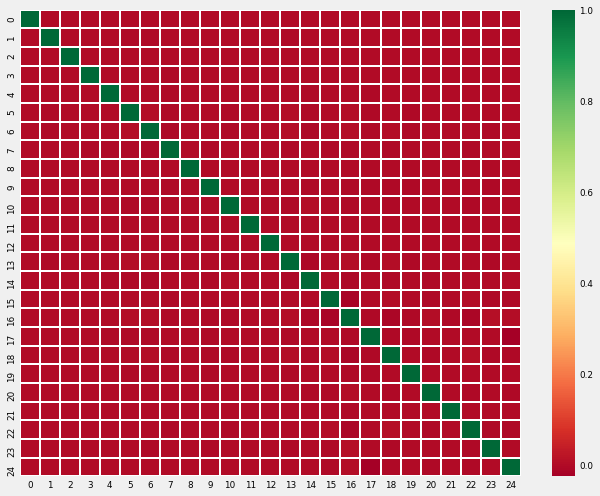

max corr: 0.009642323282938476 , min corr:  -0.024776006000332917


In [112]:
# Creating 25 Principal components
X_train_pca_smote, X_test_pca_smote = perform_incremental_PCA(X_smote_samples, y_smote_samples, 25)

In [113]:
# Building the logistic model using PCA Components with StatsModels 
logistic_model_pca_smote, X_train_sm_pca_smote = build_logistic_model(X_train_pca_smote, y_smote_samples.values.ravel())

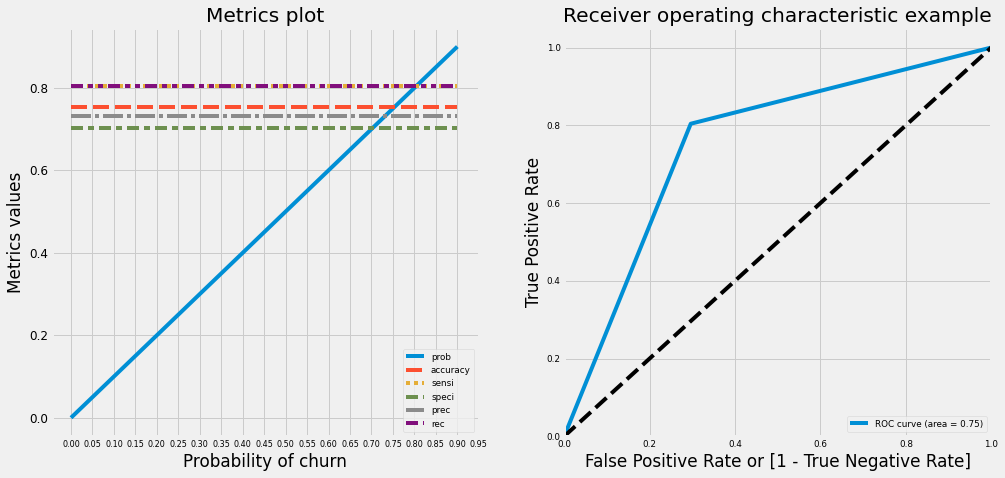

In [114]:
# Predicting using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_pca_smote, X_train_sm_pca_smote, y_smote_samples)

In [115]:
# Deciding the cutoff based on the metrics plot
cutoff = 0.45 
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
# Dropping the unnecessary columns of all other cutoff
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) 

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74     13300
           1       0.73      0.80      0.77     13300

    accuracy                           0.75     26600
   macro avg       0.76      0.75      0.75     26600
weighted avg       0.76      0.75      0.75     26600

Accuracy Score   :  0.7538
Precision Score  :  0.7307
Recall Score     :  0.8039
F1 Score         :  0.7655
Area under curve :  0.7538 



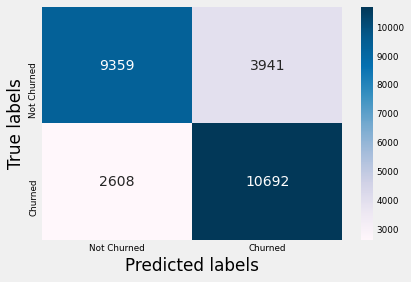

(0.7538, 0.7307, 0.8039, 0.7655, 0.7538)

In [116]:
# Evaluating the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_smote_samples, y_train_pred_final['final_predicted_1'])

In [117]:
# Predicting on the test dataset
# Using only the columns used in final model of Train Dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_pca_smote, X_test_pca_smote, y_test, cutoff=0.45) 
y_test_pred_final.head()

,churn_probability,Churned_Prob,final_predicted
0,0,0.0,0
1,0,0.0,0
2,0,0.0,0
3,0,0.0,0
4,1,1.0,1


Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.70      0.81      5712
           1       0.17      0.80      0.28       452

    accuracy                           0.71      6164
   macro avg       0.58      0.75      0.55      6164
weighted avg       0.92      0.71      0.78      6164

Accuracy Score   :  0.7054
Precision Score  :  0.1727
Recall Score     :  0.7965
F1 Score         :  0.2839
Area under curve :  0.7473 



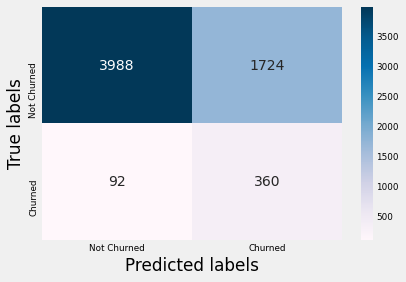

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473


In [118]:
# Evaluating the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA & SMOTE'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall],
                            'F1 score': [f1],
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Logistic Regression with PCA and SMOTEEN Resampling

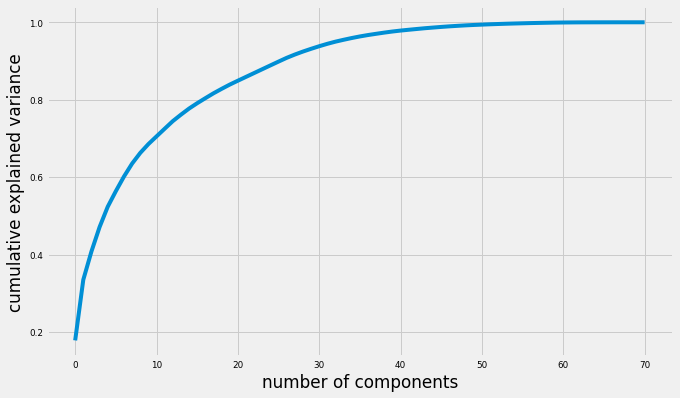

In [119]:
# Performing PCA on the training dataset to identify number of features are important
perform_PCA(X_train_resampled)

Shape of X train PCA :  (24205, 25)
Shape of Y train PCA :  (24205, 1)
Shape of X test PCA :  (6164, 25)
Shape of Y test PCA :  (6164, 1)


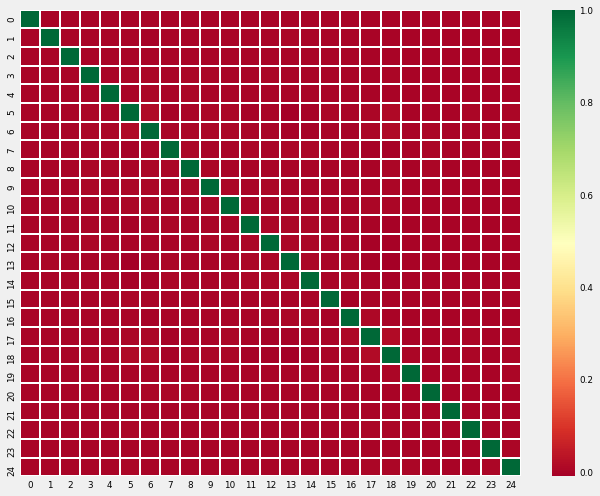

max corr: 0.013184905930099565 , min corr:  -0.010973267153443628


In [120]:
# Creating 25 Principal components
X_train_pca_smoteen, X_test_pca_smoteen = perform_incremental_PCA(X_train_resampled, y_train_resampled, 25)
X_train_pca_smoteen, X_test_pca_smoteen = perform_incremental_PCA(X_train_resampled, y_train_resampled, 25)

In [121]:
# Building the logistic model using PCA Components with StatsModels 
logistic_model_pca_smoteen, X_train_sm_pca_smoteen = build_logistic_model(X_train_pca_smoteen, y_train_resampled.values.ravel())

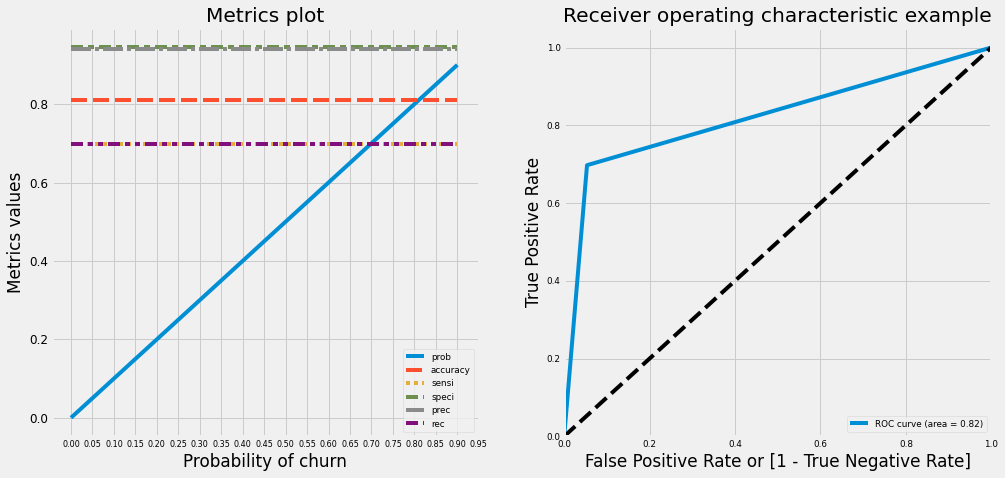

In [122]:
# Predicting using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_pca_smoteen, X_train_sm_pca_smoteen, y_train_resampled)

In [123]:
# Deciding the cutoff based on the metrics plot
cutoff = 0.46
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
# deleting the unnecessary columns of all other cutoff
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.72      0.95      0.82     10955
           1       0.94      0.70      0.80     13250

    accuracy                           0.81     24205
   macro avg       0.83      0.82      0.81     24205
weighted avg       0.84      0.81      0.81     24205

Accuracy Score   :  0.8101
Precision Score  :  0.9405
Recall Score     :  0.6973
F1 Score         :  0.8008
Area under curve :  0.8219 



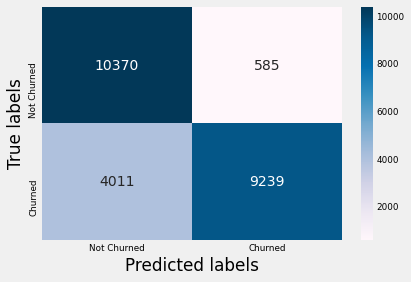

(0.8101, 0.9405, 0.6973, 0.8008, 0.8219)

In [124]:
# Evaluating the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train_resampled, y_train_pred_final['final_predicted_1'])

In [125]:
# Predicting on the test dataset
# Using only the columns used in final model of Train Dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_pca_smoteen, X_test_pca_smoteen, y_test, cutoff=0.46) 
y_test_pred_final.head()

,churn_probability,Churned_Prob,final_predicted
0,0,0.0,0
1,0,0.0,0
2,0,0.0,0
3,0,0.0,0
4,1,0.0,0


Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      5712
           1       0.32      0.68      0.44       452

    accuracy                           0.87      6164
   macro avg       0.65      0.78      0.68      6164
weighted avg       0.92      0.87      0.89      6164

Accuracy Score   :  0.8722
Precision Score  :  0.3228
Recall Score     :  0.677
F1 Score         :  0.4371
Area under curve :  0.7823 



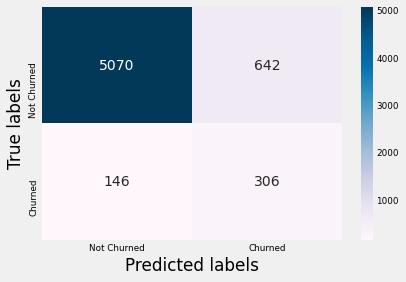

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473
0,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823


In [126]:
# Evaluating the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA & SMOTEENN'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision], 
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Logistic Regression With PCA, SMOTEEN and L2 Regularization

Shape of X train PCA :  (24205, 25)
Shape of Y train PCA :  (24205, 1)
Shape of X test PCA :  (6164, 25)
Shape of Y test PCA :  (6164, 1)


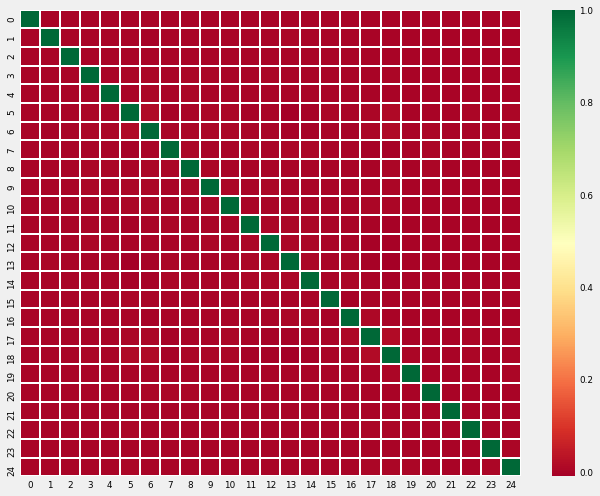

max corr: 0.013184905930099565 , min corr:  -0.010973267153443628


In [127]:
# Creating 25 principal components
X_train_pca_reg, X_test_pca_reg = perform_incremental_PCA(X_train_resampled, y_train_resampled, 25)

In [128]:
# Hyper parameter tuning: Decide whether to apply l1 or l2 penalty using GridSearchCV
lr = LogisticRegression(n_jobs = -1, random_state = 100)
parameter = 'penalty'
param_grid = {parameter: ['l1', 'l2']} # parameters to build the model on

gc = GridSearchCV(estimator = lr, param_grid = param_grid, scoring = 'roc_auc', n_jobs = 15, cv = 5, verbose = 2)
gc = gc.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# scores of GridSearch CV
scores = gc.cv_results_    

# Get the best value
gc.best_params_


Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'penalty': 'l2'}

Fitting 5 folds for each of 4 candidates, totalling 20 fits


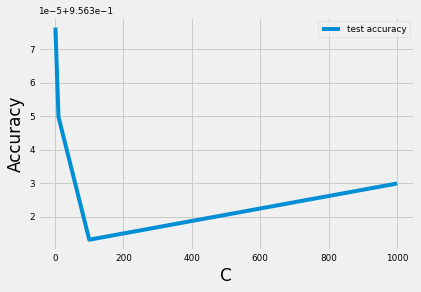

{'C': 1}

In [129]:
# Hyper parameter tuning: Decide penalty value of 'c' for L2 regularization
lr = LogisticRegression(penalty = 'l2', n_jobs = -1, random_state = 100)
parameter = 'C'
param_grid = {parameter: [1, 10, 100, 1000]} # parameters to build the model on

gc = GridSearchCV(estimator = lr, param_grid = param_grid, scoring = 'roc_auc', n_jobs = 15, cv = 5, verbose = 2)
gc = gc.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
col = "param_" + parameter
    
#plt.plot(scores[col], scores["mean_train_score"], label = "training accuracy")
plt.plot(scores[col], scores["mean_test_score"], label = "test accuracy")

plt.xlabel(parameter)
plt.ylabel("Accuracy")

plt.legend()
plt.show()

# Get the best value
gc.best_params_

In [130]:
# Building logistic model with regularization penalty and Principal components

lr = LogisticRegression(penalty = 'l2', C = 1, n_jobs = -1, random_state = 100)
logistic_model_pca_smoteen_reg = lr.fit(X_train_pca_reg.values, y_train_resampled.values.ravel())

In [131]:
# Predicting using the training data
y_train_pred_final = logistic_model_pca_smoteen_reg.predict(X_train_pca_reg.values)
y_train_pred_final

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87     10955
           1       0.90      0.87      0.89     13250

    accuracy                           0.88     24205
   macro avg       0.88      0.88      0.88     24205
weighted avg       0.88      0.88      0.88     24205

Accuracy Score   :  0.881
Precision Score  :  0.9049
Recall Score     :  0.8746
F1 Score         :  0.8895
Area under curve :  0.8817 



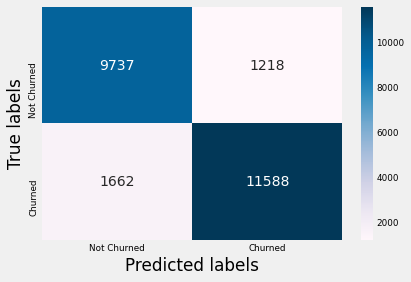

(0.881, 0.9049, 0.8746, 0.8895, 0.8817)

In [132]:
# Evaluating the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train_resampled, y_train_pred_final)

In [133]:
# Predicting on the test dataset
y_test_pred_final = logistic_model_pca_smoteen_reg.predict(X_test_pca_reg.values)
y_test_pred_final

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.88      5712
           1       0.25      0.85      0.39       452

    accuracy                           0.81      6164
   macro avg       0.62      0.83      0.64      6164
weighted avg       0.93      0.81      0.85      6164

Accuracy Score   :  0.8065
Precision Score  :  0.2541
Recall Score     :  0.8473
F1 Score         :  0.391
Area under curve :  0.8253 



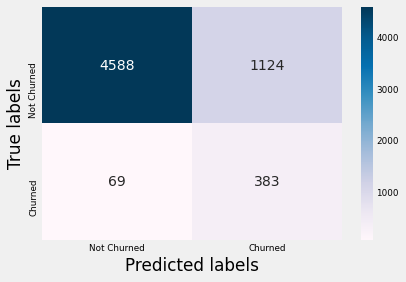

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473
0,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823
0,"Logistic Regression with PCA, SMOTEEN, L2 regu...",0.8065,0.2541,0.8473,0.3910,0.8253


In [134]:
# Evaluating the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final)

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA, SMOTEEN, L2 regularization'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision], 
                            'Recall': [recall], 
                            'F1 score': [f1],
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Support Vector Machine With Hyperparameter Tuning and SMOTEEN

In [135]:
# Hyper parameter tuning for Support Vector Machine
%%time
params = { 'C' :[0.1,0.3,0.5],
          'gamma':[0.3,0.5,0.7]
         }


g_search_svm = GridSearchCV(estimator = SVC(), scoring = 'accuracy', cv=3,
                                                         param_grid = params)
g_search_svm.fit(X_train_resampled,y_train_resampled)
print("SVM Best Score : " ,g_search_svm.best_score_)
print("SVM Best Params : " ,g_search_svm.best_params_)

SVM Best Score :  0.9825244049121116
SVM Best Params :  {'C': 0.5, 'gamma': 0.3}
Wall time: 30min 14s


In [136]:
# Creating a new model for SVM with hyperparameter tuning process selected best parameters 
model_svm = SVC(C = 0.5,gamma = 0.3,kernel = 'linear', probability = True, )
model_svm.fit(X_train_resampled,y_train_resampled)

SVC(C=0.5, gamma=0.3, kernel='linear', probability=True)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     13300
           1       0.29      0.86      0.44      1082

    accuracy                           0.83     14382
   macro avg       0.64      0.84      0.67     14382
weighted avg       0.93      0.83      0.87     14382

Accuracy Score   :  0.8327
Precision Score  :  0.2918
Recall Score     :  0.8577
F1 Score         :  0.4355
Area under curve :  0.8442 



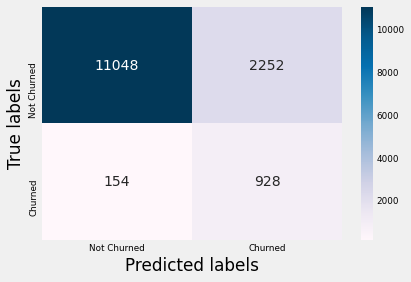

(0.8327, 0.2918, 0.8577, 0.4355, 0.8442)

In [137]:
# Checking the performance on the train dataset
y_train_svm = model_svm.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_svm)

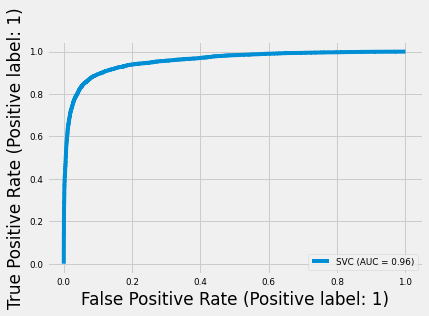

In [138]:
# Plotting the AUC ROC Curve
plot_roc_curve(model_svm, X_train_resampled,y_train_resampled)
plt.show()


Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      5712
           1       0.28      0.85      0.42       452

    accuracy                           0.83      6164
   macro avg       0.63      0.84      0.66      6164
weighted avg       0.93      0.83      0.86      6164

Accuracy Score   :  0.829
Precision Score  :  0.2806
Recall Score     :  0.8518
F1 Score         :  0.4221
Area under curve :  0.8395 



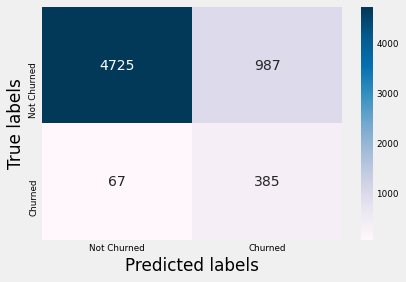

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473
0,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823
0,"Logistic Regression with PCA, SMOTEEN, L2 regu...",0.8065,0.2541,0.8473,0.3910,0.8253
0,SVM with SMOTEENN,0.8290,0.2806,0.8518,0.4221,0.8395


In [139]:
# Evaluating the model on the test data set

y_test_svm = model_svm.predict(X_test)
print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_svm)

tempResults = pd.DataFrame({'Model':['SVM with SMOTEENN'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Random Forest With Imbalanced Data and Class Weights

In [140]:
# Running RandomForestClassifier without hyper parameter tuning with the actual train and test data data
model_rf = RandomForestClassifier(random_state = 100, n_estimators= 100,n_jobs =-1, class_weight = {0:1,1:9})
model_rf.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 9}, n_jobs=-1, random_state=100)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13300
           1       1.00      1.00      1.00      1082

    accuracy                           1.00     14382
   macro avg       1.00      1.00      1.00     14382
weighted avg       1.00      1.00      1.00     14382

Accuracy Score   :  1.0
Precision Score  :  1.0
Recall Score     :  1.0
F1 Score         :  1.0
Area under curve :  1.0 



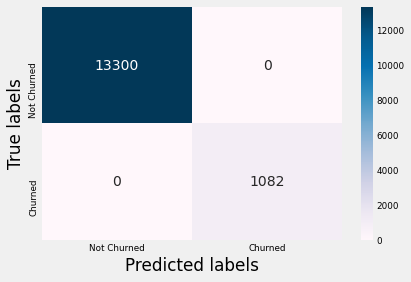

(1.0, 1.0, 1.0, 1.0, 1.0)

In [141]:
# Observing the performance of the model of the train dataset
y_train_rf = model_rf.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_rf)

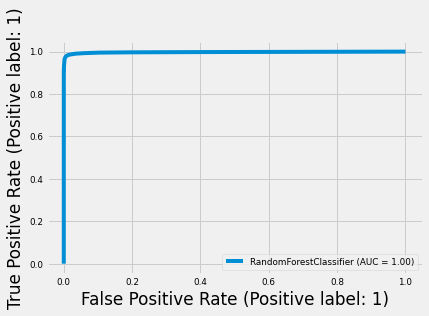

In [142]:
#Plotting the AUC ROC Curve
plot_roc_curve(model_rf, X_train_resampled,y_train_resampled)
plt.show()

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      5712
           1       0.73      0.39      0.51       452

    accuracy                           0.94      6164
   macro avg       0.84      0.69      0.74      6164
weighted avg       0.94      0.94      0.94      6164

Accuracy Score   :  0.9448
Precision Score  :  0.7333
Recall Score     :  0.3894
F1 Score         :  0.5087
Area under curve :  0.6891 



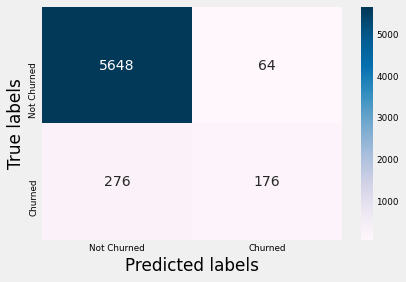

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473
0,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823
0,"Logistic Regression with PCA, SMOTEEN, L2 regu...",0.8065,0.2541,0.8473,0.3910,0.8253
0,SVM with SMOTEENN,0.8290,0.2806,0.8518,0.4221,0.8395
0,Random Forest with class_weight,0.9448,0.7333,0.3894,0.5087,0.6891


In [143]:
# Observing the model performance on the test dataset
y_test_rf = model_rf.predict(X_test)

print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_rf)

tempResults = pd.DataFrame({'Model':['Random Forest with class_weight'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Random Forest With SMOTEEN 

In [144]:
# Executing RandomForestClassifier without hyper parameter tuning with the resampled data
model_rf = RandomForestClassifier(random_state = 100, n_estimators= 100,n_jobs =-1)
model_rf.fit(X_train_resampled,y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=100)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     13300
           1       0.57      1.00      0.73      1082

    accuracy                           0.94     14382
   macro avg       0.79      0.97      0.85     14382
weighted avg       0.97      0.94      0.95     14382

Accuracy Score   :  0.9438
Precision Score  :  0.5725
Recall Score     :  1.0
F1 Score         :  0.7281
Area under curve :  0.9696 



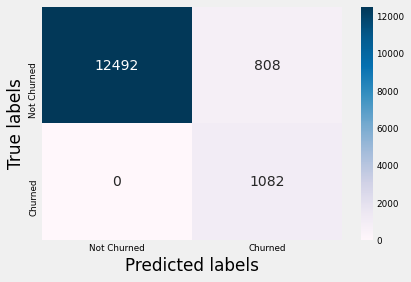

(0.9438, 0.5725, 1.0, 0.7281, 0.9696)

In [145]:
# Obseving the performance of the train dataset
y_train_rf = model_rf.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_rf)

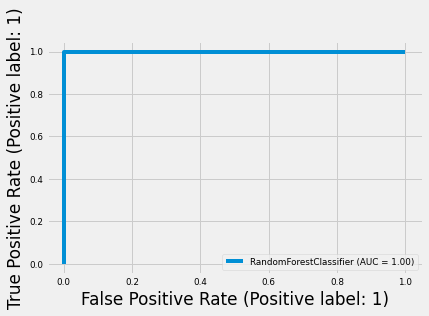

In [146]:
# Plotting the AUC ROC Curve
plot_roc_curve(model_rf, X_train_resampled,y_train_resampled)
plt.show()


Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      5712
           1       0.44      0.75      0.55       452

    accuracy                           0.91      6164
   macro avg       0.71      0.84      0.75      6164
weighted avg       0.94      0.91      0.92      6164

Accuracy Score   :  0.9108
Precision Score  :  0.4369
Recall Score     :  0.75
F1 Score         :  0.5521
Area under curve :  0.8367 



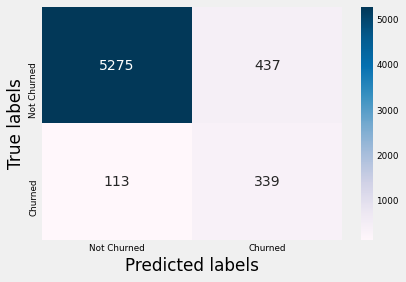

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473
0,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823
0,"Logistic Regression with PCA, SMOTEEN, L2 regu...",0.8065,0.2541,0.8473,0.3910,0.8253
0,SVM with SMOTEENN,0.8290,0.2806,0.8518,0.4221,0.8395
0,Random Forest with class_weight,0.9448,0.7333,0.3894,0.5087,0.6891
0,Random Forest with SMOTEENN,0.9108,0.4369,0.7500,0.5521,0.8367


In [147]:
# Checking the model performance on the test dataset
y_test_rf = model_rf.predict(X_test)
print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_rf)

tempResults = pd.DataFrame({'Model':['Random Forest with SMOTEENN'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Random Forest With SMOTEEN and Hyperparameter tuning

In [148]:
#Performing hyperparametertuning for RandomForest and try to find best parameters to improve the precision and recall score : 
params = { 'n_estimators':[500,1000],
          'max_features': ['auto','sqrt'] ,
          'max_depth' : [10,20,30] , 
          'min_samples_leaf':[50,100,150],
          'min_samples_split':[100,150,200],
          'criterion':['gini','entropy']
         }
g_search_rf = GridSearchCV(estimator = RandomForestClassifier(random_state = 100,n_jobs = -1), scoring = 'accuracy', cv=3,
                                                           param_grid = params)
g_search_rf.fit(X_train_resampled,y_train_resampled)
print("Random Forest Best Score : " ,g_search_rf.best_score_)
print("Random Forest Best Params : " ,g_search_rf.best_params_)


Random Forest Best Score :  0.9212562952991856
Random Forest Best Params :  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 500}


In [149]:
# Building the model with hyperparameters
model_rf = RandomForestClassifier(random_state = 100, n_jobs =-1,
                                  n_estimators= 500,
                                  max_depth = 20,
                                  max_features = 'auto',
                                  min_samples_leaf = 50,
                                  min_samples_split=100,
                                  criterion ='entropy')
model_rf.fit(X_train_resampled,y_train_resampled)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=50,
                       min_samples_split=100, n_estimators=500, n_jobs=-1,
                       random_state=100)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     13300
           1       0.36      0.87      0.51      1082

    accuracy                           0.88     14382
   macro avg       0.68      0.87      0.72     14382
weighted avg       0.94      0.88      0.90     14382

Accuracy Score   :  0.8757
Precision Score  :  0.3636
Recall Score     :  0.8697
F1 Score         :  0.5128
Area under curve :  0.8729 



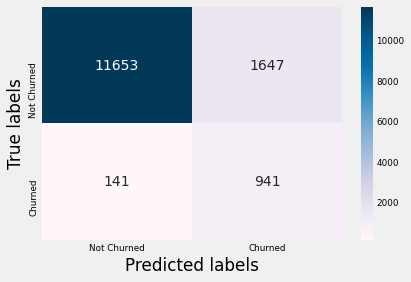

(0.8757, 0.3636, 0.8697, 0.5128, 0.8729)

In [150]:
# Observing the model performance of the train dataset
y_train_rf = model_rf.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_rf)

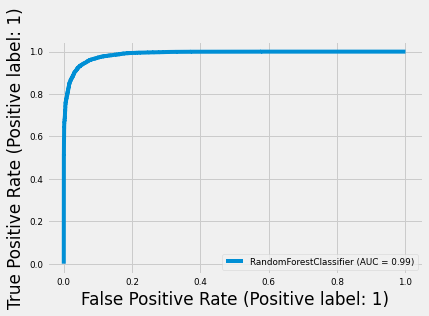

In [151]:
#Plotting the AUC ROC Curve
plot_roc_curve(model_rf, X_train_resampled,y_train_resampled)
plt.show()

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.92      5712
           1       0.32      0.83      0.46       452

    accuracy                           0.86      6164
   macro avg       0.65      0.85      0.69      6164
weighted avg       0.94      0.86      0.89      6164

Accuracy Score   :  0.8602
Precision Score  :  0.323
Recall Score     :  0.8274
F1 Score         :  0.4646
Area under curve :  0.8451 



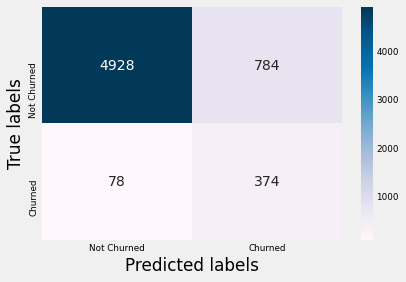

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473
0,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823
0,"Logistic Regression with PCA, SMOTEEN, L2 regu...",0.8065,0.2541,0.8473,0.3910,0.8253
0,SVM with SMOTEENN,0.8290,0.2806,0.8518,0.4221,0.8395
0,Random Forest with class_weight,0.9448,0.7333,0.3894,0.5087,0.6891
0,Random Forest with SMOTEENN,0.9108,0.4369,0.7500,0.5521,0.8367


In [152]:
# Observing the model performance on the test dataset
y_test_rf = model_rf.predict(X_test)

print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_rf)

tempResults = pd.DataFrame({'Model':['Random Forest with SMOTEENN & Hyperparameter tuned'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Adaboost With Hyperparameter Tuning and SMOTEEN

In [153]:
#  Performing hyperparametertuning for Adaboost and try to improve the accuracy :

params = { 'n_estimators':[300,500,1000],
        'learning_rate': [0.05,0.1,0.5,1]
          
         }
g_search_ada = GridSearchCV(estimator = AdaBoostClassifier(random_state = 100), scoring = 'accuracy', cv=3,
                                                          param_grid = params)
g_search_ada.fit(X_train_resampled,y_train_resampled)
print("AdaBoost Best Score : " ,g_search_ada.best_score_)
print("AdaBoost Best Params : " ,g_search_ada.best_params_)


AdaBoost Best Score :  0.9560843480230082
AdaBoost Best Params :  {'learning_rate': 1, 'n_estimators': 1000}


In [155]:
# Model Fitting with hyperparameters
model_ada = AdaBoostClassifier(random_state = 100, learning_rate=1,n_estimators = 1000)
model_ada.fit(X_train_resampled,y_train_resampled)

AdaBoostClassifier(learning_rate=1, n_estimators=1000, random_state=100)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     13300
           1       0.44      0.78      0.57      1082

    accuracy                           0.91     14382
   macro avg       0.71      0.85      0.76     14382
weighted avg       0.94      0.91      0.92     14382

Accuracy Score   :  0.91
Precision Score  :  0.4443
Recall Score     :  0.7847
F1 Score         :  0.5673
Area under curve :  0.8524 



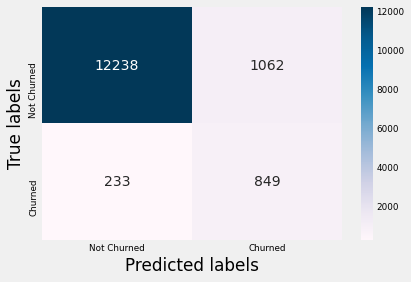

(0.91, 0.4443, 0.7847, 0.5673, 0.8524)

In [156]:
# Observing the model performance of the train dataset
y_train_ada = model_ada.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_ada)

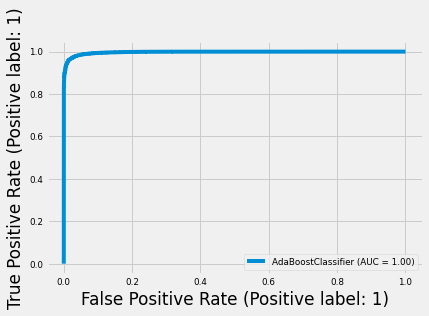

In [157]:
# Plotting the AUC ROC Curve
plot_roc_curve(model_ada, X_train_resampled,y_train_resampled)
plt.show()

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94      5712
           1       0.37      0.71      0.49       452

    accuracy                           0.89      6164
   macro avg       0.67      0.81      0.71      6164
weighted avg       0.93      0.89      0.91      6164

Accuracy Score   :  0.8903
Precision Score  :  0.371
Recall Score     :  0.7124
F1 Score         :  0.4879
Area under curve :  0.8084 



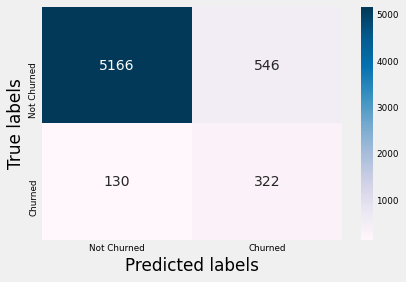

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473
0,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823
0,"Logistic Regression with PCA, SMOTEEN, L2 regu...",0.8065,0.2541,0.8473,0.3910,0.8253
0,SVM with SMOTEENN,0.8290,0.2806,0.8518,0.4221,0.8395
0,Random Forest with class_weight,0.9448,0.7333,0.3894,0.5087,0.6891
0,Random Forest with SMOTEENN,0.9108,0.4369,0.7500,0.5521,0.8367


In [158]:
# Observing the model performance on the test dataset
y_test_ada = model_ada.predict(X_test)

print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_ada)

tempResults = pd.DataFrame({'Model':['AdaBoost with SMOTEENN & Hyperparameter tuned'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### CatBoost With Hyperparameter Tuning and SMOTEEN

In [159]:
# Performing hyperparameter on Catboost for better accuracy
CBC = CatBoostClassifier() 
parameters = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }
g_search_cbc = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3, n_jobs=-1)
g_search_cbc.fit(X_train_resampled, y_train_resampled)
print("CatBoost Best Score : " ,g_search_cbc.best_score_)
print("CatBoost Best Params : " ,g_search_cbc.best_params_)

0:	learn: 0.6379267	total: 397ms	remaining: 39.3s
1:	learn: 0.5858560	total: 637ms	remaining: 31.2s
2:	learn: 0.5394678	total: 891ms	remaining: 28.8s
3:	learn: 0.5011356	total: 1.15s	remaining: 27.6s
4:	learn: 0.4669761	total: 1.41s	remaining: 26.7s
5:	learn: 0.4367324	total: 1.66s	remaining: 26s
6:	learn: 0.4133274	total: 1.92s	remaining: 25.5s
7:	learn: 0.3886161	total: 2.18s	remaining: 25.1s
8:	learn: 0.3675655	total: 2.44s	remaining: 24.7s
9:	learn: 0.3498328	total: 2.67s	remaining: 24.1s
10:	learn: 0.3332704	total: 2.95s	remaining: 23.9s
11:	learn: 0.3192545	total: 3.21s	remaining: 23.6s
12:	learn: 0.3059186	total: 3.49s	remaining: 23.3s
13:	learn: 0.2938650	total: 3.73s	remaining: 22.9s
14:	learn: 0.2817591	total: 4.01s	remaining: 22.8s
15:	learn: 0.2724425	total: 4.28s	remaining: 22.5s
16:	learn: 0.2635457	total: 4.55s	remaining: 22.2s
17:	learn: 0.2557704	total: 4.82s	remaining: 21.9s
18:	learn: 0.2490067	total: 5.08s	remaining: 21.7s
19:	learn: 0.2425227	total: 5.29s	remaining

In [160]:
# Model fitting with hyperparameters
model_cbc = CatBoostClassifier(depth = 10, iterations = 100, learning_rate = 0.04)
model_cbc.fit(X_train_resampled,y_train_resampled)

0:	learn: 0.6379267	total: 170ms	remaining: 16.8s
1:	learn: 0.5858560	total: 321ms	remaining: 15.7s
2:	learn: 0.5394678	total: 484ms	remaining: 15.6s
3:	learn: 0.5011356	total: 642ms	remaining: 15.4s
4:	learn: 0.4669761	total: 809ms	remaining: 15.4s
5:	learn: 0.4367324	total: 958ms	remaining: 15s
6:	learn: 0.4133274	total: 1.11s	remaining: 14.8s
7:	learn: 0.3886161	total: 1.27s	remaining: 14.7s
8:	learn: 0.3675655	total: 1.44s	remaining: 14.6s
9:	learn: 0.3498328	total: 1.59s	remaining: 14.3s
10:	learn: 0.3332704	total: 1.75s	remaining: 14.2s
11:	learn: 0.3192545	total: 1.9s	remaining: 14s
12:	learn: 0.3059186	total: 2.06s	remaining: 13.8s
13:	learn: 0.2938650	total: 2.22s	remaining: 13.7s
14:	learn: 0.2817591	total: 2.39s	remaining: 13.5s
15:	learn: 0.2724425	total: 2.55s	remaining: 13.4s
16:	learn: 0.2635457	total: 2.71s	remaining: 13.2s
17:	learn: 0.2557704	total: 2.88s	remaining: 13.1s
18:	learn: 0.2490067	total: 3.04s	remaining: 13s
19:	learn: 0.2425227	total: 3.19s	remaining: 12.

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     13300
           1       0.44      0.91      0.59      1082

    accuracy                           0.91     14382
   macro avg       0.72      0.91      0.77     14382
weighted avg       0.95      0.91      0.92     14382

Accuracy Score   :  0.9059
Precision Score  :  0.4395
Recall Score     :  0.9131
F1 Score         :  0.5934
Area under curve :  0.9092 



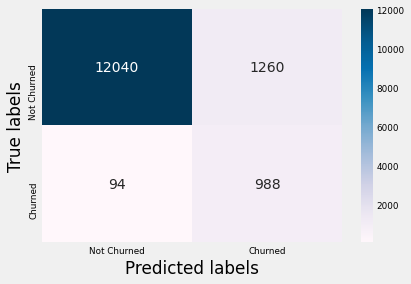

(0.9059, 0.4395, 0.9131, 0.5934, 0.9092)

In [161]:
# Checking the model performance of the train dataset
y_train_cbc = model_cbc.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_cbc)

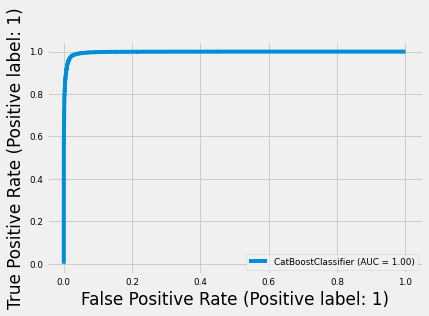

In [162]:
# Plotting the AUC ROC Curve
plot_roc_curve(model_cbc, X_train_resampled,y_train_resampled)
plt.show()

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      5712
           1       0.37      0.79      0.50       452

    accuracy                           0.88      6164
   macro avg       0.67      0.84      0.72      6164
weighted avg       0.94      0.88      0.90      6164

Accuracy Score   :  0.8842
Precision Score  :  0.3655
Recall Score     :  0.7876
F1 Score         :  0.4993
Area under curve :  0.8397 



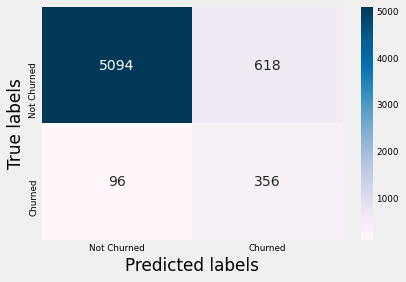

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473
0,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823
0,"Logistic Regression with PCA, SMOTEEN, L2 regu...",0.8065,0.2541,0.8473,0.3910,0.8253
0,SVM with SMOTEENN,0.8290,0.2806,0.8518,0.4221,0.8395
0,Random Forest with class_weight,0.9448,0.7333,0.3894,0.5087,0.6891
0,Random Forest with SMOTEENN,0.9108,0.4369,0.7500,0.5521,0.8367


In [163]:
# Observing the model performance on the test dataset
y_test_cbc = model_cbc.predict(X_test)

print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_cbc)

tempResults = pd.DataFrame({'Model':['CatBoost with SMOTEENN & Hyperparameter tuned'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### LGBM With Hyperparameter Tuning and SMOTEEN

In [164]:
# Performing hyperparameter tuning for LGBM for better accuracy
params_lgb ={'num_leaves': [50,70,100], 
         'max_depth' :[10,20,30],
         'learning_rate': [0.1,0.5,1],
         'n_estimators':[600],
         'min_child_samples': [20,50], 
         'subsample': [0.1,0.3,0.5,1], 
         'colsample_bytree': [0.1,0.5,1]
        }

lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)
g_search_lgb = GridSearchCV(estimator = lgb, param_grid = params_lgb, scoring='recall',cv=3)

g_search_lgb.fit(X_train_resampled,y_train_resampled)

print("LightGBM Best Score : " ,g_search_lgb.best_score_)
print("LightGBM Best Params : " ,g_search_lgb.best_params_)

LightGBM Best Score :  0.987925439589465
LightGBM Best Params :  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 30, 'min_child_samples': 20, 'n_estimators': 600, 'num_leaves': 100, 'subsample': 0.1}


In [165]:
# Model fitting for LGBM with hyperparameters
model_lgbm = LGBMClassifier(boosting_type='gbdt',
                            n_estimators=600,
                            learning_rate=0.1, 
                            max_depth=30, 
                            min_child_samples=20,
                            num_leaves=100, 
                            objective='binary', 
                            random_state=100,
                            subsample=0.1,
                            colsample_bytree=1,
                            n_jobs=-1,
                            silent=True)
model_lgbm.fit(X_train_resampled,y_train_resampled)

LGBMClassifier(colsample_bytree=1, max_depth=30, n_estimators=600,
               num_leaves=100, objective='binary', random_state=100,
               silent=True, subsample=0.1)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98     13300
           1       0.63      1.00      0.78      1082

    accuracy                           0.96     14382
   macro avg       0.82      0.98      0.88     14382
weighted avg       0.97      0.96      0.96     14382

Accuracy Score   :  0.9564
Precision Score  :  0.6331
Recall Score     :  1.0
F1 Score         :  0.7753
Area under curve :  0.9764 



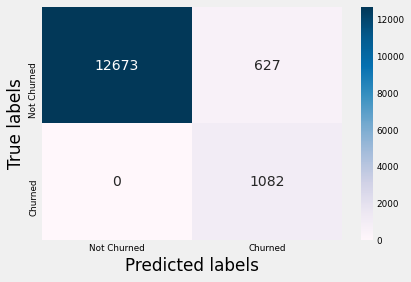

(0.9564, 0.6331, 1.0, 0.7753, 0.9764)

In [166]:
# Checking the model performance of the train dataset
y_train_lgbm = model_lgbm.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_lgbm)

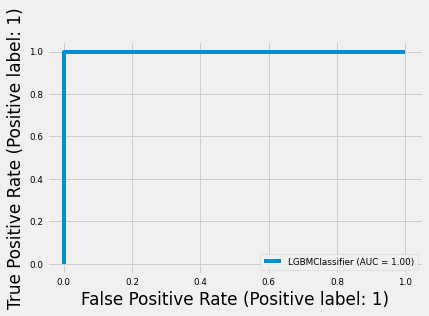

In [167]:
# Plotting the AUC ROC Curve
plot_roc_curve(model_lgbm, X_train_resampled,y_train_resampled)
plt.show()

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      5712
           1       0.48      0.71      0.57       452

    accuracy                           0.92      6164
   macro avg       0.73      0.82      0.77      6164
weighted avg       0.94      0.92      0.93      6164

Accuracy Score   :  0.9226
Precision Score  :  0.4813
Recall Score     :  0.7102
F1 Score         :  0.5737
Area under curve :  0.8248 



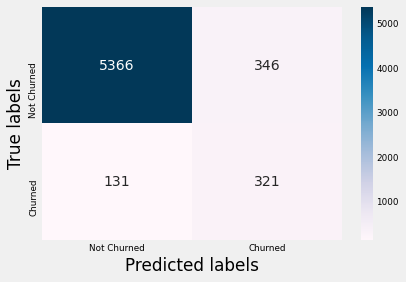

,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Logistic Regression with SMOTEEN & without PCA,0.8079,0.2598,0.8761,0.4008,0.8393
0,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
0,Logistic Regression with PCA & Random over sam...,0.6723,0.1661,0.8628,0.2786,0.7600
0,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184
0,Logistic Regression with PCA & SMOTE,0.7054,0.1727,0.7965,0.2839,0.7473
0,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823
0,"Logistic Regression with PCA, SMOTEEN, L2 regu...",0.8065,0.2541,0.8473,0.3910,0.8253
0,SVM with SMOTEENN,0.8290,0.2806,0.8518,0.4221,0.8395
0,Random Forest with class_weight,0.9448,0.7333,0.3894,0.5087,0.6891
0,Random Forest with SMOTEENN,0.9108,0.4369,0.7500,0.5521,0.8367


In [168]:
# Checking the model performance on the test dataset
y_test_lgbm = model_lgbm.predict(X_test)

print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_lgbm)

tempResults = pd.DataFrame({'Model':['Light GBM with SMOTEENN & Hyperparameter tuned'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

### Rearrangement of Results

In [169]:
# Rearranging the results based on accuracy
results = results.sort_values("Accuracy", ascending = False).reset_index(drop=True)
results


,Model,Accuracy,Precision,Recall,F1 score,Area under ROC curve
0,Random Forest with class_weight,0.9448,0.7333,0.3894,0.5087,0.6891
1,Light GBM with SMOTEENN & Hyperparameter tuned,0.9226,0.4813,0.7102,0.5737,0.8248
2,Random Forest with SMOTEENN,0.9108,0.4369,0.7500,0.5521,0.8367
3,AdaBoost with SMOTEENN & Hyperparameter tuned,0.8903,0.3710,0.7124,0.4879,0.8084
4,CatBoost with SMOTEENN & Hyperparameter tuned,0.8842,0.3655,0.7876,0.4993,0.8397
5,Logistic Regression with PCA & SMOTEENN,0.8722,0.3228,0.6770,0.4371,0.7823
6,Random Forest with SMOTEENN & Hyperparameter t...,0.8602,0.3230,0.8274,0.4646,0.8451
7,Logistic Regression with SMOTE & without PCA,0.8503,0.3049,0.8142,0.4436,0.8336
8,SVM with SMOTEENN,0.8290,0.2806,0.8518,0.4221,0.8395
9,Logistic Regression with PCA & Random under sa...,0.8201,0.2645,0.8164,0.3996,0.8184


#### Observation
Here LGBM classifier is selected for model building purpose over Random forest because it has better recall than Random forest, which plays a very important role in further prediction

## Finding the Feature Importance

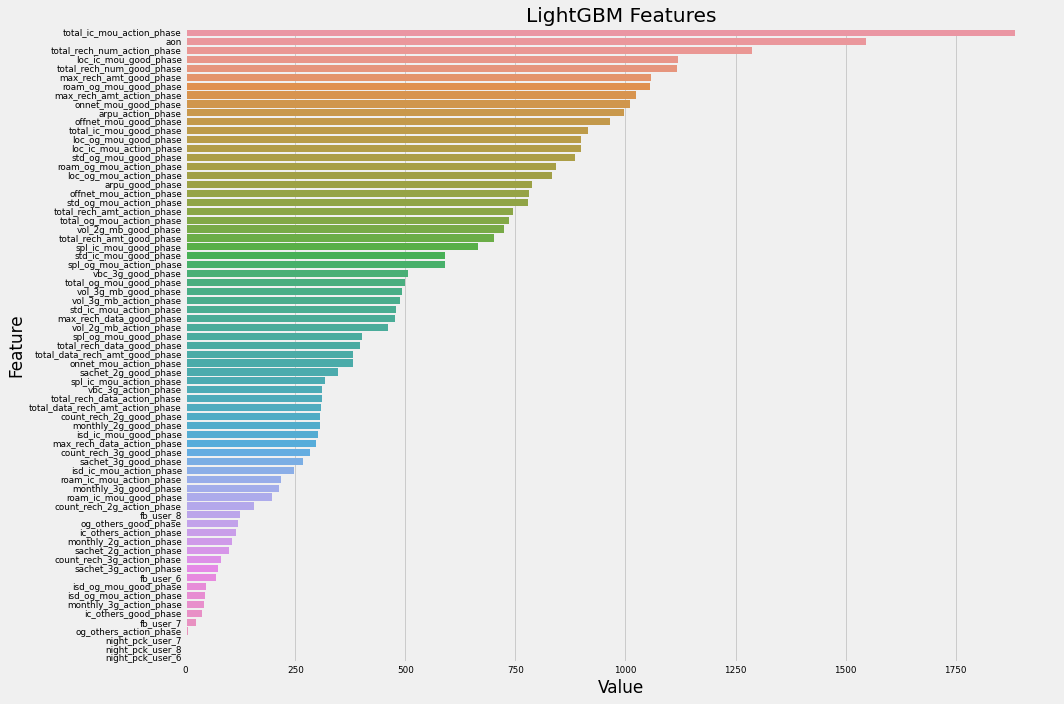

In [170]:
# Finding feature importance for LGBM classifier 
feature_imp = pd.DataFrame(sorted(zip(model_lgbm.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [171]:
# Finding Top 20 features of LGBM: 
feature_imp=feature_imp.sort_values("Value",ascending = False)
feature_imp.head(20)

,Value,Feature
70,1886,total_ic_mou_action_phase
69,1547,aon
68,1287,total_rech_num_action_phase
67,1119,loc_ic_mou_good_phase
66,1116,total_rech_num_good_phase
65,1057,max_rech_amt_good_phase
64,1055,roam_og_mou_good_phase
63,1025,max_rech_amt_action_phase
62,1011,onnet_mou_good_phase
61,996,arpu_action_phase


In [40]:
# Creating a list for best features of LGBM 
best_features = ['total_ic_mou_action_phase', 'aon', 'total_rech_num_action_phase', 'loc_ic_mou_good_phase',
'total_rech_num_good_phase', 'max_rech_amt_good_phase', 'roam_og_mou_good_phase', 'max_rech_amt_action_phase',
'onnet_mou_good_phase', 'arpu_action_phase', 'offnet_mou_good_phase', 'total_ic_mou_good_phase', 'loc_og_mou_good_phase',
'loc_ic_mou_action_phase', 'std_og_mou_good_phase', 'roam_og_mou_action_phase', 'loc_og_mou_action_phase', 'arpu_good_phase',
'offnet_mou_action_phase', 'std_og_mou_action_phase']

## Making Unseen Data Ready for Prediction

In [2]:
# Importing the test data
unseen_data = pd.read_csv('test (1).csv')
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

In [3]:
unseen_data.shape

(30000, 171)

#### Performing all the necessary imputations and data handling technqies applied on the train data to make it ready for prediction

In [4]:
# Checking for NaN values
msng_values_usd = round(unseen_data.isna().sum() / len(unseen_data) * 100, 2).sort_values(ascending=False)
msng_values_usd

arpu_3g_6                   74.72
count_rech_2g_6             74.72
date_of_last_rech_data_6    74.72
av_rech_amt_data_6          74.72
fb_user_6                   74.72
arpu_2g_6                   74.72
total_rech_data_6           74.72
night_pck_user_6            74.72
max_rech_data_6             74.72
count_rech_3g_6             74.72
av_rech_amt_data_7          74.31
count_rech_3g_7             74.31
arpu_3g_7                   74.31
arpu_2g_7                   74.31
night_pck_user_7            74.31
count_rech_2g_7             74.31
max_rech_data_7             74.31
total_rech_data_7           74.31
date_of_last_rech_data_7    74.31
fb_user_7                   74.31
count_rech_2g_8             73.59
max_rech_data_8             73.59
night_pck_user_8            73.59
total_rech_data_8           73.59
arpu_2g_8                   73.59
date_of_last_rech_data_8    73.59
arpu_3g_8                   73.59
count_rech_3g_8             73.59
fb_user_8                   73.59
av_rech_amt_da

In [5]:
# Checking if data recharge null row indexes matches with same customers data of null values in last recharge data information for month of June
if unseen_data['total_rech_data_6'].isnull().equals(unseen_data['date_of_last_rech_data_6'].isnull()):
    print('The indexes for NULL values for month 6 are equal')

The indexes for NULL values for month 6 are equal


In [6]:
# Imputing the data for total_rech_data_6 and av_rech_amt_data_6 as 0
unseen_data['total_rech_data_6'].fillna(0, inplace=True)
unseen_data['av_rech_amt_data_6'].fillna(0, inplace=True)

In [7]:
# Checking if data recharge null row indexes matches with same customers data of null values in last recharge data information for month of July(7)
if unseen_data['total_rech_data_7'].isnull().equals(unseen_data['date_of_last_rech_data_7'].isnull()):
    print('The indexes for NULL values for month 7 are equal')

# Checking if data recharge null row indexes matches with same customers data of null values in last recharge data information for month of August(8)
if unseen_data['total_rech_data_8'].isnull().equals(unseen_data['date_of_last_rech_data_8'].isnull()):
    print('The indexes for NULL values for month 8 are equal')    

The indexes for NULL values for month 7 are equal
The indexes for NULL values for month 8 are equal


In [8]:
# Imputing the data for total_rech_data_7 and av_rech_amt_data_7 as 0
unseen_data['total_rech_data_7'].fillna(0, inplace=True)
unseen_data['av_rech_amt_data_7'].fillna(0, inplace=True)

# Imputing the data for total_rech_data_8 and av_rech_amt_data_8 as 0
unseen_data['total_rech_data_8'].fillna(0, inplace=True)
unseen_data['av_rech_amt_data_8'].fillna(0, inplace=True)

In [9]:
unseen_data.shape

(30000, 171)

In [10]:
# Checking the index matching for month 6
arpu_2g_6_index = unseen_data['arpu_2g_6'].isnull()
arpu_3g_6_index = unseen_data['arpu_3g_6'].isnull()
night_pck_user_6_index = unseen_data['night_pck_user_6'].isnull()
count_rech_2g_6_index =unseen_data['count_rech_2g_6'].isnull()
count_rech_3g_6_index = unseen_data['count_rech_3g_6'].isnull()
fb_user_6_index = unseen_data['fb_user_6'].isnull()

# If all the above objects/arrays are equal for all entries, then we can confirm that the missing values are all from the
# same observations/index.

if arpu_2g_6_index.equals(arpu_2g_6_index) & arpu_3g_6_index.equals(night_pck_user_6_index) & night_pck_user_6_index.equals(count_rech_2g_6_index) & count_rech_2g_6_index.equals(count_rech_3g_6_index) & count_rech_3g_6_index.equals(fb_user_6_index):
    print('The indexes for NULL values for month 6 are equal')

The indexes for NULL values for month 6 are equal


In [11]:
# Checking the index matching for month 7
arpu_2g_7_index = unseen_data['arpu_2g_7'].isnull()
arpu_3g_7_index = unseen_data['arpu_3g_7'].isnull()
night_pck_user_7_index = unseen_data['night_pck_user_7'].isnull()
count_rech_2g_7_index = unseen_data['count_rech_2g_7'].isnull()
count_rech_3g_7_index = unseen_data['count_rech_3g_7'].isnull()
fb_user_7_index = unseen_data['fb_user_7'].isnull()

# If all the above objects/arrays are equal for all entries, then we can confirm that the missing values are all from the
# same observations/index.

if arpu_2g_7_index.equals(arpu_2g_7_index) & arpu_3g_7_index.equals(night_pck_user_7_index) & night_pck_user_7_index.equals(count_rech_2g_7_index) & count_rech_2g_7_index.equals(count_rech_3g_7_index) & count_rech_3g_7_index.equals(fb_user_7_index):
    print('The indexes for NULL values for month 7 are equal')

The indexes for NULL values for month 7 are equal


In [12]:
# Checking the index matching for month 8
arpu_2g_8_index = unseen_data['arpu_2g_8'].isnull()
arpu_3g_8_index = unseen_data['arpu_3g_8'].isnull()
night_pck_user_8_index = unseen_data['night_pck_user_8'].isnull()
count_rech_2g_8_index =unseen_data['count_rech_2g_8'].isnull()
count_rech_3g_8_index = unseen_data['count_rech_3g_8'].isnull()
fb_user_8_index = unseen_data['fb_user_8'].isnull()

# If all the above objects/arrays are equal for all entries, then we can confirm that the missing values are all from the
# same observations/index.

if arpu_2g_8_index.equals(arpu_2g_8_index) & arpu_3g_8_index.equals(night_pck_user_8_index) & night_pck_user_8_index.equals(count_rech_2g_8_index) & count_rech_2g_8_index.equals(count_rech_3g_8_index) & count_rech_3g_8_index.equals(fb_user_8_index):
    print('The indexes for NULL values for month 8 are equal')

The indexes for NULL values for month 8 are equal


In [13]:
cols_to_impute = ['fb_user_6','fb_user_7','fb_user_8',
                  'night_pck_user_6','night_pck_user_7','night_pck_user_8',
                  'arpu_3g_6','arpu_3g_7','arpu_3g_8',
                  'arpu_2g_6','arpu_2g_7','arpu_2g_8',
                  'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
                  'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8',]
for col in cols_to_impute:
    unseen_data[col].fillna(0, inplace=True)

In [14]:
unseen_data.rename(columns = {'jun_vbc_3g':'vbc_3g_6',
                          'jul_vbc_3g':'vbc_3g_7',
                          'aug_vbc_3g':'vbc_3g_8',
                          'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

In [15]:
unseen_data[['arpu_6', 'arpu_7', 'arpu_8']].describe()

,arpu_6,arpu_7,arpu_8
count,30000.000000,30000.000000,30000.000000
mean,282.644348,279.355021,279.845167
std,314.560212,323.205370,326.437029
min,-185.043000,-2014.045000,-146.859000
25%,92.907500,87.504750,84.180500
50%,198.227500,191.775000,191.690500
75%,371.969250,365.250750,367.804750
max,10955.066000,13224.119000,13505.996000


In [16]:
# calculating total_data_rech_amt
unseen_data['total_data_rech_amt_6'] = unseen_data['total_rech_data_6'] * unseen_data['av_rech_amt_data_6']
unseen_data['total_data_rech_amt_7'] = unseen_data['total_rech_data_7'] * unseen_data['av_rech_amt_data_7']
unseen_data['total_data_rech_amt_8'] = unseen_data['total_rech_data_8'] * unseen_data['av_rech_amt_data_8']


In [17]:
unseen_data.shape

(30000, 174)

In [18]:
# Checking for missing values
msng_values_usd = round(unseen_data.isna().sum() / len(unseen_data) * 100, 2).sort_values(ascending=False)
msng_values_usd

date_of_last_rech_data_6    74.72
max_rech_data_6             74.72
max_rech_data_7             74.31
date_of_last_rech_data_7    74.31
date_of_last_rech_data_8    73.59
max_rech_data_8             73.59
roam_og_mou_8                5.58
std_og_t2c_mou_8             5.58
loc_og_t2t_mou_8             5.58
loc_og_t2m_mou_8             5.58
std_ic_t2m_mou_8             5.58
std_og_t2f_mou_8             5.58
loc_og_t2f_mou_8             5.58
std_ic_t2t_mou_8             5.58
loc_og_t2c_mou_8             5.58
isd_ic_mou_8                 5.58
loc_og_mou_8                 5.58
std_ic_t2f_mou_8             5.58
std_og_t2t_mou_8             5.58
std_og_t2m_mou_8             5.58
std_ic_mou_8                 5.58
roam_ic_mou_8                5.58
loc_ic_mou_8                 5.58
loc_ic_t2t_mou_8             5.58
ic_others_8                  5.58
spl_og_mou_8                 5.58
loc_ic_t2m_mou_8             5.58
spl_ic_mou_8                 5.58
loc_ic_t2f_mou_8             5.58
isd_og_mou_8  

In [19]:
#dropping the date_of_last_rech_data_6, date_of_last_rech_data_7, date_of_last_rech_data_8 columns
unseen_data.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'],axis = 1, inplace = True)
print("Number of Columns remaining:",len(unseen_data.columns))

Number of Columns remaining: 171


In [20]:
# checking the data distribution of these 3 columns : 
unseen_data[['max_rech_data_6', 'max_rech_data_7' , 'max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,7585.000000,7706.000000,7922.000000
mean,126.146473,127.488451,126.513254
std,106.428898,110.474812,108.948608
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,145.000000,145.000000,145.000000
75%,154.000000,177.000000,179.000000
max,1555.000000,1555.000000,1555.000000


In [21]:
# How many rows are null ?
print ("Total NULL values for max_rech_data_6 column : ",unseen_data.max_rech_data_6.isnull().sum())
print ("Total NULL values for max_rech_data_7 column : ",unseen_data.max_rech_data_7.isnull().sum())
print ("Total NULL values for max_rech_data_8 column : ",unseen_data.max_rech_data_8.isnull().sum())

Total NULL values for max_rech_data_6 column :  22415
Total NULL values for max_rech_data_7 column :  22294
Total NULL values for max_rech_data_8 column :  22078


In [22]:
for col in ['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']:
    unseen_data[col].fillna(0, inplace=True)

In [23]:
# Re-check missing values
round(unseen_data.isna().sum() / len(unseen_data) * 100, 2).sort_values(ascending=False)

std_ic_t2f_mou_8         5.58
offnet_mou_8             5.58
loc_og_mou_8             5.58
std_og_t2t_mou_8         5.58
loc_og_t2c_mou_8         5.58
std_og_t2m_mou_8         5.58
loc_og_t2f_mou_8         5.58
std_og_t2f_mou_8         5.58
loc_og_t2m_mou_8         5.58
std_ic_mou_8             5.58
loc_og_t2t_mou_8         5.58
std_og_t2c_mou_8         5.58
loc_ic_t2t_mou_8         5.58
roam_og_mou_8            5.58
std_ic_t2m_mou_8         5.58
std_og_mou_8             5.58
roam_ic_mou_8            5.58
spl_ic_mou_8             5.58
spl_og_mou_8             5.58
ic_others_8              5.58
loc_ic_t2m_mou_8         5.58
isd_ic_mou_8             5.58
og_others_8              5.58
loc_ic_t2f_mou_8         5.58
loc_ic_mou_8             5.58
std_ic_t2t_mou_8         5.58
isd_og_mou_8             5.58
onnet_mou_8              5.58
std_ic_t2o_mou_8         5.58
spl_og_mou_7             3.91
std_og_t2c_mou_7         3.91
spl_ic_mou_7             3.91
isd_ic_mou_7             3.91
og_others_

In [24]:
# Delete all the date columns
unseen_data.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
                        'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], axis = 1, inplace = True)
unseen_data.shape

(30000, 165)

In [25]:
#Variance 
columns_with_0_variance = unseen_data.var() == 0
print("Total columns with ZERO variance are : ", columns_with_0_variance.sum())

column_name_with_0_variance = columns_with_0_variance[columns_with_0_variance == 1].index
print(column_name_with_0_variance)

Total columns with ZERO variance are :  10
Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')


In [26]:
# We will drop these columns where variance is 0
unseen_data.drop(column_name_with_0_variance,axis=1, inplace = True)
unseen_data.shape

(30000, 155)

In [27]:
# Let's drop individual columns whose totals are available as a different attribute

individual_cols = ['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
                   'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
                   'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
                   'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8',
                   'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8',
                   'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',
                   'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
                   'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
                   'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
                   'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
                   'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
                   'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
                   'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
                   'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
                   'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
                   'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
                   'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']

unseen_data.drop(individual_cols, axis = 1, inplace = True)

unseen_data.shape


(30000, 104)

In [28]:
# Let's store the null columns as a list first
cols_null_usd = unseen_data.columns[unseen_data.isna().any()].tolist()
print(cols_null_usd)

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8']


In [29]:
imp = IterativeImputer()
unseen_data[cols_null_usd] = imp.fit_transform(unseen_data[cols_null_usd])

In [30]:
unseen_data.isnull().sum()

id                       0
arpu_6                   0
arpu_7                   0
arpu_8                   0
onnet_mou_6              0
onnet_mou_7              0
onnet_mou_8              0
offnet_mou_6             0
offnet_mou_7             0
offnet_mou_8             0
roam_ic_mou_6            0
roam_ic_mou_7            0
roam_ic_mou_8            0
roam_og_mou_6            0
roam_og_mou_7            0
roam_og_mou_8            0
loc_og_mou_6             0
loc_og_mou_7             0
loc_og_mou_8             0
std_og_mou_6             0
std_og_mou_7             0
std_og_mou_8             0
isd_og_mou_6             0
isd_og_mou_7             0
isd_og_mou_8             0
spl_og_mou_6             0
spl_og_mou_7             0
spl_og_mou_8             0
og_others_6              0
og_others_7              0
og_others_8              0
total_og_mou_6           0
total_og_mou_7           0
total_og_mou_8           0
loc_ic_mou_6             0
loc_ic_mou_7             0
loc_ic_mou_8             0
s

In [31]:
# Checking the unique values in the dataframe
#funtion for creation a dataframe to record the columns, their unique values and unique value counts

def frequency_info(df):
    df_result = pd.DataFrame(columns=["columns","values","unique_values"])
    
    df_temp=pd.DataFrame()
    for value in df.columns:
        df_temp["columns"] = [value]
        df_temp["values"] = [df[value].unique()]
        df_temp["unique_values"] = df[value].nunique()
        df_result = df_result.append(df_temp)
    
    df_result.sort_values("unique_values", ascending =True, inplace=True)
    df_result.set_index("columns", inplace=True)
    return df_result

In [32]:
# Let's check the unique values to identify which can be categorical columns
frequency_info(unseen_data)

,values,unique_values
columns,,
night_pck_user_6,"[0.0, 1.0]",2
night_pck_user_8,"[0.0, 1.0]",2
fb_user_8,"[0.0, 1.0]",2
fb_user_7,"[0.0, 1.0]",2
fb_user_6,"[0.0, 1.0]",2
night_pck_user_7,"[0.0, 1.0]",2
monthly_2g_6,"[0, 1, 2, 3, 4]",5
monthly_2g_8,"[0, 1, 2, 3, 4, 5]",6
monthly_2g_7,"[0, 1, 2, 3, 4, 5]",6


In [33]:
# We will convert the columns which have 2 values to an ordered categorical column and convert it to int type
category_list = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

unseen_data[category_list] = unseen_data[category_list].astype(int)

unseen_data[category_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   night_pck_user_6  30000 non-null  int32
 1   night_pck_user_7  30000 non-null  int32
 2   night_pck_user_8  30000 non-null  int32
 3   fb_user_6         30000 non-null  int32
 4   fb_user_7         30000 non-null  int32
 5   fb_user_8         30000 non-null  int32
dtypes: int32(6)
memory usage: 703.2 KB


In [34]:
# Custom Function to derive new good phase columns and drop the original columns 
def derive_good_action_phase(df, col):
    
    col_6 = col + "_6"
    col_7 = col + "_7"
    col_8 = col + "_8"
    good_phase_col = col + "_good_phase"
    action_phase_col = col + "_action_phase"
    
    df[good_phase_col] = (df[col_6] + df[col_7])/2
    df[action_phase_col] = df[col_8]
    
    df.drop([col_6, col_7, col_8], axis = 1, inplace = True)
    
    return df

In [35]:
# Creating features for good phase and action phase column : 

cols = ["arpu","onnet_mou","offnet_mou","roam_ic_mou","roam_og_mou","loc_og_mou","std_og_mou",
        "isd_og_mou","spl_og_mou","og_others","total_og_mou","loc_ic_mou","std_ic_mou",
        "spl_ic_mou","isd_ic_mou","ic_others","total_ic_mou","total_rech_num","total_rech_amt",
        "max_rech_amt","total_rech_data","max_rech_data","count_rech_2g","count_rech_3g",
        "vol_2g_mb","vol_3g_mb","monthly_2g","sachet_2g","sachet_3g",
        "monthly_3g","vbc_3g","total_data_rech_amt"]

for col in cols : 
    unseen_data = derive_good_action_phase(unseen_data, col)
    print (col)

arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
total_og_mou
loc_ic_mou
std_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_ic_mou
total_rech_num
total_rech_amt
max_rech_amt
total_rech_data
max_rech_data
count_rech_2g
count_rech_3g
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
sachet_3g
monthly_3g
vbc_3g
total_data_rech_amt


In [36]:
#Checking the dataframe after conversion
unseen_data.head()

,id,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,arpu_good_phase,arpu_action_phase,onnet_mou_good_phase,onnet_mou_action_phase,offnet_mou_good_phase,offnet_mou_action_phase,roam_ic_mou_good_phase,roam_ic_mou_action_phase,roam_og_mou_good_phase,roam_og_mou_action_phase,loc_og_mou_good_phase,loc_og_mou_action_phase,std_og_mou_good_phase,std_og_mou_action_phase,isd_og_mou_good_phase,isd_og_mou_action_phase,spl_og_mou_good_phase,spl_og_mou_action_phase,og_others_good_phase,og_others_action_phase,total_og_mou_good_phase,total_og_mou_action_phase,loc_ic_mou_good_phase,loc_ic_mou_action_phase,std_ic_mou_good_phase,std_ic_mou_action_phase,spl_ic_mou_good_phase,spl_ic_mou_action_phase,isd_ic_mou_good_phase,isd_ic_mou_action_phase,ic_others_good_phase,ic_others_action_phase,total_ic_mou_good_phase,total_ic_mou_action_phase,total_rech_num_good_phase,total_rech_num_action_phase,total_rech_amt_good_phase,total_rech_amt_action_phase,max_rech_amt_good_phase,max_rech_amt_action_phase,total_rech_data_good_phase,total_rech_data_action_phase,max_rech_data_good_phase,max_rech_data_action_phase,count_rech_2g_good_phase,count_rech_2g_action_phase,count_rech_3g_good_phase,count_rech_3g_action_phase,vol_2g_mb_good_phase,vol_2g_mb_action_phase,vol_3g_mb_good_phase,vol_3g_mb_action_phase,monthly_2g_good_phase,monthly_2g_action_phase,sachet_2g_good_phase,sachet_2g_action_phase,sachet_3g_good_phase,sachet_3g_action_phase,monthly_3g_good_phase,monthly_3g_action_phase,vbc_3g_good_phase,vbc_3g_action_phase,total_data_rech_amt_good_phase,total_data_rech_amt_action_phase
0,69999,0,0,0,0,0,0,1692,78.6060,64.445,26.005,23.11,46.160,34.83,0.000,0.00,0.000,0.00,43.860,29.43,28.305,28.48,0.0,0.0,0.000,0.03,0.0,0.0,72.165,57.94,41.485,31.51,0.700,4.34,0.44,0.39,0.000,0.00,0.0,0.00,42.645,36.26,5.0,4,96.5,60,40.0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.000,0.00,0.0,0.0
1,70000,0,0,0,0,0,0,2533,464.8680,360.868,58.360,19.84,548.090,394.94,0.000,0.00,0.000,0.00,594.575,397.11,11.880,17.68,0.0,0.8,0.000,0.00,0.0,0.0,606.460,415.59,165.465,187.43,6.255,0.00,0.00,0.00,146.255,94.23,0.0,0.00,317.985,281.66,4.5,5,500.0,500,250.0,250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.000,0.00,0.0,0.0
2,70001,0,0,0,0,0,0,277,382.3640,746.239,7.700,8.40,31.395,45.04,63.095,26.08,39.105,54.44,0.000,0.00,0.000,0.00,0.0,0.0,0.000,0.00,0.0,0.0,0.000,0.00,0.000,0.00,0.000,0.00,0.00,0.00,0.000,0.00,0.0,0.00,0.000,0.00,7.5,5,750.0,1000,400.0,500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,500.125,525.61,0.0,0.0
3,70002,0,0,0,0,0,0,1244,107.4700,24.400,3.735,0.00,122.525,24.01,0.000,0.00,0.000,0.00,53.435,22.86,66.810,0.00,0.0,0.0,6.015,1.15,0.0,0.0,126.270,24.01,525.460,531.64,12.885,8.83,0.00,0.00,0.715,8.65,0.0,0.00,539.065,549.13,4.0,2,185.0,0,130.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.000,0.00,0.0,0.0
4,70003,0,0,0,0,0,0,462,356.5715,413.329,529.980,700.68,42.390,74.16,0.000,0.00,0.000,0.00,3.140,25.51,569.230,749.29,0.0,0.0,3.050,4.96,1.1,0.0,576.535,779.78,9.860,17.61,74.960,141.48,0.00,0.00,0.000,0.00,0.0,0.16,84.830,159.26,9.0,8,423.0,546,110.0,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.000,0.00,0.0,0.0


In [37]:
#Checking the new shape of the dataframe
unseen_data.shape

(30000, 72)

In [38]:
unseen_data.isnull().sum()

id                                  0
night_pck_user_6                    0
night_pck_user_7                    0
night_pck_user_8                    0
fb_user_6                           0
fb_user_7                           0
fb_user_8                           0
aon                                 0
arpu_good_phase                     0
arpu_action_phase                   0
onnet_mou_good_phase                0
onnet_mou_action_phase              0
offnet_mou_good_phase               0
offnet_mou_action_phase             0
roam_ic_mou_good_phase              0
roam_ic_mou_action_phase            0
roam_og_mou_good_phase              0
roam_og_mou_action_phase            0
loc_og_mou_good_phase               0
loc_og_mou_action_phase             0
std_og_mou_good_phase               0
std_og_mou_action_phase             0
isd_og_mou_good_phase               0
isd_og_mou_action_phase             0
spl_og_mou_good_phase               0
spl_og_mou_action_phase             0
og_others_go

## Pipeline Fitting and Final Evaluation 

In [115]:
# Intializing the features for the pipeline
scale = StandardScaler()
lgbm = LGBMClassifier(boosting_type='gbdt',
                            n_estimators=600,
                            learning_rate=0.1, 
                            max_depth=30, 
                            min_child_samples=20,
                            num_leaves=100, 
                            objective='binary', 
                            random_state=100,
                            subsample=0.1,
                            colsample_bytree=1,
                            n_jobs=-1,
                            silent=True)

In [116]:
# Creating a Pipeline
pipe = Pipeline(steps = [('scaling',scale),
                         ('model',lgbm)])

In [117]:
# Fitting the pipeline on the train data 
pipe.fit(X_train_resampled[best_features], y_train_resampled)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 LGBMClassifier(colsample_bytree=1, max_depth=30,
                                n_estimators=600, num_leaves=100,
                                objective='binary', random_state=100,
                                silent=True, subsample=0.1))])

In [118]:
# Checking the train accuracy
train_score = pipe.score(X_train_resampled[best_features], y_train_resampled)
print("Training accuracy:", train_score)

Training accuracy: 1.0


In [119]:
# Checking the test accuracy
test_score = pipe.score(X_test[best_features], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.923264114211551


In [120]:
# Plotting confusion matrix for train data
confusion_matrix(y_train_resampled, pipe.predict(X_train_resampled[best_features]))

array([[10955,     0],
       [    0, 13250]], dtype=int64)

In [121]:
# Plotting confusion matrix for test data
confusion_matrix(y_test, pipe.predict(X_test[best_features]))

array([[5387,  325],
       [ 148,  304]], dtype=int64)

In [122]:
# Checking the precision score 
precision_score(y_test, pipe.predict(X_test[best_features]))

0.48330683624801274

In [123]:
# Checking the recall score 
recall_score(y_test, pipe.predict(X_test[best_features]))

0.672566371681416

In [124]:
# Making test data ready for submission
submission_data = unseen_data.set_index('id')[best_features]
submission_data.shape

(30000, 20)

In [125]:
# # Making test data ready for submission
unseen_data['churn_probability'] = pipe.predict(submission_data)
output = unseen_data[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [127]:
# Saving the output file as csv
output.to_csv('final_submission_lgbm_Ashwini_Abhang.csv',index=False)

## Conclusion:- 

In this case study I have first handled the missing data with the help of various data pre-processing techniques such as sklearn's Iterative Imputer and standard scalar for standardisation of data. After pre-processing the data I performed Exploratory data analysis (EDA). During which I observed that the data was heavly imbalanced towards the '0' class. 

I handledthis imbalanced data with the help of various sampling techniques like Synthetic Minority Over Sampling Technique with Edited Nearest Neighbours (SMOTEENN). After which I handled the outliers using the boxcox transformation. 


Once the EDA was completed I performed Feature Engineering on the features to derive new features so as to enhance and consolidate the data and improve it's accuracy. After feature engineering I started with the Model Selection process in which I used Recursive Feature elimination(RFE) eliminating unimportant features. Here I used models like Logistic Regression, Random Forest, Support Vector Machine, Adaboost, CatBoost and LGBM. 

I also used PCA for dimensionality reduction. Finally I used LGBM classifier over random forest as it had better recall than random forest. In the end I found out the feature importances of LGBM classifier and created a pipeline with it and observed train accuracy of 100% and testing accuracy of 92.32%